# Imports

In [1]:
server_args = []

# start a single meshcat server instance to use for remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

In [2]:
import numpy as np
from IPython.display import display, HTML
import pydrake
from pydrake.all import (
    DiagramBuilder, ConnectMeshcatVisualizer, Simulator, FindResourceOrThrow,
    Parser, MultibodyPlant, RigidTransform, LeafSystem, BasicVector,
    JacobianWrtVariable, RollPitchYaw, SignalLogger, AddTriad,
    PiecewisePolynomial, PiecewiseQuaternionSlerp, RotationMatrix, Solve,
    TrajectorySource, ConstantVectorSource,
    AddMultibodyPlantSceneGraph, AngleAxis, ConnectMeshcatVisualizer, 
    MultibodyPositionToGeometryPose, Parser, 
    Quaternion, SceneGraph, GenerateHtml, InverseDynamicsController, SnoptSolver, IpoptSolver
)
from pydrake.multibody import inverse_kinematics
from pydrake.trajectories import PiecewisePolynomial
from pydrake.common.value import AbstractValue
from pydrake.examples.manipulation_station import ManipulationStation

import pandas as pd
import altair as alt
import pydot
from IPython.display import display, SVG
from ipywidgets import Text, Textarea, Layout
import plotly.express as px
from pydrake.multibody.inverse_kinematics import InverseKinematics

def dataframe(trajectory, times, names):
  assert trajectory.rows() == len(names)
  values = trajectory.vector_values(times)
  data = {'t': times }
  for i in range(len(names)):
    data[names[i]] = values[i,:]
  return pd.DataFrame(data)

# Generate Trajectory

## Pick out keyframe poses and times

In [3]:
def grasp_poses_example():
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(plant, scene_graph)
    grasp = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/manipulation/models/franka_description/urdf/hand.urdf"), "grasp")
    # TODO(russt): Draw the pregrasp gripper, too, as transparent (drake #13970).
    #pregrasp = parser.AddModelFromFile(FindResourceOrThrow(
    #    "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"), "pregrasp")
    
    brick = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf"))
    plant.Finalize()

    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    # Get the current object, O, pose
    B_O = plant.GetBodyByName("base_link", brick)
    X_WO = plant.EvalBodyPoseInWorld(plant_context, B_O)

    B_Ggrasp = plant.GetBodyByName("panda_hand", grasp)
    p_GgraspO = [0, 0, 0.12]
    R_GgraspO = RotationMatrix.MakeXRotation(np.pi)
        

    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    X_WGgrasp = X_WO.multiply(X_OGgrasp)
    
  

    plant.SetFreeBodyPose(plant_context, B_Ggrasp, X_WGgrasp)

    
    plant.GetJointByName("panda_finger_joint1", grasp).set_translation(plant_context, 0.04)
    plant.GetJointByName("panda_finger_joint2", grasp).set_translation(plant_context, 0.04)
    
    
    
    meshcat.load()
    diagram.Publish(context)

#grasp_poses_example()

In [4]:
def make_gripper_frames(X_G, X_O):
  """
  Takes a partial specification with X_G["initial"] and X_O["initial"] and X_0["goal"], and 
  returns a X_G and times with all of the pick and place frames populated.
  """

  p_GgraspO = [0, 0, 0.12]
  R_GgraspO = RotationMatrix.MakeXRotation(np.pi)
  X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
  X_OGgrasp = X_GgraspO.inverse()
  # pregrasp is negative z in the gripper frame
  X_GgraspGpregrasp = RigidTransform([0, 0, -0.08])

  X_G["pick"] = X_O["initial"].multiply(X_OGgrasp)
  X_G["prepick"] = X_G["pick"].multiply(X_GgraspGpregrasp)
  X_G["place"] = X_O["goal"].multiply(X_OGgrasp)
  X_G["preplace"] = X_G["place"].multiply(X_GgraspGpregrasp)

  # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.
  X_GprepickGpreplace = X_G["prepick"].inverse().multiply(X_G["preplace"])
  angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
  X_GprepickGclearance = RigidTransform(AngleAxis(angle=angle_axis.angle()/2.0, axis=angle_axis.axis()), 
                                        X_GprepickGpreplace.translation()/2.0 + np.array([0, 0, -0.3]))
  X_G["clearance"] = X_G["prepick"].multiply(X_GprepickGclearance)

  # Now let's set the timing
  times = {"initial": 0}
  X_GinitialGprepick = X_G["initial"].inverse().multiply(X_G["prepick"])
  times["prepick"] = times["initial"] + 10.0*np.linalg.norm(X_GinitialGprepick.translation())
  # Allow some time for the gripper to close.
  times["pick_start"] = times["prepick"] + 2.0
  times["pick_end"] = times["pick_start"] + 2.0
  times["postpick"] = times["pick_end"] + 2.0
  time_to_from_clearance = 10.0*np.linalg.norm(X_GprepickGclearance.translation())
  times["clearance"] = times["postpick"] + time_to_from_clearance
  times["preplace"] = times["clearance"] + time_to_from_clearance
  times["place_start"] = times["preplace"] + 2.0
  times["place_end"] = times["place_start"] + 2.0
  times["postplace"] = times["place_end"] + 2.0

  return X_G, times

X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi).multiply(RotationMatrix.MakeZRotation(-np.pi/2)), [0, -0.25, 0.25])}
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

Sanity check: The entire maneuver will take 30.900220749318255 seconds to execute.


In [5]:
def visualize_gripper_frames(X_G, X_O):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(plant, scene_graph)
    gripper = FindResourceOrThrow(
        "drake/manipulation/models/franka_description/urdf/hand.urdf")
    brick = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")
    for key, pose in X_G.items():
      g = parser.AddModelFromFile(gripper, f"gripper_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_hand", g), pose)
    for key, pose in X_O.items():
      o = parser.AddModelFromFile(brick, f"object_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", o), pose)

    plant.Finalize()


    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
    meshcat.load()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

#visualize_gripper_frames(X_G, X_O)

In [6]:
def make_gripper_position_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    # The syntax here is a little ugly; we need to pass in a matrix with the samples in the columns.
    traj = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["prepick"]], np.vstack([X_G["initial"].translation(), X_G["prepick"].translation()]).T)

    # TODO(russt): I could make this less brittle if I was more careful on the names above, and just look up the pose for every time (in order)
    traj.AppendFirstOrderSegment(times["pick_start"], X_G["pick"].translation())
    traj.AppendFirstOrderSegment(times["pick_end"], X_G["pick"].translation())
    traj.AppendFirstOrderSegment(times["postpick"], X_G["prepick"].translation())
    traj.AppendFirstOrderSegment(times["clearance"], X_G["clearance"].translation())
    traj.AppendFirstOrderSegment(times["preplace"], X_G["preplace"].translation())
    traj.AppendFirstOrderSegment(times["place_start"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["place_end"], X_G["place"].translation())
    traj.AppendFirstOrderSegment(times["postplace"], X_G["preplace"].translation())

    return traj

traj_p_G = make_gripper_position_trajectory(X_G, times)

In [7]:
data = dataframe(traj_p_G, traj_p_G.get_segment_times(), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

alt.VConcatChart(...)

In [8]:
data = dataframe(traj_p_G, np.linspace(traj_p_G.start_time(), traj_p_G.end_time(), 50), ['x','y','z'])
fig = px.line_3d(data, x='x', y='y', z='z')
fig.update_traces(mode='lines+markers',
                  marker=dict(size=3, color="rgb(153, 51, 51)"),
                  line=dict(color="rgb(153, 51, 51)"))

fig.show()

In [9]:
def make_gripper_orientation_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    traj = PiecewiseQuaternionSlerp();
    traj.Append(times["initial"], X_G["initial"].rotation())
    traj.Append(times["prepick"], X_G["prepick"].rotation())
    traj.Append(times["pick_start"], X_G["pick"].rotation())
    traj.Append(times["pick_end"], X_G["pick"].rotation())
    traj.Append(times["postpick"], X_G["prepick"].rotation())
    traj.Append(times["clearance"], X_G["clearance"].rotation())
    traj.Append(times["preplace"], X_G["preplace"].rotation())
    traj.Append(times["place_start"], X_G["place"].rotation())
    traj.Append(times["place_end"], X_G["place"].rotation())
    traj.Append(times["postplace"], X_G["preplace"].rotation())

    return traj

traj_R_G = make_gripper_orientation_trajectory(X_G, times)

In [10]:
opened = np.array([0.08]);
closed = np.array([0.0]);

def make_wsg_command_trajectory(times):
    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]], np.hstack([[opened], [opened]]))
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)
    return traj_wsg_command

traj_wsg_command = make_wsg_command_trajectory(times)

In [11]:
data = dataframe(traj_wsg_command, traj_wsg_command.get_segment_times(), ['wsg'])
alt.Chart(data).mark_line().encode(x='t', y='wsg').properties(height=80)

alt.Chart(...)

In [12]:
class GripperTrajectoriesToPosition(LeafSystem):
    def __init__(self, plant, traj_p_G, traj_R_G, traj_wsg_command):
        LeafSystem.__init__(self)
        self.plant = plant
        self.gripper_body = plant.GetBodyByName("panda_hand")
        self.left_finger_joint = plant.GetJointByName("panda_finger_joint1")
        self.right_finger_joint = plant.GetJointByName("panda_finger_joint2")
        self.traj_p_G = traj_p_G
        self.traj_R_G = traj_R_G
        self.traj_wsg_command = traj_wsg_command
        self.plant_context = plant.CreateDefaultContext()

        self.DeclareVectorOutputPort("position", 
                                     BasicVector(plant.num_positions()),
                                     self.CalcPositionOutput)

    def CalcPositionOutput(self, context, output):
        t = context.get_time()
        X_G = RigidTransform(Quaternion(self.traj_R_G.value(t)), self.traj_p_G.value(t))
        self.plant.SetFreeBodyPose(self.plant_context, self.gripper_body, X_G)
        wsg = self.traj_wsg_command.value(t)
        self.left_finger_joint.set_translation(self.plant_context, wsg/2.0)
        self.right_finger_joint.set_translation(self.plant_context, wsg/2.0)
        output.SetFromVector(self.plant.GetPositions(self.plant_context))

def visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O):
    builder = DiagramBuilder()

    # Note: Don't use AddMultibodyPlantSceneGraph because we are only using
    # MultibodyPlant for parsing, then wiring directly to SceneGraph.
    scene_graph = builder.AddSystem(SceneGraph())
    plant = MultibodyPlant(time_step=0.0)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant, scene_graph)
    gripper = parser.AddModelFromFile(FindResourceOrThrow(
        "drake/manipulation/models/franka_description/urdf/hand.urdf"), "gripper")
    brick = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")
    for key, pose in X_O.items():
      o = parser.AddModelFromFile(brick, f"object_{key}")
      plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", o), pose)
    plant.Finalize()

    to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
    builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

    traj_to_position = builder.AddSystem(GripperTrajectoriesToPosition(plant, traj_p_G, traj_R_G, traj_wsg_command))
    builder.Connect(traj_to_position.get_output_port(), to_pose.get_input_port())

    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    meshcat.start_recording()
    simulator.AdvanceTo(traj_p_G.end_time())
    meshcat.publish_recording()

#visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O)

# Control Panda

In [21]:
class PandaController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._panda = plant.GetModelInstanceByName("panda")
        
        # get frames
        self._G = plant.GetBodyByName("panda_hand").body_frame() # the gripper frame
        self._W = plant.world_frame() # the world frame
        
        # the input port for the next desired pose
        self.p_WG_port = self.DeclareVectorInputPort("p_WG", BasicVector(3))
        self.R_WG_port = self.DeclareVectorInputPort("R_WG", BasicVector(4))
        # input port for the current generalized positions (joint angles)
        self.q_port = self.DeclareVectorInputPort("prev_panda_state", BasicVector(18))
        self.DeclareVectorOutputPort("next_panda_state", BasicVector(18), self.CalcOutput) # output port for the next generalized position
        
    
    def CalcOutput(self, context, output):
        position_tolerance = 0.01
        orientation_tolerance = 0.01
        
        p_WG = self.p_WG_port.Eval(context)
        print(self.p_WG_port.Eval(context))
        #print(self.R_WG_port.Eval(context))
        #R_WG = RotationMatrix(Quaternion(self.R_WG_port.Eval(context)))
        q0 = self.q_port.Eval(context)[0:9] # we dont care about the velocities
        
        ik =InverseKinematics(self._plant, self._plant_context)
        ik.AddPointToPointDistanceConstraint(self._G, np.array([0,0,0]), self._W, p_WG, 0, position_tolerance) 
        ik.AddOrientationConstraint(self._G, RotationMatrix(), self._W, RotationMatrix(), orientation_tolerance)
        prog = ik.get_mutable_prog()
        
        q = ik.q()
        if (q0 is not None):
          prog.SetInitialGuess(q, q0)
        result = Solve(prog)
        q = result.GetSolution()
        x = np.hstack((q, 0*q))
        output.SetFromVector(x)

In [22]:
X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
       "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}

builder = DiagramBuilder()

panda_file = FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf")
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
panda_model = Parser(plant, scene_graph).AddModelFromFile(panda_file, 'panda')
plant.WeldFrames(plant.world_frame(),plant.GetFrameByName("panda_link0"))
plant.Finalize()

# panda controller
Kp = np.full(9, 100)
Ki = 2 * np.sqrt(Kp)
Kd = np.full(9, 1)
pid_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
pid_controller.set_name("panda_controller");
builder.Connect(plant.get_state_output_port(panda_model),
                pid_controller.get_input_port_estimated_state())
builder.Connect(pid_controller.get_output_port_control(),
                plant.get_actuation_input_port())




#temp_context = diagram.CreateDefaultContext()
#temp_plant_context = plant.GetMyMutableContextFromRoot(temp_context)
#q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0, 0]) # nominal q
#plant.SetPositions(temp_plant_context, q0)
X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi).multiply(RotationMatrix.MakeZRotation(-np.pi/2)), [0, -0.25, 0.25])}
X_G, times = make_gripper_frames(X_G, X_O)
print(f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute.")

traj_p_WG = make_gripper_position_trajectory(X_G, times)
traj_R_WG = make_gripper_orientation_trajectory(X_G, times)

p_WG_source = builder.AddSystem(TrajectorySource(traj_p_WG))
p_WG_source.set_name("p_WG")
R_WG_source = builder.AddSystem(TrajectorySource(traj_R_WG))
R_WG_source.set_name("R_WG")
controller = builder.AddSystem(PandaController(plant))
controller.set_name("PandaController")
builder.Connect(p_WG_source.get_output_port(), controller.GetInputPort("p_WG"))
builder.Connect(R_WG_source.get_output_port(), controller.GetInputPort("R_WG"))
builder.Connect(plant.get_state_output_port(panda_model), controller.GetInputPort("prev_panda_state"))
builder.Connect(controller.GetOutputPort('next_panda_state'), pid_controller.GetInputPort('desired_state'))


meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False)

diagram = builder.Build()
#diagram.set_name("pick_and_place")

#SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())



Sanity check: The entire maneuver will take 30.900220749318255 seconds to execute.
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6017...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/
Connected to meshcat-server.


In [23]:
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0);
meshcat.start_recording()
simulator.AdvanceTo(2)
meshcat.stop_recording()
meshcat.publish_recording()

[ 0.   -0.25  0.25]
[ 0.   -0.25  0.25]
[-1.85495558e-06 -2.50004637e-01  2.49999768e-01]
[-3.70991117e-06 -2.50009275e-01  2.49999536e-01]
[-3.70991117e-06 -2.50009275e-01  2.49999536e-01]
[-3.70991117e-06 -2.50009275e-01  2.49999536e-01]
[-5.56486675e-06 -2.50013912e-01  2.49999304e-01]
[-7.41982233e-06 -2.50018550e-01  2.49999073e-01]
[-7.41982233e-06 -2.50018550e-01  2.49999073e-01]
[-7.41982233e-06 -2.50018550e-01  2.49999073e-01]
[-9.27477792e-06 -2.50023187e-01  2.49998841e-01]
[-1.11297335e-05 -2.50027824e-01  2.49998609e-01]
[-1.11297335e-05 -2.50027824e-01  2.49998609e-01]
[-1.11297335e-05 -2.50027824e-01  2.49998609e-01]
[-1.29846891e-05 -2.50032462e-01  2.49998377e-01]
[-1.48396447e-05 -2.50037099e-01  2.49998145e-01]
[-1.48396447e-05 -2.50037099e-01  2.49998145e-01]
[-1.48396447e-05 -2.50037099e-01  2.49998145e-01]
[-1.66946002e-05 -2.50041737e-01  2.49997913e-01]
[-1.85495558e-05 -2.50046374e-01  2.49997681e-01]
[-1.85495558e-05 -2.50046374e-01  2.49997681e-01]
[-1.854955

[-2.11464936e-04 -2.50528662e-01  2.49973567e-01]
[-2.11464936e-04 -2.50528662e-01  2.49973567e-01]
[-2.13319892e-04 -2.50533300e-01  2.49973335e-01]
[-2.15174848e-04 -2.50537937e-01  2.49973103e-01]
[-2.15174848e-04 -2.50537937e-01  2.49973103e-01]
[-2.15174848e-04 -2.50537937e-01  2.49973103e-01]
[-2.17029803e-04 -2.50542575e-01  2.49972871e-01]
[-2.18884759e-04 -2.50547212e-01  2.49972639e-01]
[-2.18884759e-04 -2.50547212e-01  2.49972639e-01]
[-2.18884759e-04 -2.50547212e-01  2.49972639e-01]
[-2.20739714e-04 -2.50551849e-01  2.49972408e-01]
[-2.22594670e-04 -2.50556487e-01  2.49972176e-01]
[-2.22594670e-04 -2.50556487e-01  2.49972176e-01]
[-2.22594670e-04 -2.50556487e-01  2.49972176e-01]
[-2.24449626e-04 -2.50561124e-01  2.49971944e-01]
[-2.26304581e-04 -2.50565761e-01  2.49971712e-01]
[-2.26304581e-04 -2.50565761e-01  2.49971712e-01]
[-2.26304581e-04 -2.50565761e-01  2.49971712e-01]
[-2.28159537e-04 -2.50570399e-01  2.49971480e-01]
[-2.30014492e-04 -2.50575036e-01  2.49971248e-01]


[-0.00048785 -0.25121963  0.24993902]
[-0.00048971 -0.25122427  0.24993879]
[-0.00048971 -0.25122427  0.24993879]
[-0.00048971 -0.25122427  0.24993879]
[-0.00049156 -0.25122891  0.24993855]
[-0.00049342 -0.25123355  0.24993832]
[-0.00049342 -0.25123355  0.24993832]
[-0.00049342 -0.25123355  0.24993832]
[-0.00049527 -0.25123818  0.24993809]
[-0.00049713 -0.25124282  0.24993786]
[-0.00049713 -0.25124282  0.24993786]
[-0.00049713 -0.25124282  0.24993786]
[-0.00049898 -0.25124746  0.24993763]
[-0.00050084 -0.2512521   0.2499374 ]
[-0.00050084 -0.2512521   0.2499374 ]
[-0.00050084 -0.2512521   0.2499374 ]
[-0.00050269 -0.25125673  0.24993716]
[-0.00050455 -0.25126137  0.24993693]
[-0.00050455 -0.25126137  0.24993693]
[-0.00050455 -0.25126137  0.24993693]
[-0.0005064  -0.25126601  0.2499367 ]
[-0.00050826 -0.25127064  0.24993647]
[-0.00050826 -0.25127064  0.24993647]
[-0.00050826 -0.25127064  0.24993647]
[-0.00051011 -0.25127528  0.24993624]
[-0.00051197 -0.25127992  0.249936  ]
[-0.00051197

[-0.00071601 -0.25179003  0.2499105 ]
[-0.00071787 -0.25179467  0.24991027]
[-0.00071972 -0.25179931  0.24991003]
[-0.00071972 -0.25179931  0.24991003]
[-0.00071972 -0.25179931  0.24991003]
[-0.00072158 -0.25180394  0.2499098 ]
[-0.00072343 -0.25180858  0.24990957]
[-0.00072343 -0.25180858  0.24990957]
[-0.00072343 -0.25180858  0.24990957]
[-0.00072529 -0.25181322  0.24990934]
[-0.00072714 -0.25181786  0.24990911]
[-0.00072714 -0.25181786  0.24990911]
[-0.00072714 -0.25181786  0.24990911]
[-0.000729   -0.25182249  0.24990888]
[-0.00073085 -0.25182713  0.24990864]
[-0.00073085 -0.25182713  0.24990864]
[-0.00073085 -0.25182713  0.24990864]
[-0.00073271 -0.25183177  0.24990841]
[-0.00073456 -0.25183641  0.24990818]
[-0.00073456 -0.25183641  0.24990818]
[-0.00073456 -0.25183641  0.24990818]
[-0.00073642 -0.25184104  0.24990795]
[-0.00073827 -0.25184568  0.24990772]
[-0.00073827 -0.25184568  0.24990772]
[-0.00073827 -0.25184568  0.24990772]
[-0.00074013 -0.25185032  0.24990748]
[-0.00074198

[-0.00093861 -0.25234652  0.24988267]
[-0.00093861 -0.25234652  0.24988267]
[-0.00093861 -0.25234652  0.24988267]
[-0.00094046 -0.25235116  0.24988244]
[-0.00094232 -0.25235579  0.24988221]
[-0.00094232 -0.25235579  0.24988221]
[-0.00094232 -0.25235579  0.24988221]
[-0.00094417 -0.25236043  0.24988198]
[-0.00094603 -0.25236507  0.24988175]
[-0.00094603 -0.25236507  0.24988175]
[-0.00094603 -0.25236507  0.24988175]
[-0.00094788 -0.25236971  0.24988151]
[-0.00094974 -0.25237434  0.24988128]
[-0.00094974 -0.25237434  0.24988128]
[-0.00094974 -0.25237434  0.24988128]
[-0.00095159 -0.25237898  0.24988105]
[-0.00095345 -0.25238362  0.24988082]
[-0.00095345 -0.25238362  0.24988082]
[-0.00095345 -0.25238362  0.24988082]
[-0.0009553  -0.25238826  0.24988059]
[-0.00095716 -0.25239289  0.24988036]
[-0.00095716 -0.25239289  0.24988036]
[-0.00095716 -0.25239289  0.24988036]
[-0.00095901 -0.25239753  0.24988012]
[-0.00096087 -0.25240217  0.24987989]
[-0.00096087 -0.25240217  0.24987989]
[-0.00096087

[-0.00118532 -0.25296329  0.24985184]
[-0.00118717 -0.25296793  0.2498516 ]
[-0.00118717 -0.25296793  0.2498516 ]
[-0.00118717 -0.25296793  0.2498516 ]
[-0.00118903 -0.25297257  0.24985137]
[-0.00119088 -0.2529772   0.24985114]
[-0.00119088 -0.2529772   0.24985114]
[-0.00119088 -0.2529772   0.24985114]
[-0.00119274 -0.25298184  0.24985091]
[-0.00119459 -0.25298648  0.24985068]
[-0.00119459 -0.25298648  0.24985068]
[-0.00119459 -0.25298648  0.24985068]
[-0.00119645 -0.25299112  0.24985044]
[-0.0011983  -0.25299575  0.24985021]
[-0.0011983  -0.25299575  0.24985021]
[-0.0011983  -0.25299575  0.24985021]
[-0.00120016 -0.25300039  0.24984998]
[-0.00120201 -0.25300503  0.24984975]
[-0.00120201 -0.25300503  0.24984975]
[-0.00120201 -0.25300503  0.24984975]
[-0.00120387 -0.25300967  0.24984952]
[-0.00120572 -0.2530143   0.24984928]
[-0.00120572 -0.2530143   0.24984928]
[-0.00120572 -0.2530143   0.24984928]
[-0.00120758 -0.25301894  0.24984905]
[-0.00120943 -0.25302358  0.24984882]
[-0.00120943

[-0.00138936 -0.2534734   0.24982633]
[-0.00139122 -0.25347804  0.2498261 ]
[-0.00139122 -0.25347804  0.2498261 ]
[-0.00139122 -0.25347804  0.2498261 ]
[-0.00139307 -0.25348268  0.24982587]
[-0.00139493 -0.25348732  0.24982563]
[-0.00139493 -0.25348732  0.24982563]
[-0.00139493 -0.25348732  0.24982563]
[-0.00139678 -0.25349195  0.2498254 ]
[-0.00139864 -0.25349659  0.24982517]
[-0.00139864 -0.25349659  0.24982517]
[-0.00139864 -0.25349659  0.24982517]
[-0.00140049 -0.25350123  0.24982494]
[-0.00140235 -0.25350587  0.24982471]
[-0.00140235 -0.25350587  0.24982471]
[-0.00140235 -0.25350587  0.24982471]
[-0.0014042  -0.2535105   0.24982447]
[-0.00140606 -0.25351514  0.24982424]
[-0.00140606 -0.25351514  0.24982424]
[-0.00140606 -0.25351514  0.24982424]
[-0.00140791 -0.25351978  0.24982401]
[-0.00140977 -0.25352442  0.24982378]
[-0.00140977 -0.25352442  0.24982378]
[-0.00140977 -0.25352442  0.24982378]
[-0.00141162 -0.25352905  0.24982355]
[-0.00141348 -0.25353369  0.24982332]
[-0.00141348

[-0.00164906 -0.25412264  0.24979387]
[-0.00165091 -0.25412728  0.24979364]
[-0.00165091 -0.25412728  0.24979364]
[-0.00165091 -0.25412728  0.24979364]
[-0.00165277 -0.25413191  0.2497934 ]
[-0.00165462 -0.25413655  0.24979317]
[-0.00165462 -0.25413655  0.24979317]
[-0.00165462 -0.25413655  0.24979317]
[-0.00165648 -0.25414119  0.24979294]
[-0.00165833 -0.25414583  0.24979271]
[-0.00165833 -0.25414583  0.24979271]
[-0.00165833 -0.25414583  0.24979271]
[-0.00166019 -0.25415046  0.24979248]
[-0.00166204 -0.2541551   0.24979224]
[-0.00166204 -0.2541551   0.24979224]
[-0.00166204 -0.2541551   0.24979224]
[-0.0016639  -0.25415974  0.24979201]
[-0.00166575 -0.25416438  0.24979178]
[-0.00166575 -0.25416438  0.24979178]
[-0.00166575 -0.25416438  0.24979178]
[-0.00166761 -0.25416901  0.24979155]
[-0.00166946 -0.25417365  0.24979132]
[-0.00166946 -0.25417365  0.24979132]
[-0.00166946 -0.25417365  0.24979132]
[-0.00167131 -0.25417829  0.24979109]
[-0.00167317 -0.25418292  0.24979085]
[-0.00167317

[-0.00192915 -0.25482288  0.24975886]
[-0.00193101 -0.25482752  0.24975862]
[-0.00193286 -0.25483216  0.24975839]
[-0.00193286 -0.25483216  0.24975839]
[-0.00193286 -0.25483216  0.24975839]
[-0.00193472 -0.2548368   0.24975816]
[-0.00193657 -0.25484143  0.24975793]
[-0.00193657 -0.25484143  0.24975793]
[-0.00193657 -0.25484143  0.24975793]
[-0.00193843 -0.25484607  0.2497577 ]
[-0.00194028 -0.25485071  0.24975746]
[-0.00194028 -0.25485071  0.24975746]
[-0.00194028 -0.25485071  0.24975746]
[-0.00194214 -0.25485535  0.24975723]
[-0.00194399 -0.25485998  0.249757  ]
[-0.00194399 -0.25485998  0.249757  ]
[-0.00194399 -0.25485998  0.249757  ]
[-0.00194585 -0.25486462  0.24975677]
[-0.0019477  -0.25486926  0.24975654]
[-0.0019477  -0.25486926  0.24975654]
[-0.0019477  -0.25486926  0.24975654]
[-0.00194956 -0.2548739   0.24975631]
[-0.00195141 -0.25487853  0.24975607]
[-0.00195141 -0.25487853  0.24975607]
[-0.00195141 -0.25487853  0.24975607]
[-0.00195327 -0.25488317  0.24975584]
[-0.00195512

[-0.00223708 -0.25559269  0.24972037]
[-0.00223708 -0.25559269  0.24972037]
[-0.00223893 -0.25559733  0.24972013]
[-0.00224079 -0.25560197  0.2497199 ]
[-0.00224079 -0.25560197  0.2497199 ]
[-0.00224079 -0.25560197  0.2497199 ]
[-0.00224264 -0.2556066   0.24971967]
[-0.0022445  -0.25561124  0.24971944]
[-0.0022445  -0.25561124  0.24971944]
[-0.0022445  -0.25561124  0.24971944]
[-0.00224635 -0.25561588  0.24971921]
[-0.00224821 -0.25562052  0.24971897]
[-0.00224821 -0.25562052  0.24971897]
[-0.00224821 -0.25562052  0.24971897]
[-0.00225006 -0.25562515  0.24971874]
[-0.00225192 -0.25562979  0.24971851]
[-0.00225192 -0.25562979  0.24971851]
[-0.00225192 -0.25562979  0.24971851]
[-0.00225377 -0.25563443  0.24971828]
[-0.00225563 -0.25563906  0.24971805]
[-0.00225563 -0.25563906  0.24971805]
[-0.00225563 -0.25563906  0.24971805]
[-0.00225748 -0.2556437   0.24971781]
[-0.00225934 -0.25564834  0.24971758]
[-0.00225934 -0.25564834  0.24971758]
[-0.00225934 -0.25564834  0.24971758]
[-0.00226119

[-0.00251903 -0.25629757  0.24968512]
[-0.00252088 -0.25630221  0.24968489]
[-0.00252274 -0.25630685  0.24968466]
[-0.00252274 -0.25630685  0.24968466]
[-0.00252274 -0.25630685  0.24968466]
[-0.00252459 -0.25631149  0.24968443]
[-0.00252645 -0.25631612  0.24968419]
[-0.00252645 -0.25631612  0.24968419]
[-0.00252645 -0.25631612  0.24968419]
[-0.0025283  -0.25632076  0.24968396]
[-0.00253016 -0.2563254   0.24968373]
[-0.00253016 -0.2563254   0.24968373]
[-0.00253016 -0.2563254   0.24968373]
[-0.00253201 -0.25633004  0.2496835 ]
[-0.00253387 -0.25633467  0.24968327]
[-0.00253387 -0.25633467  0.24968327]
[-0.00253387 -0.25633467  0.24968327]
[-0.00253572 -0.25633931  0.24968303]
[-0.00253758 -0.25634395  0.2496828 ]
[-0.00253758 -0.25634395  0.2496828 ]
[-0.00253758 -0.25634395  0.2496828 ]
[-0.00253943 -0.25634859  0.24968257]
[-0.00254129 -0.25635322  0.24968234]
[-0.00254129 -0.25635322  0.24968234]
[-0.00254129 -0.25635322  0.24968234]
[-0.00254314 -0.25635786  0.24968211]
[-0.002545  

[-0.0028084  -0.25702101  0.24964895]
[-0.00281026 -0.25702564  0.24964872]
[-0.00281211 -0.25703028  0.24964849]
[-0.00281211 -0.25703028  0.24964849]
[-0.00281211 -0.25703028  0.24964849]
[-0.00281397 -0.25703492  0.24964825]
[-0.00281582 -0.25703956  0.24964802]
[-0.00281582 -0.25703956  0.24964802]
[-0.00281582 -0.25703956  0.24964802]
[-0.00281768 -0.25704419  0.24964779]
[-0.00281953 -0.25704883  0.24964756]
[-0.00281953 -0.25704883  0.24964756]
[-0.00281953 -0.25704883  0.24964756]
[-0.00282139 -0.25705347  0.24964733]
[-0.00282324 -0.25705811  0.24964709]
[-0.00282324 -0.25705811  0.24964709]
[-0.00282324 -0.25705811  0.24964709]
[-0.0028251  -0.25706274  0.24964686]
[-0.00282695 -0.25706738  0.24964663]
[-0.00282695 -0.25706738  0.24964663]
[-0.00282695 -0.25706738  0.24964663]
[-0.00282881 -0.25707202  0.2496464 ]
[-0.00283066 -0.25707666  0.24964617]
[-0.00283066 -0.25707666  0.24964617]
[-0.00283066 -0.25707666  0.24964617]
[-0.00283252 -0.25708129  0.24964594]
[-0.00283437

[-0.00310149 -0.25775371  0.24961231]
[-0.00310149 -0.25775371  0.24961231]
[-0.00310334 -0.25775835  0.24961208]
[-0.0031052  -0.25776299  0.24961185]
[-0.0031052  -0.25776299  0.24961185]
[-0.0031052  -0.25776299  0.24961185]
[-0.00310705 -0.25776763  0.24961162]
[-0.00310891 -0.25777226  0.24961139]
[-0.00310891 -0.25777226  0.24961139]
[-0.00310891 -0.25777226  0.24961139]
[-0.00311076 -0.2577769   0.24961115]
[-0.00311262 -0.25778154  0.24961092]
[-0.00311262 -0.25778154  0.24961092]
[-0.00311262 -0.25778154  0.24961092]
[-0.00311447 -0.25778618  0.24961069]
[-0.00311633 -0.25779081  0.24961046]
[-0.00311633 -0.25779081  0.24961046]
[-0.00311633 -0.25779081  0.24961046]
[-0.00311818 -0.25779545  0.24961023]
[-0.00312004 -0.25780009  0.24961   ]
[-0.00312004 -0.25780009  0.24961   ]
[-0.00312004 -0.25780009  0.24961   ]
[-0.00312189 -0.25780473  0.24960976]
[-0.00312375 -0.25780936  0.24960953]
[-0.00312375 -0.25780936  0.24960953]
[-0.00312375 -0.25780936  0.24960953]
[-0.0031256 

[-0.00342054 -0.25855135  0.24957243]
[-0.00342054 -0.25855135  0.24957243]
[-0.00342239 -0.25855598  0.2495722 ]
[-0.00342425 -0.25856062  0.24957197]
[-0.00342425 -0.25856062  0.24957197]
[-0.00342425 -0.25856062  0.24957197]
[-0.0034261  -0.25856526  0.24957174]
[-0.00342796 -0.25856989  0.24957151]
[-0.00342796 -0.25856989  0.24957151]
[-0.00342796 -0.25856989  0.24957151]
[-0.00342981 -0.25857453  0.24957127]
[-0.00343167 -0.25857917  0.24957104]
[-0.00343167 -0.25857917  0.24957104]
[-0.00343167 -0.25857917  0.24957104]
[-0.00343352 -0.25858381  0.24957081]
[-0.00343538 -0.25858844  0.24957058]
[-0.00343538 -0.25858844  0.24957058]
[-0.00343538 -0.25858844  0.24957058]
[-0.00343723 -0.25859308  0.24957035]
[-0.00343909 -0.25859772  0.24957011]
[-0.00343909 -0.25859772  0.24957011]
[-0.00343909 -0.25859772  0.24957011]
[-0.00344094 -0.25860236  0.24956988]
[-0.0034428  -0.25860699  0.24956965]
[-0.0034428  -0.25860699  0.24956965]
[-0.0034428  -0.25860699  0.24956965]
[-0.00344465

[-0.0037229  -0.25930724  0.24953464]
[-0.00372475 -0.25931188  0.24953441]
[-0.00372475 -0.25931188  0.24953441]
[-0.00372475 -0.25931188  0.24953441]
[-0.00372661 -0.25931651  0.24953417]
[-0.00372846 -0.25932115  0.24953394]
[-0.00372846 -0.25932115  0.24953394]
[-0.00372846 -0.25932115  0.24953394]
[-0.00373032 -0.25932579  0.24953371]
[-0.00373217 -0.25933043  0.24953348]
[-0.00373217 -0.25933043  0.24953348]
[-0.00373217 -0.25933043  0.24953348]
[-0.00373403 -0.25933506  0.24953325]
[-0.00373588 -0.2593397   0.24953301]
[-0.00373588 -0.2593397   0.24953301]
[-0.00373588 -0.2593397   0.24953301]
[-0.00373774 -0.25934434  0.24953278]
[-0.00373959 -0.25934898  0.24953255]
[-0.00373959 -0.25934898  0.24953255]
[-0.00373959 -0.25934898  0.24953255]
[-0.00374145 -0.25935361  0.24953232]
[-0.0037433  -0.25935825  0.24953209]
[-0.0037433  -0.25935825  0.24953209]
[-0.0037433  -0.25935825  0.24953209]
[-0.00374516 -0.25936289  0.24953186]
[-0.00374701 -0.25936753  0.24953162]
[-0.00374701

[-0.00399928 -0.25999821  0.24950009]
[-0.00399928 -0.25999821  0.24950009]
[-0.00400114 -0.26000285  0.24949986]
[-0.00400299 -0.26000749  0.24949963]
[-0.00400299 -0.26000749  0.24949963]
[-0.00400299 -0.26000749  0.24949963]
[-0.00400485 -0.26001212  0.24949939]
[-0.0040067  -0.26001676  0.24949916]
[-0.0040067  -0.26001676  0.24949916]
[-0.0040067  -0.26001676  0.24949916]
[-0.00400856 -0.2600214   0.24949893]
[-0.00401041 -0.26002603  0.2494987 ]
[-0.00401041 -0.26002603  0.2494987 ]
[-0.00401041 -0.26002603  0.2494987 ]
[-0.00401227 -0.26003067  0.24949847]
[-0.00401412 -0.26003531  0.24949823]
[-0.00401412 -0.26003531  0.24949823]
[-0.00401412 -0.26003531  0.24949823]
[-0.00401598 -0.26003995  0.249498  ]
[-0.00401783 -0.26004458  0.24949777]
[-0.00401783 -0.26004458  0.24949777]
[-0.00401783 -0.26004458  0.24949777]
[-0.00401969 -0.26004922  0.24949754]
[-0.00402154 -0.26005386  0.24949731]
[-0.00402154 -0.26005386  0.24949731]
[-0.00402154 -0.26005386  0.24949731]
[-0.0040234 

[-0.00430721 -0.26076802  0.2494616 ]
[-0.00430906 -0.26077265  0.24946137]
[-0.00431092 -0.26077729  0.24946114]
[-0.00431092 -0.26077729  0.24946114]
[-0.00431092 -0.26077729  0.24946114]
[-0.00431277 -0.26078193  0.2494609 ]
[-0.00431463 -0.26078657  0.24946067]
[-0.00431463 -0.26078657  0.24946067]
[-0.00431463 -0.26078657  0.24946067]
[-0.00431648 -0.2607912   0.24946044]
[-0.00431834 -0.26079584  0.24946021]
[-0.00431834 -0.26079584  0.24946021]
[-0.00431834 -0.26079584  0.24946021]
[-0.00432019 -0.26080048  0.24945998]
[-0.00432205 -0.26080512  0.24945974]
[-0.00432205 -0.26080512  0.24945974]
[-0.00432205 -0.26080512  0.24945974]
[-0.0043239  -0.26080975  0.24945951]
[-0.00432576 -0.26081439  0.24945928]
[-0.00432576 -0.26081439  0.24945928]
[-0.00432576 -0.26081439  0.24945928]
[-0.00432761 -0.26081903  0.24945905]
[-0.00432947 -0.26082367  0.24945882]
[-0.00432947 -0.26082367  0.24945882]
[-0.00432947 -0.26082367  0.24945882]
[-0.00433132 -0.2608283   0.24945858]
[-0.00433318

[-0.00464481 -0.26161202  0.2494194 ]
[-0.00464481 -0.26161202  0.2494194 ]
[-0.00464666 -0.26161666  0.24941917]
[-0.00464852 -0.2616213   0.24941894]
[-0.00464852 -0.2616213   0.24941894]
[-0.00464852 -0.2616213   0.24941894]
[-0.00465037 -0.26162593  0.2494187 ]
[-0.00465223 -0.26163057  0.24941847]
[-0.00465223 -0.26163057  0.24941847]
[-0.00465223 -0.26163057  0.24941847]
[-0.00465408 -0.26163521  0.24941824]
[-0.00465594 -0.26163985  0.24941801]
[-0.00465594 -0.26163985  0.24941801]
[-0.00465594 -0.26163985  0.24941801]
[-0.00465779 -0.26164448  0.24941778]
[-0.00465965 -0.26164912  0.24941754]
[-0.00465965 -0.26164912  0.24941754]
[-0.00465965 -0.26164912  0.24941754]
[-0.0046615  -0.26165376  0.24941731]
[-0.00466336 -0.2616584   0.24941708]
[-0.00466336 -0.2616584   0.24941708]
[-0.00466336 -0.2616584   0.24941708]
[-0.00466521 -0.26166303  0.24941685]
[-0.00466707 -0.26166767  0.24941662]
[-0.00466707 -0.26166767  0.24941662]
[-0.00466707 -0.26166767  0.24941662]
[-0.00466892

[-0.00495273 -0.26238183  0.24938091]
[-0.00495273 -0.26238183  0.24938091]
[-0.00495459 -0.26238647  0.24938068]
[-0.00495644 -0.2623911   0.24938044]
[-0.00495644 -0.2623911   0.24938044]
[-0.00495644 -0.2623911   0.24938044]
[-0.0049583  -0.26239574  0.24938021]
[-0.00496015 -0.26240038  0.24937998]
[-0.00496015 -0.26240038  0.24937998]
[-0.00496015 -0.26240038  0.24937998]
[-0.00496201 -0.26240502  0.24937975]
[-0.00496386 -0.26240965  0.24937952]
[-0.00496386 -0.26240965  0.24937952]
[-0.00496386 -0.26240965  0.24937952]
[-0.00496572 -0.26241429  0.24937929]
[-0.00496757 -0.26241893  0.24937905]
[-0.00496757 -0.26241893  0.24937905]
[-0.00496757 -0.26241893  0.24937905]
[-0.00496943 -0.26242357  0.24937882]
[-0.00497128 -0.2624282   0.24937859]
[-0.00497128 -0.2624282   0.24937859]
[-0.00497128 -0.2624282   0.24937859]
[-0.00497314 -0.26243284  0.24937836]
[-0.00497499 -0.26243748  0.24937813]
[-0.00497499 -0.26243748  0.24937813]
[-0.00497499 -0.26243748  0.24937813]
[-0.00497685

[-0.00523468 -0.26308671  0.24934566]
[-0.00523468 -0.26308671  0.24934566]
[-0.00523654 -0.26309135  0.24934543]
[-0.00523839 -0.26309599  0.2493452 ]
[-0.00523839 -0.26309599  0.2493452 ]
[-0.00523839 -0.26309599  0.2493452 ]
[-0.00524025 -0.26310062  0.24934497]
[-0.0052421  -0.26310526  0.24934474]
[-0.0052421  -0.26310526  0.24934474]
[-0.0052421  -0.26310526  0.24934474]
[-0.00524396 -0.2631099   0.24934451]
[-0.00524581 -0.26311454  0.24934427]
[-0.00524581 -0.26311454  0.24934427]
[-0.00524581 -0.26311454  0.24934427]
[-0.00524767 -0.26311917  0.24934404]
[-0.00524952 -0.26312381  0.24934381]
[-0.00524952 -0.26312381  0.24934381]
[-0.00524952 -0.26312381  0.24934381]
[-0.00525138 -0.26312845  0.24934358]
[-0.00525323 -0.26313309  0.24934335]
[-0.00525323 -0.26313309  0.24934335]
[-0.00525323 -0.26313309  0.24934335]
[-0.00525509 -0.26313772  0.24934311]
[-0.00525694 -0.26314236  0.24934288]
[-0.00525694 -0.26314236  0.24934288]
[-0.00525694 -0.26314236  0.24934288]
[-0.0052588 

[-0.00551664 -0.26379159  0.24931042]
[-0.00551849 -0.26379623  0.24931019]
[-0.00552035 -0.26380087  0.24930996]
[-0.00552035 -0.26380087  0.24930996]
[-0.00552035 -0.26380087  0.24930996]
[-0.0055222  -0.26380551  0.24930972]
[-0.00552406 -0.26381014  0.24930949]
[-0.00552406 -0.26381014  0.24930949]
[-0.00552406 -0.26381014  0.24930949]
[-0.00552591 -0.26381478  0.24930926]
[-0.00552777 -0.26381942  0.24930903]
[-0.00552777 -0.26381942  0.24930903]
[-0.00552777 -0.26381942  0.24930903]
[-0.00552962 -0.26382406  0.2493088 ]
[-0.00553148 -0.26382869  0.24930857]
[-0.00553148 -0.26382869  0.24930857]
[-0.00553148 -0.26382869  0.24930857]
[-0.00553333 -0.26383333  0.24930833]
[-0.00553519 -0.26383797  0.2493081 ]
[-0.00553519 -0.26383797  0.2493081 ]
[-0.00553519 -0.26383797  0.2493081 ]
[-0.00553704 -0.26384261  0.24930787]
[-0.0055389  -0.26384724  0.24930764]
[-0.0055389  -0.26384724  0.24930764]
[-0.0055389  -0.26384724  0.24930764]
[-0.00554075 -0.26385188  0.24930741]
[-0.00554261

[-0.00576891 -0.26442228  0.24927889]
[-0.00576891 -0.26442228  0.24927889]
[-0.00577077 -0.26442692  0.24927865]
[-0.00577262 -0.26443155  0.24927842]
[-0.00577262 -0.26443155  0.24927842]
[-0.00577262 -0.26443155  0.24927842]
[-0.00577448 -0.26443619  0.24927819]
[-0.00577633 -0.26444083  0.24927796]
[-0.00577633 -0.26444083  0.24927796]
[-0.00577633 -0.26444083  0.24927796]
[-0.00577819 -0.26444547  0.24927773]
[-0.00578004 -0.2644501   0.24927749]
[-0.00578004 -0.2644501   0.24927749]
[-0.00578004 -0.2644501   0.24927749]
[-0.0057819  -0.26445474  0.24927726]
[-0.00578375 -0.26445938  0.24927703]
[-0.00578375 -0.26445938  0.24927703]
[-0.00578375 -0.26445938  0.24927703]
[-0.00578561 -0.26446402  0.2492768 ]
[-0.00578746 -0.26446865  0.24927657]
[-0.00578746 -0.26446865  0.24927657]
[-0.00578746 -0.26446865  0.24927657]
[-0.00578932 -0.26447329  0.24927634]
[-0.00579117 -0.26447793  0.2492761 ]
[-0.00579117 -0.26447793  0.2492761 ]
[-0.00579117 -0.26447793  0.2492761 ]
[-0.00579303

[-0.00598594 -0.26496485  0.24925176]
[-0.0059878  -0.26496949  0.24925153]
[-0.0059878  -0.26496949  0.24925153]
[-0.0059878  -0.26496949  0.24925153]
[-0.00598965 -0.26497413  0.24925129]
[-0.00599151 -0.26497877  0.24925106]
[-0.00599151 -0.26497877  0.24925106]
[-0.00599151 -0.26497877  0.24925106]
[-0.00599336 -0.2649834   0.24925083]
[-0.00599522 -0.26498804  0.2492506 ]
[-0.00599522 -0.26498804  0.2492506 ]
[-0.00599522 -0.26498804  0.2492506 ]
[-0.00599707 -0.26499268  0.24925037]
[-0.00599893 -0.26499732  0.24925013]
[-0.00599893 -0.26499732  0.24925013]
[-0.00599893 -0.26499732  0.24925013]
[-0.00600078 -0.26500195  0.2492499 ]
[-0.00600264 -0.26500659  0.24924967]
[-0.00600264 -0.26500659  0.24924967]
[-0.00600264 -0.26500659  0.24924967]
[-0.00600449 -0.26501123  0.24924944]
[-0.00600635 -0.26501587  0.24924921]
[-0.00600635 -0.26501587  0.24924921]
[-0.00600635 -0.26501587  0.24924921]
[-0.0060082  -0.2650205   0.24924897]
[-0.00601006 -0.26502514  0.24924874]
[-0.00601006

[-0.00618442 -0.26546105  0.24922695]
[-0.00618442 -0.26546105  0.24922695]
[-0.00618628 -0.26546569  0.24922672]
[-0.00618813 -0.26547033  0.24922648]
[-0.00618813 -0.26547033  0.24922648]
[-0.00618813 -0.26547033  0.24922648]
[-0.00618999 -0.26547497  0.24922625]
[-0.00619184 -0.2654796   0.24922602]
[-0.00619184 -0.2654796   0.24922602]
[-0.00619184 -0.2654796   0.24922602]
[-0.0061937  -0.26548424  0.24922579]
[-0.00619555 -0.26548888  0.24922556]
[-0.00619555 -0.26548888  0.24922556]
[-0.00619555 -0.26548888  0.24922556]
[-0.00619741 -0.26549352  0.24922532]
[-0.00619926 -0.26549815  0.24922509]
[-0.00619926 -0.26549815  0.24922509]
[-0.00619926 -0.26549815  0.24922509]
[-0.00620112 -0.26550279  0.24922486]
[-0.00620297 -0.26550743  0.24922463]
[-0.00620297 -0.26550743  0.24922463]
[-0.00620297 -0.26550743  0.24922463]
[-0.00620483 -0.26551207  0.2492244 ]
[-0.00620668 -0.2655167   0.24922416]
[-0.00620668 -0.2655167   0.24922416]
[-0.00620668 -0.2655167   0.24922416]
[-0.00620854

[-0.00641815 -0.26604537  0.24919773]
[-0.00642   -0.26605    0.2491975]
[-0.00642186 -0.26605464  0.24919727]
[-0.00642186 -0.26605464  0.24919727]
[-0.00642186 -0.26605464  0.24919727]
[-0.00642371 -0.26605928  0.24919704]
[-0.00642557 -0.26606392  0.2491968 ]
[-0.00642557 -0.26606392  0.2491968 ]
[-0.00642557 -0.26606392  0.2491968 ]
[-0.00642742 -0.26606855  0.24919657]
[-0.00642928 -0.26607319  0.24919634]
[-0.00642928 -0.26607319  0.24919634]
[-0.00642928 -0.26607319  0.24919634]
[-0.00643113 -0.26607783  0.24919611]
[-0.00643299 -0.26608246  0.24919588]
[-0.00643299 -0.26608246  0.24919588]
[-0.00643299 -0.26608246  0.24919588]
[-0.00643484 -0.2660871   0.24919564]
[-0.0064367  -0.26609174  0.24919541]
[-0.0064367  -0.26609174  0.24919541]
[-0.0064367  -0.26609174  0.24919541]
[-0.00643855 -0.26609638  0.24919518]
[-0.00644041 -0.26610101  0.24919495]
[-0.00644041 -0.26610101  0.24919495]
[-0.00644041 -0.26610101  0.24919495]
[-0.00644226 -0.26610565  0.24919472]
[-0.00644412 -0

[-0.0066797  -0.26669924  0.24916504]
[-0.00668155 -0.26670388  0.24916481]
[-0.00668155 -0.26670388  0.24916481]
[-0.00668155 -0.26670388  0.24916481]
[-0.0066834  -0.26670851  0.24916457]
[-0.00668526 -0.26671315  0.24916434]
[-0.00668526 -0.26671315  0.24916434]
[-0.00668526 -0.26671315  0.24916434]
[-0.00668711 -0.26671779  0.24916411]
[-0.00668897 -0.26672242  0.24916388]
[-0.00668897 -0.26672242  0.24916388]
[-0.00668897 -0.26672242  0.24916388]
[-0.00669082 -0.26672706  0.24916365]
[-0.00669268 -0.2667317   0.24916342]
[-0.00669268 -0.2667317   0.24916342]
[-0.00669268 -0.2667317   0.24916342]
[-0.00669453 -0.26673634  0.24916318]
[-0.00669639 -0.26674097  0.24916295]
[-0.00669639 -0.26674097  0.24916295]
[-0.00669639 -0.26674097  0.24916295]
[-0.00669824 -0.26674561  0.24916272]
[-0.0067001  -0.26675025  0.24916249]
[-0.0067001  -0.26675025  0.24916249]
[-0.0067001  -0.26675025  0.24916249]
[-0.00670195 -0.26675489  0.24916226]
[-0.00670381 -0.26675952  0.24916202]
[-0.00670381

[-0.00690971 -0.26727427  0.24913629]
[-0.00691156 -0.26727891  0.24913605]
[-0.00691156 -0.26727891  0.24913605]
[-0.00691156 -0.26727891  0.24913605]
[-0.00691342 -0.26728355  0.24913582]
[-0.00691527 -0.26728819  0.24913559]
[-0.00691527 -0.26728819  0.24913559]
[-0.00691527 -0.26728819  0.24913559]
[-0.00691713 -0.26729282  0.24913536]
[-0.00691898 -0.26729746  0.24913513]
[-0.00691898 -0.26729746  0.24913513]
[-0.00691898 -0.26729746  0.24913513]
[-0.00692084 -0.2673021   0.2491349 ]
[-0.00692269 -0.26730674  0.24913466]
[-0.00692269 -0.26730674  0.24913466]
[-0.00692269 -0.26730674  0.24913466]
[-0.00692455 -0.26731137  0.24913443]
[-0.0069264  -0.26731601  0.2491342 ]
[-0.0069264  -0.26731601  0.2491342 ]
[-0.0069264  -0.26731601  0.2491342 ]
[-0.00692826 -0.26732065  0.24913397]
[-0.00693011 -0.26732529  0.24913374]
[-0.00693011 -0.26732529  0.24913374]
[-0.00693011 -0.26732529  0.24913374]
[-0.00693197 -0.26732992  0.2491335 ]
[-0.00693382 -0.26733456  0.24913327]
[-0.00693382

[-0.00713416 -0.2678354   0.24910823]
[-0.00713601 -0.26784004  0.249108  ]
[-0.00713787 -0.26784467  0.24910777]
[-0.00713787 -0.26784467  0.24910777]
[-0.00713787 -0.26784467  0.24910777]
[-0.00713972 -0.26784931  0.24910753]
[-0.00714158 -0.26785395  0.2491073 ]
[-0.00714158 -0.26785395  0.2491073 ]
[-0.00714158 -0.26785395  0.2491073 ]
[-0.00714343 -0.26785858  0.24910707]
[-0.00714529 -0.26786322  0.24910684]
[-0.00714529 -0.26786322  0.24910684]
[-0.00714529 -0.26786322  0.24910684]
[-0.00714714 -0.26786786  0.24910661]
[-0.007149   -0.2678725   0.24910638]
[-0.007149   -0.2678725   0.24910638]
[-0.007149   -0.2678725   0.24910638]
[-0.00715085 -0.26787713  0.24910614]
[-0.00715271 -0.26788177  0.24910591]
[-0.00715271 -0.26788177  0.24910591]
[-0.00715271 -0.26788177  0.24910591]
[-0.00715456 -0.26788641  0.24910568]
[-0.00715642 -0.26789105  0.24910545]
[-0.00715642 -0.26789105  0.24910545]
[-0.00715642 -0.26789105  0.24910545]
[-0.00715827 -0.26789568  0.24910522]
[-0.00716013

[-0.00747176 -0.2686794   0.24906603]
[-0.00747362 -0.26868404  0.2490658 ]
[-0.00747547 -0.26868868  0.24906557]
[-0.00747547 -0.26868868  0.24906557]
[-0.00747547 -0.26868868  0.24906557]
[-0.00747733 -0.26869331  0.24906533]
[-0.00747918 -0.26869795  0.2490651 ]
[-0.00747918 -0.26869795  0.2490651 ]
[-0.00747918 -0.26869795  0.2490651 ]
[-0.00748104 -0.26870259  0.24906487]
[-0.00748289 -0.26870723  0.24906464]
[-0.00748289 -0.26870723  0.24906464]
[-0.00748289 -0.26870723  0.24906464]
[-0.00748475 -0.26871186  0.24906441]
[-0.0074866  -0.2687165   0.24906417]
[-0.0074866  -0.2687165   0.24906417]
[-0.0074866  -0.2687165   0.24906417]
[-0.00748846 -0.26872114  0.24906394]
[-0.00749031 -0.26872578  0.24906371]
[-0.00749031 -0.26872578  0.24906371]
[-0.00749031 -0.26872578  0.24906371]
[-0.00749217 -0.26873041  0.24906348]
[-0.00749402 -0.26873505  0.24906325]
[-0.00749402 -0.26873505  0.24906325]
[-0.00749402 -0.26873505  0.24906325]
[-0.00749588 -0.26873969  0.24906302]
[-0.00749773

[-0.00777968 -0.26944921  0.24902754]
[-0.00777968 -0.26944921  0.24902754]
[-0.00777968 -0.26944921  0.24902754]
[-0.00778154 -0.26945385  0.24902731]
[-0.00778339 -0.26945848  0.24902708]
[-0.00778339 -0.26945848  0.24902708]
[-0.00778339 -0.26945848  0.24902708]
[-0.00778525 -0.26946312  0.24902684]
[-0.0077871  -0.26946776  0.24902661]
[-0.0077871  -0.26946776  0.24902661]
[-0.0077871  -0.26946776  0.24902661]
[-0.00778896 -0.2694724   0.24902638]
[-0.00779081 -0.26947703  0.24902615]
[-0.00779081 -0.26947703  0.24902615]
[-0.00779081 -0.26947703  0.24902615]
[-0.00779267 -0.26948167  0.24902592]
[-0.00779452 -0.26948631  0.24902568]
[-0.00779452 -0.26948631  0.24902568]
[-0.00779452 -0.26948631  0.24902568]
[-0.00779638 -0.26949095  0.24902545]
[-0.00779823 -0.26949558  0.24902522]
[-0.00779823 -0.26949558  0.24902522]
[-0.00779823 -0.26949558  0.24902522]
[-0.00780009 -0.26950022  0.24902499]
[-0.00780194 -0.26950486  0.24902476]
[-0.00780194 -0.26950486  0.24902476]
[-0.00780194

[-0.00812656 -0.2703164   0.24898418]
[-0.00812842 -0.27032104  0.24898395]
[-0.00812842 -0.27032104  0.24898395]
[-0.00812842 -0.27032104  0.24898395]
[-0.00813027 -0.27032568  0.24898372]
[-0.00813213 -0.27033031  0.24898348]
[-0.00813213 -0.27033031  0.24898348]
[-0.00813213 -0.27033031  0.24898348]
[-0.00813398 -0.27033495  0.24898325]
[-0.00813584 -0.27033959  0.24898302]
[-0.00813584 -0.27033959  0.24898302]
[-0.00813584 -0.27033959  0.24898302]
[-0.00813769 -0.27034423  0.24898279]
[-0.00813955 -0.27034886  0.24898256]
[-0.00813955 -0.27034886  0.24898256]
[-0.00813955 -0.27034886  0.24898256]
[-0.0081414  -0.2703535   0.24898232]
[-0.00814326 -0.27035814  0.24898209]
[-0.00814326 -0.27035814  0.24898209]
[-0.00814326 -0.27035814  0.24898209]
[-0.00814511 -0.27036277  0.24898186]
[-0.00814696 -0.27036741  0.24898163]
[-0.00814696 -0.27036741  0.24898163]
[-0.00814696 -0.27036741  0.24898163]
[-0.00814882 -0.27037205  0.2489814 ]
[-0.00815067 -0.27037669  0.24898117]
[-0.00815067

[-0.00840666 -0.27101665  0.24894917]
[-0.00840851 -0.27102128  0.24894894]
[-0.00841037 -0.27102592  0.2489487 ]
[-0.00841037 -0.27102592  0.2489487 ]
[-0.00841037 -0.27102592  0.2489487 ]
[-0.00841222 -0.27103056  0.24894847]
[-0.00841408 -0.2710352   0.24894824]
[-0.00841408 -0.2710352   0.24894824]
[-0.00841408 -0.2710352   0.24894824]
[-0.00841593 -0.27103983  0.24894801]
[-0.00841779 -0.27104447  0.24894778]
[-0.00841779 -0.27104447  0.24894778]
[-0.00841779 -0.27104447  0.24894778]
[-0.00841964 -0.27104911  0.24894754]
[-0.0084215  -0.27105375  0.24894731]
[-0.0084215  -0.27105375  0.24894731]
[-0.0084215  -0.27105375  0.24894731]
[-0.00842335 -0.27105838  0.24894708]
[-0.00842521 -0.27106302  0.24894685]
[-0.00842521 -0.27106302  0.24894685]
[-0.00842521 -0.27106302  0.24894685]
[-0.00842706 -0.27106766  0.24894662]
[-0.00842892 -0.2710723   0.24894639]
[-0.00842892 -0.2710723   0.24894639]
[-0.00842892 -0.2710723   0.24894639]
[-0.00843077 -0.27107693  0.24894615]
[-0.00843263

[-0.00866635 -0.27166588  0.24891671]
[-0.00866821 -0.27167052  0.24891647]
[-0.00867006 -0.27167516  0.24891624]
[-0.00867006 -0.27167516  0.24891624]
[-0.00867006 -0.27167516  0.24891624]
[-0.00867192 -0.27167979  0.24891601]
[-0.00867377 -0.27168443  0.24891578]
[-0.00867377 -0.27168443  0.24891578]
[-0.00867377 -0.27168443  0.24891578]
[-0.00867563 -0.27168907  0.24891555]
[-0.00867748 -0.27169371  0.24891531]
[-0.00867748 -0.27169371  0.24891531]
[-0.00867748 -0.27169371  0.24891531]
[-0.00867934 -0.27169834  0.24891508]
[-0.00868119 -0.27170298  0.24891485]
[-0.00868119 -0.27170298  0.24891485]
[-0.00868119 -0.27170298  0.24891485]
[-0.00868305 -0.27170762  0.24891462]
[-0.0086849  -0.27171226  0.24891439]
[-0.0086849  -0.27171226  0.24891439]
[-0.0086849  -0.27171226  0.24891439]
[-0.00868676 -0.27171689  0.24891416]
[-0.00868861 -0.27172153  0.24891392]
[-0.00868861 -0.27172153  0.24891392]
[-0.00868861 -0.27172153  0.24891392]
[-0.00869047 -0.27172617  0.24891369]
[-0.00869232

[-0.00888895 -0.27222237  0.24888888]
[-0.0088908  -0.27222701  0.24888865]
[-0.00889266 -0.27223164  0.24888842]
[-0.00889266 -0.27223164  0.24888842]
[-0.00889266 -0.27223164  0.24888842]
[-0.00889451 -0.27223628  0.24888819]
[-0.00889637 -0.27224092  0.24888795]
[-0.00889637 -0.27224092  0.24888795]
[-0.00889637 -0.27224092  0.24888795]
[-0.00889822 -0.27224555  0.24888772]
[-0.00890008 -0.27225019  0.24888749]
[-0.00890008 -0.27225019  0.24888749]
[-0.00890008 -0.27225019  0.24888749]
[-0.00890193 -0.27225483  0.24888726]
[-0.00890379 -0.27225947  0.24888703]
[-0.00890379 -0.27225947  0.24888703]
[-0.00890379 -0.27225947  0.24888703]
[-0.00890564 -0.2722641   0.24888679]
[-0.0089075  -0.27226874  0.24888656]
[-0.0089075  -0.27226874  0.24888656]
[-0.0089075  -0.27226874  0.24888656]
[-0.00890935 -0.27227338  0.24888633]
[-0.00891121 -0.27227802  0.2488861 ]
[-0.00891121 -0.27227802  0.2488861 ]
[-0.00891121 -0.27227802  0.2488861 ]
[-0.00891306 -0.27228265  0.24888587]
[-0.00891492

[-0.00913195 -0.27282987  0.24885851]
[-0.0091338  -0.2728345   0.24885827]
[-0.0091338  -0.2728345   0.24885827]
[-0.0091338  -0.2728345   0.24885827]
[-0.00913566 -0.27283914  0.24885804]
[-0.00913751 -0.27284378  0.24885781]
[-0.00913751 -0.27284378  0.24885781]
[-0.00913751 -0.27284378  0.24885781]
[-0.00913937 -0.27284842  0.24885758]
[-0.00914122 -0.27285305  0.24885735]
[-0.00914122 -0.27285305  0.24885735]
[-0.00914122 -0.27285305  0.24885735]
[-0.00914308 -0.27285769  0.24885712]
[-0.00914493 -0.27286233  0.24885688]
[-0.00914493 -0.27286233  0.24885688]
[-0.00914493 -0.27286233  0.24885688]
[-0.00914679 -0.27286696  0.24885665]
[-0.00914864 -0.2728716   0.24885642]
[-0.00914864 -0.2728716   0.24885642]
[-0.00914864 -0.2728716   0.24885642]
[-0.0091505  -0.27287624  0.24885619]
[-0.00915235 -0.27288088  0.24885596]
[-0.00915235 -0.27288088  0.24885596]
[-0.00915235 -0.27288088  0.24885596]
[-0.00915421 -0.27288551  0.24885572]
[-0.00915606 -0.27289015  0.24885549]
[-0.00915606

[-0.00942317 -0.27355794  0.2488221 ]
[-0.00942317 -0.27355794  0.2488221 ]
[-0.00942503 -0.27356257  0.24882187]
[-0.00942688 -0.27356721  0.24882164]
[-0.00942688 -0.27356721  0.24882164]
[-0.00942688 -0.27356721  0.24882164]
[-0.00942874 -0.27357185  0.24882141]
[-0.00943059 -0.27357649  0.24882118]
[-0.00943059 -0.27357649  0.24882118]
[-0.00943059 -0.27357649  0.24882118]
[-0.00943245 -0.27358112  0.24882094]
[-0.0094343  -0.27358576  0.24882071]
[-0.0094343  -0.27358576  0.24882071]
[-0.0094343  -0.27358576  0.24882071]
[-0.00943616 -0.2735904   0.24882048]
[-0.00943801 -0.27359504  0.24882025]
[-0.00943801 -0.27359504  0.24882025]
[-0.00943801 -0.27359504  0.24882025]
[-0.00943987 -0.27359967  0.24882002]
[-0.00944172 -0.27360431  0.24881978]
[-0.00944172 -0.27360431  0.24881978]
[-0.00944172 -0.27360431  0.24881978]
[-0.00944358 -0.27360895  0.24881955]
[-0.00944543 -0.27361358  0.24881932]
[-0.00944543 -0.27361358  0.24881932]
[-0.00944543 -0.27361358  0.24881932]
[-0.00944729

[-0.00969771 -0.27424427  0.24878779]
[-0.00969771 -0.27424427  0.24878779]
[-0.00969771 -0.27424427  0.24878779]
[-0.00969956 -0.27424891  0.24878755]
[-0.00970142 -0.27425354  0.24878732]
[-0.00970142 -0.27425354  0.24878732]
[-0.00970142 -0.27425354  0.24878732]
[-0.00970327 -0.27425818  0.24878709]
[-0.00970513 -0.27426282  0.24878686]
[-0.00970513 -0.27426282  0.24878686]
[-0.00970513 -0.27426282  0.24878686]
[-0.00970698 -0.27426746  0.24878663]
[-0.00970884 -0.27427209  0.2487864 ]
[-0.00970884 -0.27427209  0.2487864 ]
[-0.00970884 -0.27427209  0.2487864 ]
[-0.00971069 -0.27427673  0.24878616]
[-0.00971255 -0.27428137  0.24878593]
[-0.00971255 -0.27428137  0.24878593]
[-0.00971255 -0.27428137  0.24878593]
[-0.0097144  -0.27428601  0.2487857 ]
[-0.00971626 -0.27429064  0.24878547]
[-0.00971626 -0.27429064  0.24878547]
[-0.00971626 -0.27429064  0.24878547]
[-0.00971811 -0.27429528  0.24878524]
[-0.00971997 -0.27429992  0.248785  ]
[-0.00971997 -0.27429992  0.248785  ]
[-0.00971997

[-0.00997966 -0.27494915  0.24875254]
[-0.00997966 -0.27494915  0.24875254]
[-0.00997966 -0.27494915  0.24875254]
[-0.00998152 -0.27495379  0.24875231]
[-0.00998337 -0.27495843  0.24875208]
[-0.00998337 -0.27495843  0.24875208]
[-0.00998337 -0.27495843  0.24875208]
[-0.00998523 -0.27496306  0.24875185]
[-0.00998708 -0.2749677   0.24875161]
[-0.00998708 -0.2749677   0.24875161]
[-0.00998708 -0.2749677   0.24875161]
[-0.00998894 -0.27497234  0.24875138]
[-0.00999079 -0.27497698  0.24875115]
[-0.00999079 -0.27497698  0.24875115]
[-0.00999079 -0.27497698  0.24875115]
[-0.00999265 -0.27498161  0.24875092]
[-0.0099945  -0.27498625  0.24875069]
[-0.0099945  -0.27498625  0.24875069]
[-0.0099945  -0.27498625  0.24875069]
[-0.00999636 -0.27499089  0.24875046]
[-0.00999821 -0.27499553  0.24875022]
[-0.00999821 -0.27499553  0.24875022]
[-0.00999821 -0.27499553  0.24875022]
[-0.01000007 -0.27500016  0.24874999]
[-0.01000192 -0.2750048   0.24874976]
[-0.01000192 -0.2750048   0.24874976]
[-0.01000192

[-0.01022452 -0.27556129  0.24872194]
[-0.01022452 -0.27556129  0.24872194]
[-0.01022452 -0.27556129  0.24872194]
[-0.01022637 -0.27556593  0.2487217 ]
[-0.01022823 -0.27557056  0.24872147]
[-0.01022823 -0.27557056  0.24872147]
[-0.01022823 -0.27557056  0.24872147]
[-0.01023008 -0.2755752   0.24872124]
[-0.01023193 -0.27557984  0.24872101]
[-0.01023193 -0.27557984  0.24872101]
[-0.01023193 -0.27557984  0.24872101]
[-0.01023379 -0.27558447  0.24872078]
[-0.01023564 -0.27558911  0.24872054]
[-0.01023564 -0.27558911  0.24872054]
[-0.01023564 -0.27558911  0.24872054]
[-0.0102375  -0.27559375  0.24872031]
[-0.01023935 -0.27559839  0.24872008]
[-0.01023935 -0.27559839  0.24872008]
[-0.01023935 -0.27559839  0.24872008]
[-0.01024121 -0.27560302  0.24871985]
[-0.01024306 -0.27560766  0.24871962]
[-0.01024306 -0.27560766  0.24871962]
[-0.01024306 -0.27560766  0.24871962]
[-0.01024492 -0.2756123   0.24871939]
[-0.01024677 -0.27561694  0.24871915]
[-0.01024677 -0.27561694  0.24871915]
[-0.01024677

[-0.01047679 -0.27619197  0.2486904 ]
[-0.01047679 -0.27619197  0.2486904 ]
[-0.01047864 -0.27619661  0.24869017]
[-0.0104805  -0.27620125  0.24868994]
[-0.0104805  -0.27620125  0.24868994]
[-0.0104805  -0.27620125  0.24868994]
[-0.01048235 -0.27620588  0.24868971]
[-0.01048421 -0.27621052  0.24868947]
[-0.01048421 -0.27621052  0.24868947]
[-0.01048421 -0.27621052  0.24868947]
[-0.01048606 -0.27621516  0.24868924]
[-0.01048792 -0.2762198   0.24868901]
[-0.01048792 -0.2762198   0.24868901]
[-0.01048792 -0.2762198   0.24868901]
[-0.01048977 -0.27622443  0.24868878]
[-0.01049163 -0.27622907  0.24868855]
[-0.01049163 -0.27622907  0.24868855]
[-0.01049163 -0.27622907  0.24868855]
[-0.01049348 -0.27623371  0.24868831]
[-0.01049534 -0.27623835  0.24868808]
[-0.01049534 -0.27623835  0.24868808]
[-0.01049534 -0.27623835  0.24868808]
[-0.01049719 -0.27624298  0.24868785]
[-0.01049905 -0.27624762  0.24868762]
[-0.01049905 -0.27624762  0.24868762]
[-0.01049905 -0.27624762  0.24868762]
[-0.0105009 

[-0.01076245 -0.27690613  0.24865469]
[-0.01076245 -0.27690613  0.24865469]
[-0.01076431 -0.27691077  0.24865446]
[-0.01076616 -0.27691541  0.24865423]
[-0.01076616 -0.27691541  0.24865423]
[-0.01076616 -0.27691541  0.24865423]
[-0.01076802 -0.27692004  0.248654  ]
[-0.01076987 -0.27692468  0.24865377]
[-0.01076987 -0.27692468  0.24865377]
[-0.01076987 -0.27692468  0.24865377]
[-0.01077173 -0.27692932  0.24865353]
[-0.01077358 -0.27693396  0.2486533 ]
[-0.01077358 -0.27693396  0.2486533 ]
[-0.01077358 -0.27693396  0.2486533 ]
[-0.01077544 -0.27693859  0.24865307]
[-0.01077729 -0.27694323  0.24865284]
[-0.01077729 -0.27694323  0.24865284]
[-0.01077729 -0.27694323  0.24865284]
[-0.01077915 -0.27694787  0.24865261]
[-0.010781   -0.2769525   0.24865237]
[-0.010781   -0.2769525   0.24865237]
[-0.010781   -0.2769525   0.24865237]
[-0.01078286 -0.27695714  0.24865214]
[-0.01078471 -0.27696178  0.24865191]
[-0.01078471 -0.27696178  0.24865191]
[-0.01078471 -0.27696178  0.24865191]
[-0.01078657

[-0.01105554 -0.27763884  0.24861806]
[-0.01105739 -0.27764348  0.24861783]
[-0.01105925 -0.27764811  0.24861759]
[-0.01105925 -0.27764811  0.24861759]
[-0.01105925 -0.27764811  0.24861759]
[-0.0110611  -0.27765275  0.24861736]
[-0.01106296 -0.27765739  0.24861713]
[-0.01106296 -0.27765739  0.24861713]
[-0.01106296 -0.27765739  0.24861713]
[-0.01106481 -0.27766203  0.2486169 ]
[-0.01106667 -0.27766666  0.24861667]
[-0.01106667 -0.27766666  0.24861667]
[-0.01106667 -0.27766666  0.24861667]
[-0.01106852 -0.2776713   0.24861644]
[-0.01107037 -0.27767594  0.2486162 ]
[-0.01107037 -0.27767594  0.2486162 ]
[-0.01107037 -0.27767594  0.2486162 ]
[-0.01107223 -0.27768057  0.24861597]
[-0.01107408 -0.27768521  0.24861574]
[-0.01107408 -0.27768521  0.24861574]
[-0.01107408 -0.27768521  0.24861574]
[-0.01107594 -0.27768985  0.24861551]
[-0.01107779 -0.27769449  0.24861528]
[-0.01107779 -0.27769449  0.24861528]
[-0.01107779 -0.27769449  0.24861528]
[-0.01107965 -0.27769912  0.24861504]
[-0.0110815 

[-0.01131152 -0.2782788   0.24858606]
[-0.01131337 -0.27828344  0.24858583]
[-0.01131523 -0.27828807  0.2485856 ]
[-0.01131523 -0.27828807  0.2485856 ]
[-0.01131523 -0.27828807  0.2485856 ]
[-0.01131708 -0.27829271  0.24858536]
[-0.01131894 -0.27829735  0.24858513]
[-0.01131894 -0.27829735  0.24858513]
[-0.01131894 -0.27829735  0.24858513]
[-0.01132079 -0.27830198  0.2485849 ]
[-0.01132265 -0.27830662  0.24858467]
[-0.01132265 -0.27830662  0.24858467]
[-0.01132265 -0.27830662  0.24858467]
[-0.0113245  -0.27831126  0.24858444]
[-0.01132636 -0.2783159   0.24858421]
[-0.01132636 -0.2783159   0.24858421]
[-0.01132636 -0.2783159   0.24858421]
[-0.01132821 -0.27832053  0.24858397]
[-0.01133007 -0.27832517  0.24858374]
[-0.01133007 -0.27832517  0.24858374]
[-0.01133007 -0.27832517  0.24858374]
[-0.01133192 -0.27832981  0.24858351]
[-0.01133378 -0.27833445  0.24858328]
[-0.01133378 -0.27833445  0.24858328]
[-0.01133378 -0.27833445  0.24858328]
[-0.01133563 -0.27833908  0.24858305]
[-0.01133749

[-0.01158234 -0.27895586  0.24855221]
[-0.01158234 -0.27895586  0.24855221]
[-0.01158234 -0.27895586  0.24855221]
[-0.0115842  -0.27896049  0.24855198]
[-0.01158605 -0.27896513  0.24855174]
[-0.01158605 -0.27896513  0.24855174]
[-0.01158605 -0.27896513  0.24855174]
[-0.01158791 -0.27896977  0.24855151]
[-0.01158976 -0.27897441  0.24855128]
[-0.01158976 -0.27897441  0.24855128]
[-0.01158976 -0.27897441  0.24855128]
[-0.01159162 -0.27897904  0.24855105]
[-0.01159347 -0.27898368  0.24855082]
[-0.01159347 -0.27898368  0.24855082]
[-0.01159347 -0.27898368  0.24855082]
[-0.01159533 -0.27898832  0.24855058]
[-0.01159718 -0.27899296  0.24855035]
[-0.01159718 -0.27899296  0.24855035]
[-0.01159718 -0.27899296  0.24855035]
[-0.01159904 -0.27899759  0.24855012]
[-0.01160089 -0.27900223  0.24854989]
[-0.01160089 -0.27900223  0.24854989]
[-0.01160089 -0.27900223  0.24854989]
[-0.01160275 -0.27900687  0.24854966]
[-0.0116046  -0.27901151  0.24854942]
[-0.0116046  -0.27901151  0.24854942]
[-0.0116046 

[-0.01185317 -0.27963292  0.24851835]
[-0.01185317 -0.27963292  0.24851835]
[-0.01185502 -0.27963755  0.24851812]
[-0.01185688 -0.27964219  0.24851789]
[-0.01185688 -0.27964219  0.24851789]
[-0.01185688 -0.27964219  0.24851789]
[-0.01185873 -0.27964683  0.24851766]
[-0.01186059 -0.27965146  0.24851743]
[-0.01186059 -0.27965146  0.24851743]
[-0.01186059 -0.27965146  0.24851743]
[-0.01186244 -0.2796561   0.24851719]
[-0.0118643  -0.27966074  0.24851696]
[-0.0118643  -0.27966074  0.24851696]
[-0.0118643  -0.27966074  0.24851696]
[-0.01186615 -0.27966538  0.24851673]
[-0.01186801 -0.27967001  0.2485165 ]
[-0.01186801 -0.27967001  0.2485165 ]
[-0.01186801 -0.27967001  0.2485165 ]
[-0.01186986 -0.27967465  0.24851627]
[-0.01187172 -0.27967929  0.24851604]
[-0.01187172 -0.27967929  0.24851604]
[-0.01187172 -0.27967929  0.24851604]
[-0.01187357 -0.27968393  0.2485158 ]
[-0.01187543 -0.27968856  0.24851557]
[-0.01187543 -0.27968856  0.24851557]
[-0.01187543 -0.27968856  0.24851557]
[-0.01187728

[-0.01211286 -0.28028215  0.24848589]
[-0.01211286 -0.28028215  0.24848589]
[-0.01211471 -0.28028679  0.24848566]
[-0.01211657 -0.28029142  0.24848543]
[-0.01211657 -0.28029142  0.24848543]
[-0.01211657 -0.28029142  0.24848543]
[-0.01211842 -0.28029606  0.2484852 ]
[-0.01212028 -0.2803007   0.24848497]
[-0.01212028 -0.2803007   0.24848497]
[-0.01212028 -0.2803007   0.24848497]
[-0.01212213 -0.28030534  0.24848473]
[-0.01212399 -0.28030997  0.2484845 ]
[-0.01212399 -0.28030997  0.2484845 ]
[-0.01212399 -0.28030997  0.2484845 ]
[-0.01212584 -0.28031461  0.24848427]
[-0.0121277  -0.28031925  0.24848404]
[-0.0121277  -0.28031925  0.24848404]
[-0.0121277  -0.28031925  0.24848404]
[-0.01212955 -0.28032389  0.24848381]
[-0.01213141 -0.28032852  0.24848357]
[-0.01213141 -0.28032852  0.24848357]
[-0.01213141 -0.28032852  0.24848357]
[-0.01213326 -0.28033316  0.24848334]
[-0.01213512 -0.2803378   0.24848311]
[-0.01213512 -0.2803378   0.24848311]
[-0.01213512 -0.2803378   0.24848311]
[-0.01213697

[-0.01237997 -0.28094993  0.2484525 ]
[-0.01238183 -0.28095457  0.24845227]
[-0.01238368 -0.28095921  0.24845204]
[-0.01238368 -0.28095921  0.24845204]
[-0.01238368 -0.28095921  0.24845204]
[-0.01238554 -0.28096385  0.24845181]
[-0.01238739 -0.28096848  0.24845158]
[-0.01238739 -0.28096848  0.24845158]
[-0.01238739 -0.28096848  0.24845158]
[-0.01238925 -0.28097312  0.24845134]
[-0.0123911  -0.28097776  0.24845111]
[-0.0123911  -0.28097776  0.24845111]
[-0.0123911  -0.28097776  0.24845111]
[-0.01239296 -0.2809824   0.24845088]
[-0.01239481 -0.28098703  0.24845065]
[-0.01239481 -0.28098703  0.24845065]
[-0.01239481 -0.28098703  0.24845065]
[-0.01239667 -0.28099167  0.24845042]
[-0.01239852 -0.28099631  0.24845018]
[-0.01239852 -0.28099631  0.24845018]
[-0.01239852 -0.28099631  0.24845018]
[-0.01240038 -0.28100095  0.24844995]
[-0.01240223 -0.28100558  0.24844972]
[-0.01240223 -0.28100558  0.24844972]
[-0.01240223 -0.28100558  0.24844972]
[-0.01240409 -0.28101022  0.24844949]
[-0.01240594

[-0.01261741 -0.28154352  0.24842282]
[-0.01261741 -0.28154352  0.24842282]
[-0.01261926 -0.28154816  0.24842259]
[-0.01262112 -0.28155279  0.24842236]
[-0.01262112 -0.28155279  0.24842236]
[-0.01262112 -0.28155279  0.24842236]
[-0.01262297 -0.28155743  0.24842213]
[-0.01262483 -0.28156207  0.2484219 ]
[-0.01262483 -0.28156207  0.2484219 ]
[-0.01262483 -0.28156207  0.2484219 ]
[-0.01262668 -0.28156671  0.24842166]
[-0.01262854 -0.28157134  0.24842143]
[-0.01262854 -0.28157134  0.24842143]
[-0.01262854 -0.28157134  0.24842143]
[-0.01263039 -0.28157598  0.2484212 ]
[-0.01263225 -0.28158062  0.24842097]
[-0.01263225 -0.28158062  0.24842097]
[-0.01263225 -0.28158062  0.24842097]
[-0.0126341  -0.28158526  0.24842074]
[-0.01263596 -0.28158989  0.24842051]
[-0.01263596 -0.28158989  0.24842051]
[-0.01263596 -0.28158989  0.24842051]
[-0.01263781 -0.28159453  0.24842027]
[-0.01263967 -0.28159917  0.24842004]
[-0.01263967 -0.28159917  0.24842004]
[-0.01263967 -0.28159917  0.24842004]
[-0.01264152

[-0.01288823 -0.28222058  0.24838897]
[-0.01289009 -0.28222522  0.24838874]
[-0.01289194 -0.28222985  0.24838851]
[-0.01289194 -0.28222985  0.24838851]
[-0.01289194 -0.28222985  0.24838851]
[-0.0128938  -0.28223449  0.24838828]
[-0.01289565 -0.28223913  0.24838804]
[-0.01289565 -0.28223913  0.24838804]
[-0.01289565 -0.28223913  0.24838804]
[-0.01289751 -0.28224377  0.24838781]
[-0.01289936 -0.2822484   0.24838758]
[-0.01289936 -0.2822484   0.24838758]
[-0.01289936 -0.2822484   0.24838758]
[-0.01290122 -0.28225304  0.24838735]
[-0.01290307 -0.28225768  0.24838712]
[-0.01290307 -0.28225768  0.24838712]
[-0.01290307 -0.28225768  0.24838712]
[-0.01290493 -0.28226231  0.24838688]
[-0.01290678 -0.28226695  0.24838665]
[-0.01290678 -0.28226695  0.24838665]
[-0.01290678 -0.28226695  0.24838665]
[-0.01290864 -0.28227159  0.24838642]
[-0.01291049 -0.28227623  0.24838619]
[-0.01291049 -0.28227623  0.24838619]
[-0.01291049 -0.28227623  0.24838619]
[-0.01291235 -0.28228086  0.24838596]
[-0.0129142 

[-0.01319615 -0.28299039  0.24835048]
[-0.01319615 -0.28299039  0.24835048]
[-0.01319615 -0.28299039  0.24835048]
[-0.01319801 -0.28299502  0.24835025]
[-0.01319986 -0.28299966  0.24835002]
[-0.01319986 -0.28299966  0.24835002]
[-0.01319986 -0.28299966  0.24835002]
[-0.01320172 -0.2830043   0.24834979]
[-0.01320357 -0.28300893  0.24834955]
[-0.01320357 -0.28300893  0.24834955]
[-0.01320357 -0.28300893  0.24834955]
[-0.01320543 -0.28301357  0.24834932]
[-0.01320728 -0.28301821  0.24834909]
[-0.01320728 -0.28301821  0.24834909]
[-0.01320728 -0.28301821  0.24834909]
[-0.01320914 -0.28302285  0.24834886]
[-0.01321099 -0.28302748  0.24834863]
[-0.01321099 -0.28302748  0.24834863]
[-0.01321099 -0.28302748  0.24834863]
[-0.01321285 -0.28303212  0.24834839]
[-0.0132147  -0.28303676  0.24834816]
[-0.0132147  -0.28303676  0.24834816]
[-0.0132147  -0.28303676  0.24834816]
[-0.01321656 -0.2830414   0.24834793]
[-0.01321841 -0.28304603  0.2483477 ]
[-0.01321841 -0.28304603  0.2483477 ]
[-0.01321841

[-0.01345214 -0.28363034  0.24831848]
[-0.01345214 -0.28363034  0.24831848]
[-0.01345399 -0.28363498  0.24831825]
[-0.01345585 -0.28363962  0.24831802]
[-0.01345585 -0.28363962  0.24831802]
[-0.01345585 -0.28363962  0.24831802]
[-0.0134577  -0.28364426  0.24831779]
[-0.01345956 -0.28364889  0.24831756]
[-0.01345956 -0.28364889  0.24831756]
[-0.01345956 -0.28364889  0.24831756]
[-0.01346141 -0.28365353  0.24831732]
[-0.01346327 -0.28365817  0.24831709]
[-0.01346327 -0.28365817  0.24831709]
[-0.01346327 -0.28365817  0.24831709]
[-0.01346512 -0.28366281  0.24831686]
[-0.01346698 -0.28366744  0.24831663]
[-0.01346698 -0.28366744  0.24831663]
[-0.01346698 -0.28366744  0.24831663]
[-0.01346883 -0.28367208  0.2483164 ]
[-0.01347069 -0.28367672  0.24831616]
[-0.01347069 -0.28367672  0.24831616]
[-0.01347069 -0.28367672  0.24831616]
[-0.01347254 -0.28368136  0.24831593]
[-0.0134744  -0.28368599  0.2483157 ]
[-0.0134744  -0.28368599  0.2483157 ]
[-0.0134744  -0.28368599  0.2483157 ]
[-0.01347625

[-0.01370256 -0.28425639  0.24828718]
[-0.01370441 -0.28426103  0.24828695]
[-0.01370441 -0.28426103  0.24828695]
[-0.01370441 -0.28426103  0.24828695]
[-0.01370627 -0.28426567  0.24828672]
[-0.01370812 -0.2842703   0.24828648]
[-0.01370812 -0.2842703   0.24828648]
[-0.01370812 -0.2842703   0.24828648]
[-0.01370998 -0.28427494  0.24828625]
[-0.01371183 -0.28427958  0.24828602]
[-0.01371183 -0.28427958  0.24828602]
[-0.01371183 -0.28427958  0.24828602]
[-0.01371369 -0.28428422  0.24828579]
[-0.01371554 -0.28428885  0.24828556]
[-0.01371554 -0.28428885  0.24828556]
[-0.01371554 -0.28428885  0.24828556]
[-0.0137174  -0.28429349  0.24828533]
[-0.01371925 -0.28429813  0.24828509]
[-0.01371925 -0.28429813  0.24828509]
[-0.01371925 -0.28429813  0.24828509]
[-0.01372111 -0.28430277  0.24828486]
[-0.01372296 -0.2843074   0.24828463]
[-0.01372296 -0.2843074   0.24828463]
[-0.01372296 -0.2843074   0.24828463]
[-0.01372482 -0.28431204  0.2482844 ]
[-0.01372667 -0.28431668  0.24828417]
[-0.01372667

[-0.01398637 -0.28496591  0.2482517 ]
[-0.01398822 -0.28497055  0.24825147]
[-0.01399008 -0.28497519  0.24825124]
[-0.01399008 -0.28497519  0.24825124]
[-0.01399008 -0.28497519  0.24825124]
[-0.01399193 -0.28497982  0.24825101]
[-0.01399378 -0.28498446  0.24825078]
[-0.01399378 -0.28498446  0.24825078]
[-0.01399378 -0.28498446  0.24825078]
[-0.01399564 -0.2849891   0.24825055]
[-0.01399749 -0.28499374  0.24825031]
[-0.01399749 -0.28499374  0.24825031]
[-0.01399749 -0.28499374  0.24825031]
[-0.01399935 -0.28499837  0.24825008]
[-0.0140012  -0.28500301  0.24824985]
[-0.0140012  -0.28500301  0.24824985]
[-0.0140012  -0.28500301  0.24824985]
[-0.01400306 -0.28500765  0.24824962]
[-0.01400491 -0.28501229  0.24824939]
[-0.01400491 -0.28501229  0.24824939]
[-0.01400491 -0.28501229  0.24824939]
[-0.01400677 -0.28501692  0.24824915]
[-0.01400862 -0.28502156  0.24824892]
[-0.01400862 -0.28502156  0.24824892]
[-0.01400862 -0.28502156  0.24824892]
[-0.01401048 -0.2850262   0.24824869]
[-0.01401233

[-0.0142609  -0.28565225  0.24821739]
[-0.01426275 -0.28565688  0.24821716]
[-0.01426461 -0.28566152  0.24821692]
[-0.01426461 -0.28566152  0.24821692]
[-0.01426461 -0.28566152  0.24821692]
[-0.01426646 -0.28566616  0.24821669]
[-0.01426832 -0.2856708   0.24821646]
[-0.01426832 -0.2856708   0.24821646]
[-0.01426832 -0.2856708   0.24821646]
[-0.01427017 -0.28567543  0.24821623]
[-0.01427203 -0.28568007  0.248216  ]
[-0.01427203 -0.28568007  0.248216  ]
[-0.01427203 -0.28568007  0.248216  ]
[-0.01427388 -0.28568471  0.24821576]
[-0.01427574 -0.28568935  0.24821553]
[-0.01427574 -0.28568935  0.24821553]
[-0.01427574 -0.28568935  0.24821553]
[-0.01427759 -0.28569398  0.2482153 ]
[-0.01427945 -0.28569862  0.24821507]
[-0.01427945 -0.28569862  0.24821507]
[-0.01427945 -0.28569862  0.24821507]
[-0.0142813  -0.28570326  0.24821484]
[-0.01428316 -0.28570789  0.24821461]
[-0.01428316 -0.28570789  0.24821461]
[-0.01428316 -0.28570789  0.24821461]
[-0.01428501 -0.28571253  0.24821437]
[-0.01428687

[-0.01452059 -0.28630148  0.24818493]
[-0.01452245 -0.28630612  0.24818469]
[-0.0145243  -0.28631076  0.24818446]
[-0.0145243  -0.28631076  0.24818446]
[-0.0145243  -0.28631076  0.24818446]
[-0.01452616 -0.28631539  0.24818423]
[-0.01452801 -0.28632003  0.248184  ]
[-0.01452801 -0.28632003  0.248184  ]
[-0.01452801 -0.28632003  0.248184  ]
[-0.01452987 -0.28632467  0.24818377]
[-0.01453172 -0.28632931  0.24818353]
[-0.01453172 -0.28632931  0.24818353]
[-0.01453172 -0.28632931  0.24818353]
[-0.01453358 -0.28633394  0.2481833 ]
[-0.01453543 -0.28633858  0.24818307]
[-0.01453543 -0.28633858  0.24818307]
[-0.01453543 -0.28633858  0.24818307]
[-0.01453729 -0.28634322  0.24818284]
[-0.01453914 -0.28634785  0.24818261]
[-0.01453914 -0.28634785  0.24818261]
[-0.01453914 -0.28634785  0.24818261]
[-0.014541   -0.28635249  0.24818238]
[-0.01454285 -0.28635713  0.24818214]
[-0.01454285 -0.28635713  0.24818214]
[-0.01454285 -0.28635713  0.24818214]
[-0.01454471 -0.28636177  0.24818191]
[-0.01454656

[-0.01486376 -0.2871594   0.24814203]
[-0.01486561 -0.28716404  0.2481418 ]
[-0.01486561 -0.28716404  0.2481418 ]
[-0.01486561 -0.28716404  0.2481418 ]
[-0.01486747 -0.28716867  0.24814157]
[-0.01486932 -0.28717331  0.24814133]
[-0.01486932 -0.28717331  0.24814133]
[-0.01486932 -0.28717331  0.24814133]
[-0.01487118 -0.28717795  0.2481411 ]
[-0.01487303 -0.28718258  0.24814087]
[-0.01487303 -0.28718258  0.24814087]
[-0.01487303 -0.28718258  0.24814087]
[-0.01487489 -0.28718722  0.24814064]
[-0.01487674 -0.28719186  0.24814041]
[-0.01487674 -0.28719186  0.24814041]
[-0.01487674 -0.28719186  0.24814041]
[-0.0148786  -0.2871965   0.24814018]
[-0.01488045 -0.28720113  0.24813994]
[-0.01488045 -0.28720113  0.24813994]
[-0.01488045 -0.28720113  0.24813994]
[-0.01488231 -0.28720577  0.24813971]
[-0.01488416 -0.28721041  0.24813948]
[-0.01488416 -0.28721041  0.24813948]
[-0.01488416 -0.28721041  0.24813948]
[-0.01488602 -0.28721505  0.24813925]
[-0.01488787 -0.28721968  0.24813902]
[-0.01488787

[-0.01517354 -0.28793384  0.24810331]
[-0.01517354 -0.28793384  0.24810331]
[-0.01517354 -0.28793384  0.24810331]
[-0.01517539 -0.28793848  0.24810308]
[-0.01517725 -0.28794312  0.24810284]
[-0.01517725 -0.28794312  0.24810284]
[-0.01517725 -0.28794312  0.24810284]
[-0.0151791  -0.28794775  0.24810261]
[-0.01518096 -0.28795239  0.24810238]
[-0.01518096 -0.28795239  0.24810238]
[-0.01518096 -0.28795239  0.24810238]
[-0.01518281 -0.28795703  0.24810215]
[-0.01518467 -0.28796167  0.24810192]
[-0.01518467 -0.28796167  0.24810192]
[-0.01518467 -0.28796167  0.24810192]
[-0.01518652 -0.2879663   0.24810168]
[-0.01518838 -0.28797094  0.24810145]
[-0.01518838 -0.28797094  0.24810145]
[-0.01518838 -0.28797094  0.24810145]
[-0.01519023 -0.28797558  0.24810122]
[-0.01519209 -0.28798022  0.24810099]
[-0.01519209 -0.28798022  0.24810099]
[-0.01519209 -0.28798022  0.24810099]
[-0.01519394 -0.28798485  0.24810076]
[-0.0151958  -0.28798949  0.24810053]
[-0.0151958  -0.28798949  0.24810053]
[-0.0151958 

[-0.01549259 -0.28873147  0.24806343]
[-0.01549444 -0.28873611  0.24806319]
[-0.0154963  -0.28874075  0.24806296]
[-0.0154963  -0.28874075  0.24806296]
[-0.0154963  -0.28874075  0.24806296]
[-0.01549815 -0.28874538  0.24806273]
[-0.01550001 -0.28875002  0.2480625 ]
[-0.01550001 -0.28875002  0.2480625 ]
[-0.01550001 -0.28875002  0.2480625 ]
[-0.01550186 -0.28875466  0.24806227]
[-0.01550372 -0.2887593   0.24806204]
[-0.01550372 -0.2887593   0.24806204]
[-0.01550372 -0.2887593   0.24806204]
[-0.01550557 -0.28876393  0.2480618 ]
[-0.01550743 -0.28876857  0.24806157]
[-0.01550743 -0.28876857  0.24806157]
[-0.01550743 -0.28876857  0.24806157]
[-0.01550928 -0.28877321  0.24806134]
[-0.01551114 -0.28877785  0.24806111]
[-0.01551114 -0.28877785  0.24806111]
[-0.01551114 -0.28877785  0.24806111]
[-0.01551299 -0.28878248  0.24806088]
[-0.01551485 -0.28878712  0.24806064]
[-0.01551485 -0.28878712  0.24806064]
[-0.01551485 -0.28878712  0.24806064]
[-0.0155167  -0.28879176  0.24806041]
[-0.01551856

[-0.01584503 -0.28961258  0.24801937]
[-0.01584689 -0.28961721  0.24801914]
[-0.01584874 -0.28962185  0.24801891]
[-0.01584874 -0.28962185  0.24801891]
[-0.01584874 -0.28962185  0.24801891]
[-0.0158506  -0.28962649  0.24801868]
[-0.01585245 -0.28963113  0.24801844]
[-0.01585245 -0.28963113  0.24801844]
[-0.01585245 -0.28963113  0.24801844]
[-0.01585431 -0.28963576  0.24801821]
[-0.01585616 -0.2896404   0.24801798]
[-0.01585616 -0.2896404   0.24801798]
[-0.01585616 -0.2896404   0.24801798]
[-0.01585802 -0.28964504  0.24801775]
[-0.01585987 -0.28964968  0.24801752]
[-0.01585987 -0.28964968  0.24801752]
[-0.01585987 -0.28964968  0.24801752]
[-0.01586173 -0.28965431  0.24801728]
[-0.01586358 -0.28965895  0.24801705]
[-0.01586358 -0.28965895  0.24801705]
[-0.01586358 -0.28965895  0.24801705]
[-0.01586544 -0.28966359  0.24801682]
[-0.01586729 -0.28966823  0.24801659]
[-0.01586729 -0.28966823  0.24801659]
[-0.01586729 -0.28966823  0.24801659]
[-0.01586915 -0.28967286  0.24801636]
[-0.015871  

[-0.01619191 -0.29047977  0.24797601]
[-0.01619376 -0.29048441  0.24797578]
[-0.01619376 -0.29048441  0.24797578]
[-0.01619376 -0.29048441  0.24797578]
[-0.01619562 -0.29048904  0.24797555]
[-0.01619747 -0.29049368  0.24797532]
[-0.01619747 -0.29049368  0.24797532]
[-0.01619747 -0.29049368  0.24797532]
[-0.01619933 -0.29049832  0.24797508]
[-0.01620118 -0.29050296  0.24797485]
[-0.01620118 -0.29050296  0.24797485]
[-0.01620118 -0.29050296  0.24797485]
[-0.01620304 -0.29050759  0.24797462]
[-0.01620489 -0.29051223  0.24797439]
[-0.01620489 -0.29051223  0.24797439]
[-0.01620489 -0.29051223  0.24797439]
[-0.01620675 -0.29051687  0.24797416]
[-0.0162086  -0.2905215   0.24797392]
[-0.0162086  -0.2905215   0.24797392]
[-0.0162086  -0.2905215   0.24797392]
[-0.01621046 -0.29052614  0.24797369]
[-0.01621231 -0.29053078  0.24797346]
[-0.01621231 -0.29053078  0.24797346]
[-0.01621231 -0.29053078  0.24797346]
[-0.01621417 -0.29053542  0.24797323]
[-0.01621602 -0.29054005  0.247973  ]
[-0.01621602

[-0.01653507 -0.29133769  0.24793312]
[-0.01653507 -0.29133769  0.24793312]
[-0.01653693 -0.29134232  0.24793288]
[-0.01653878 -0.29134696  0.24793265]
[-0.01653878 -0.29134696  0.24793265]
[-0.01653878 -0.29134696  0.24793265]
[-0.01654064 -0.2913516   0.24793242]
[-0.01654249 -0.29135623  0.24793219]
[-0.01654249 -0.29135623  0.24793219]
[-0.01654249 -0.29135623  0.24793219]
[-0.01654435 -0.29136087  0.24793196]
[-0.0165462  -0.29136551  0.24793172]
[-0.0165462  -0.29136551  0.24793172]
[-0.0165462  -0.29136551  0.24793172]
[-0.01654806 -0.29137015  0.24793149]
[-0.01654991 -0.29137478  0.24793126]
[-0.01654991 -0.29137478  0.24793126]
[-0.01654991 -0.29137478  0.24793126]
[-0.01655177 -0.29137942  0.24793103]
[-0.01655362 -0.29138406  0.2479308 ]
[-0.01655362 -0.29138406  0.2479308 ]
[-0.01655362 -0.29138406  0.2479308 ]
[-0.01655548 -0.2913887   0.24793057]
[-0.01655733 -0.29139333  0.24793033]
[-0.01655733 -0.29139333  0.24793033]
[-0.01655733 -0.29139333  0.24793033]
[-0.01655919

[-0.01690607 -0.29226516  0.24788674]
[-0.01690607 -0.29226516  0.24788674]
[-0.01690792 -0.2922698   0.24788651]
[-0.01690978 -0.29227444  0.24788628]
[-0.01690978 -0.29227444  0.24788628]
[-0.01690978 -0.29227444  0.24788628]
[-0.01691163 -0.29227908  0.24788605]
[-0.01691349 -0.29228371  0.24788581]
[-0.01691349 -0.29228371  0.24788581]
[-0.01691349 -0.29228371  0.24788581]
[-0.01691534 -0.29228835  0.24788558]
[-0.01691719 -0.29229299  0.24788535]
[-0.01691719 -0.29229299  0.24788535]
[-0.01691719 -0.29229299  0.24788535]
[-0.01691905 -0.29229762  0.24788512]
[-0.0169209  -0.29230226  0.24788489]
[-0.0169209  -0.29230226  0.24788489]
[-0.0169209  -0.29230226  0.24788489]
[-0.01692276 -0.2923069   0.24788466]
[-0.01692461 -0.29231154  0.24788442]
[-0.01692461 -0.29231154  0.24788442]
[-0.01692461 -0.29231154  0.24788442]
[-0.01692647 -0.29231617  0.24788419]
[-0.01692832 -0.29232081  0.24788396]
[-0.01692832 -0.29232081  0.24788396]
[-0.01692832 -0.29232081  0.24788396]
[-0.01693018

[-0.01726222 -0.29315554  0.24784222]
[-0.01726407 -0.29316018  0.24784199]
[-0.01726593 -0.29316482  0.24784176]
[-0.01726593 -0.29316482  0.24784176]
[-0.01726593 -0.29316482  0.24784176]
[-0.01726778 -0.29316945  0.24784153]
[-0.01726964 -0.29317409  0.2478413 ]
[-0.01726964 -0.29317409  0.2478413 ]
[-0.01726964 -0.29317409  0.2478413 ]
[-0.01727149 -0.29317873  0.24784106]
[-0.01727335 -0.29318337  0.24784083]
[-0.01727335 -0.29318337  0.24784083]
[-0.01727335 -0.29318337  0.24784083]
[-0.0172752 -0.293188   0.2478406]
[-0.01727706 -0.29319264  0.24784037]
[-0.01727706 -0.29319264  0.24784037]
[-0.01727706 -0.29319264  0.24784037]
[-0.01727891 -0.29319728  0.24784014]
[-0.01728077 -0.29320192  0.2478399 ]
[-0.01728077 -0.29320192  0.2478399 ]
[-0.01728077 -0.29320192  0.2478399 ]
[-0.01728262 -0.29320655  0.24783967]
[-0.01728448 -0.29321119  0.24783944]
[-0.01728448 -0.29321119  0.24783944]
[-0.01728448 -0.29321119  0.24783944]
[-0.01728633 -0.29321583  0.24783921]
[-0.01728819 -0

[-0.01754788 -0.2938697   0.24780652]
[-0.01754788 -0.2938697   0.24780652]
[-0.01754973 -0.29387434  0.24780628]
[-0.01755159 -0.29387897  0.24780605]
[-0.01755159 -0.29387897  0.24780605]
[-0.01755159 -0.29387897  0.24780605]
[-0.01755344 -0.29388361  0.24780582]
[-0.0175553  -0.29388825  0.24780559]
[-0.0175553  -0.29388825  0.24780559]
[-0.0175553  -0.29388825  0.24780559]
[-0.01755715 -0.29389289  0.24780536]
[-0.01755901 -0.29389752  0.24780512]
[-0.01755901 -0.29389752  0.24780512]
[-0.01755901 -0.29389752  0.24780512]
[-0.01756086 -0.29390216  0.24780489]
[-0.01756272 -0.2939068   0.24780466]
[-0.01756272 -0.2939068   0.24780466]
[-0.01756272 -0.2939068   0.24780466]
[-0.01756457 -0.29391144  0.24780443]
[-0.01756643 -0.29391607  0.2478042 ]
[-0.01756643 -0.29391607  0.2478042 ]
[-0.01756643 -0.29391607  0.2478042 ]
[-0.01756828 -0.29392071  0.24780396]
[-0.01757014 -0.29392535  0.24780373]
[-0.01757014 -0.29392535  0.24780373]
[-0.01757014 -0.29392535  0.24780373]
[-0.01757199

[-0.01788919 -0.29472298  0.24776385]
[-0.01789105 -0.29472762  0.24776362]
[-0.0178929  -0.29473225  0.24776339]
[-0.0178929  -0.29473225  0.24776339]
[-0.0178929  -0.29473225  0.24776339]
[-0.01789476 -0.29473689  0.24776316]
[-0.01789661 -0.29474153  0.24776292]
[-0.01789661 -0.29474153  0.24776292]
[-0.01789661 -0.29474153  0.24776292]
[-0.01789847 -0.29474617  0.24776269]
[-0.01790032 -0.2947508   0.24776246]
[-0.01790032 -0.2947508   0.24776246]
[-0.01790032 -0.2947508   0.24776246]
[-0.01790218 -0.29475544  0.24776223]
[-0.01790403 -0.29476008  0.247762  ]
[-0.01790403 -0.29476008  0.247762  ]
[-0.01790403 -0.29476008  0.247762  ]
[-0.01790589 -0.29476472  0.24776176]
[-0.01790774 -0.29476935  0.24776153]
[-0.01790774 -0.29476935  0.24776153]
[-0.01790774 -0.29476935  0.24776153]
[-0.0179096  -0.29477399  0.2477613 ]
[-0.01791145 -0.29477863  0.24776107]
[-0.01791145 -0.29477863  0.24776107]
[-0.01791145 -0.29477863  0.24776107]
[-0.01791331 -0.29478327  0.24776084]
[-0.01791516

[-0.01821195 -0.29552988  0.24772351]
[-0.01821381 -0.29553452  0.24772327]
[-0.01821566 -0.29553916  0.24772304]
[-0.01821566 -0.29553916  0.24772304]
[-0.01821566 -0.29553916  0.24772304]
[-0.01821752 -0.2955438   0.24772281]
[-0.01821937 -0.29554843  0.24772258]
[-0.01821937 -0.29554843  0.24772258]
[-0.01821937 -0.29554843  0.24772258]
[-0.01822123 -0.29555307  0.24772235]
[-0.01822308 -0.29555771  0.24772211]
[-0.01822308 -0.29555771  0.24772211]
[-0.01822308 -0.29555771  0.24772211]
[-0.01822494 -0.29556235  0.24772188]
[-0.01822679 -0.29556698  0.24772165]
[-0.01822679 -0.29556698  0.24772165]
[-0.01822679 -0.29556698  0.24772165]
[-0.01822865 -0.29557162  0.24772142]
[-0.0182305  -0.29557626  0.24772119]
[-0.0182305  -0.29557626  0.24772119]
[-0.0182305  -0.29557626  0.24772119]
[-0.01823236 -0.2955809   0.24772096]
[-0.01823421 -0.29558553  0.24772072]
[-0.01823421 -0.29558553  0.24772072]
[-0.01823421 -0.29558553  0.24772072]
[-0.01823607 -0.29559017  0.24772049]
[-0.01823792

[-0.01854956 -0.29637389  0.24768131]
[-0.01854956 -0.29637389  0.24768131]
[-0.01854956 -0.29637389  0.24768131]
[-0.01855141 -0.29637853  0.24768107]
[-0.01855327 -0.29638316  0.24768084]
[-0.01855327 -0.29638316  0.24768084]
[-0.01855327 -0.29638316  0.24768084]
[-0.01855512 -0.2963878   0.24768061]
[-0.01855698 -0.29639244  0.24768038]
[-0.01855698 -0.29639244  0.24768038]
[-0.01855698 -0.29639244  0.24768038]
[-0.01855883 -0.29639708  0.24768015]
[-0.01856069 -0.29640171  0.24767991]
[-0.01856069 -0.29640171  0.24767991]
[-0.01856069 -0.29640171  0.24767991]
[-0.01856254 -0.29640635  0.24767968]
[-0.0185644  -0.29641099  0.24767945]
[-0.0185644  -0.29641099  0.24767945]
[-0.0185644  -0.29641099  0.24767945]
[-0.01856625 -0.29641563  0.24767922]
[-0.01856811 -0.29642026  0.24767899]
[-0.01856811 -0.29642026  0.24767899]
[-0.01856811 -0.29642026  0.24767899]
[-0.01856996 -0.2964249   0.24767875]
[-0.01857182 -0.29642954  0.24767852]
[-0.01857182 -0.29642954  0.24767852]
[-0.01857182

[-0.01885748 -0.2971437   0.24764282]
[-0.01885933 -0.29714833  0.24764258]
[-0.01886119 -0.29715297  0.24764235]
[-0.01886119 -0.29715297  0.24764235]
[-0.01886119 -0.29715297  0.24764235]
[-0.01886304 -0.29715761  0.24764212]
[-0.0188649  -0.29716225  0.24764189]
[-0.0188649  -0.29716225  0.24764189]
[-0.0188649  -0.29716225  0.24764189]
[-0.01886675 -0.29716688  0.24764166]
[-0.01886861 -0.29717152  0.24764142]
[-0.01886861 -0.29717152  0.24764142]
[-0.01886861 -0.29717152  0.24764142]
[-0.01887046 -0.29717616  0.24764119]
[-0.01887232 -0.2971808   0.24764096]
[-0.01887232 -0.2971808   0.24764096]
[-0.01887232 -0.2971808   0.24764096]
[-0.01887417 -0.29718543  0.24764073]
[-0.01887603 -0.29719007  0.2476405 ]
[-0.01887603 -0.29719007  0.2476405 ]
[-0.01887603 -0.29719007  0.2476405 ]
[-0.01887788 -0.29719471  0.24764026]
[-0.01887974 -0.29719934  0.24764003]
[-0.01887974 -0.29719934  0.24764003]
[-0.01887974 -0.29719934  0.24764003]
[-0.01888159 -0.29720398  0.2476398 ]
[-0.01888345

[-0.0192025  -0.29800625  0.24759969]
[-0.0192025  -0.29800625  0.24759969]
[-0.0192025  -0.29800625  0.24759969]
[-0.01920436 -0.29801089  0.24759946]
[-0.01920621 -0.29801553  0.24759922]
[-0.01920621 -0.29801553  0.24759922]
[-0.01920621 -0.29801553  0.24759922]
[-0.01920807 -0.29802016  0.24759899]
[-0.01920992 -0.2980248   0.24759876]
[-0.01920992 -0.2980248   0.24759876]
[-0.01920992 -0.2980248   0.24759876]
[-0.01921177 -0.29802944  0.24759853]
[-0.01921363 -0.29803407  0.2475983 ]
[-0.01921363 -0.29803407  0.2475983 ]
[-0.01921363 -0.29803407  0.2475983 ]
[-0.01921548 -0.29803871  0.24759806]
[-0.01921734 -0.29804335  0.24759783]
[-0.01921734 -0.29804335  0.24759783]
[-0.01921734 -0.29804335  0.24759783]
[-0.01921919 -0.29804799  0.2475976 ]
[-0.01922105 -0.29805262  0.24759737]
[-0.01922105 -0.29805262  0.24759737]
[-0.01922105 -0.29805262  0.24759737]
[-0.0192229  -0.29805726  0.24759714]
[-0.01922476 -0.2980619   0.24759691]
[-0.01922476 -0.2980619   0.24759691]
[-0.01922476

[-0.01954196 -0.29885489  0.24755726]
[-0.01954381 -0.29885953  0.24755702]
[-0.01954381 -0.29885953  0.24755702]
[-0.01954381 -0.29885953  0.24755702]
[-0.01954567 -0.29886417  0.24755679]
[-0.01954752 -0.2988688   0.24755656]
[-0.01954752 -0.2988688   0.24755656]
[-0.01954752 -0.2988688   0.24755656]
[-0.01954938 -0.29887344  0.24755633]
[-0.01955123 -0.29887808  0.2475561 ]
[-0.01955123 -0.29887808  0.2475561 ]
[-0.01955123 -0.29887808  0.2475561 ]
[-0.01955309 -0.29888272  0.24755586]
[-0.01955494 -0.29888735  0.24755563]
[-0.01955494 -0.29888735  0.24755563]
[-0.01955494 -0.29888735  0.24755563]
[-0.0195568  -0.29889199  0.2475554 ]
[-0.01955865 -0.29889663  0.24755517]
[-0.01955865 -0.29889663  0.24755517]
[-0.01955865 -0.29889663  0.24755517]
[-0.01956051 -0.29890127  0.24755494]
[-0.01956236 -0.2989059   0.2475547 ]
[-0.01956236 -0.2989059   0.2475547 ]
[-0.01956236 -0.2989059   0.2475547 ]
[-0.01956422 -0.29891054  0.24755447]
[-0.01956607 -0.29891518  0.24755424]
[-0.01956607

[-0.01986286 -0.29965716  0.24751714]
[-0.01986472 -0.2996618   0.24751691]
[-0.01986657 -0.29966644  0.24751668]
[-0.01986657 -0.29966644  0.24751668]
[-0.01986657 -0.29966644  0.24751668]
[-0.01986843 -0.29967107  0.24751645]
[-0.01987028 -0.29967571  0.24751621]
[-0.01987028 -0.29967571  0.24751621]
[-0.01987028 -0.29967571  0.24751621]
[-0.01987214 -0.29968035  0.24751598]
[-0.01987399 -0.29968499  0.24751575]
[-0.01987399 -0.29968499  0.24751575]
[-0.01987399 -0.29968499  0.24751575]
[-0.01987585 -0.29968962  0.24751552]
[-0.0198777  -0.29969426  0.24751529]
[-0.0198777  -0.29969426  0.24751529]
[-0.0198777  -0.29969426  0.24751529]
[-0.01987956 -0.2996989   0.24751506]
[-0.01988141 -0.29970353  0.24751482]
[-0.01988141 -0.29970353  0.24751482]
[-0.01988141 -0.29970353  0.24751482]
[-0.01988327 -0.29970817  0.24751459]
[-0.01988512 -0.29971281  0.24751436]
[-0.01988512 -0.29971281  0.24751436]
[-0.01988512 -0.29971281  0.24751436]
[-0.01988698 -0.29971745  0.24751413]
[-0.01988883

[-0.02021531 -0.30053826  0.24747309]
[-0.02021531 -0.30053826  0.24747309]
[-0.02021716 -0.3005429   0.24747285]
[-0.02021902 -0.30054754  0.24747262]
[-0.02021902 -0.30054754  0.24747262]
[-0.02021902 -0.30054754  0.24747262]
[-0.02022087 -0.30055218  0.24747239]
[-0.02022273 -0.30055681  0.24747216]
[-0.02022273 -0.30055681  0.24747216]
[-0.02022273 -0.30055681  0.24747216]
[-0.02022458 -0.30056145  0.24747193]
[-0.02022644 -0.30056609  0.2474717 ]
[-0.02022644 -0.30056609  0.2474717 ]
[-0.02022644 -0.30056609  0.2474717 ]
[-0.02022829 -0.30057073  0.24747146]
[-0.02023015 -0.30057536  0.24747123]
[-0.02023015 -0.30057536  0.24747123]
[-0.02023015 -0.30057536  0.24747123]
[-0.020232 -0.30058   0.247471]
[-0.02023386 -0.30058464  0.24747077]
[-0.02023386 -0.30058464  0.24747077]
[-0.02023386 -0.30058464  0.24747077]
[-0.02023571 -0.30058928  0.24747054]
[-0.02023757 -0.30059391  0.2474703 ]
[-0.02023757 -0.30059391  0.2474703 ]
[-0.02023757 -0.30059391  0.2474703 ]
[-0.02023942 -0.30

[-0.02057146 -0.30142864  0.24742857]
[-0.02057331 -0.30143328  0.24742834]
[-0.02057517 -0.30143792  0.2474281 ]
[-0.02057517 -0.30143792  0.2474281 ]
[-0.02057517 -0.30143792  0.2474281 ]
[-0.02057702 -0.30144256  0.24742787]
[-0.02057888 -0.30144719  0.24742764]
[-0.02057888 -0.30144719  0.24742764]
[-0.02057888 -0.30144719  0.24742764]
[-0.02058073 -0.30145183  0.24742741]
[-0.02058259 -0.30145647  0.24742718]
[-0.02058259 -0.30145647  0.24742718]
[-0.02058259 -0.30145647  0.24742718]
[-0.02058444 -0.30146111  0.24742694]
[-0.0205863  -0.30146574  0.24742671]
[-0.0205863  -0.30146574  0.24742671]
[-0.0205863  -0.30146574  0.24742671]
[-0.02058815 -0.30147038  0.24742648]
[-0.02059001 -0.30147502  0.24742625]
[-0.02059001 -0.30147502  0.24742625]
[-0.02059001 -0.30147502  0.24742625]
[-0.02059186 -0.30147965  0.24742602]
[-0.02059372 -0.30148429  0.24742579]
[-0.02059372 -0.30148429  0.24742579]
[-0.02059372 -0.30148429  0.24742579]
[-0.02059557 -0.30148893  0.24742555]
[-0.02059743

[-0.02077921 -0.30194803  0.2474026 ]
[-0.02078107 -0.30195267  0.24740237]
[-0.02078292 -0.30195731  0.24740213]
[-0.02078292 -0.30195731  0.24740213]
[-0.02078292 -0.30195731  0.24740213]
[-0.02078478 -0.30196194  0.2474019 ]
[-0.02078663 -0.30196658  0.24740167]
[-0.02078663 -0.30196658  0.24740167]
[-0.02078663 -0.30196658  0.24740167]
[-0.02078849 -0.30197122  0.24740144]
[-0.02079034 -0.30197586  0.24740121]
[-0.02079034 -0.30197586  0.24740121]
[-0.02079034 -0.30197586  0.24740121]
[-0.0207922  -0.30198049  0.24740098]
[-0.02079405 -0.30198513  0.24740074]
[-0.02079405 -0.30198513  0.24740074]
[-0.02079405 -0.30198513  0.24740074]
[-0.02079591 -0.30198977  0.24740051]
[-0.02079776 -0.3019944   0.24740028]
[-0.02079776 -0.3019944   0.24740028]
[-0.02079776 -0.3019944   0.24740028]
[-0.02079962 -0.30199904  0.24740005]
[-0.02080147 -0.30200368  0.24739982]
[-0.02080147 -0.30200368  0.24739982]
[-0.02080147 -0.30200368  0.24739982]
[-0.02080333 -0.30200832  0.24739958]
[-0.02080518

[-0.02107601 -0.30269001  0.2473655 ]
[-0.02107601 -0.30269001  0.2473655 ]
[-0.02107601 -0.30269001  0.2473655 ]
[-0.02107786 -0.30269465  0.24736527]
[-0.02107972 -0.30269929  0.24736504]
[-0.02107972 -0.30269929  0.24736504]
[-0.02107972 -0.30269929  0.24736504]
[-0.02108157 -0.30270393  0.2473648 ]
[-0.02108343 -0.30270856  0.24736457]
[-0.02108343 -0.30270856  0.24736457]
[-0.02108343 -0.30270856  0.24736457]
[-0.02108528 -0.3027132   0.24736434]
[-0.02108714 -0.30271784  0.24736411]
[-0.02108714 -0.30271784  0.24736411]
[-0.02108714 -0.30271784  0.24736411]
[-0.02108899 -0.30272248  0.24736388]
[-0.02109084 -0.30272711  0.24736364]
[-0.02109084 -0.30272711  0.24736364]
[-0.02109084 -0.30272711  0.24736364]
[-0.0210927  -0.30273175  0.24736341]
[-0.02109455 -0.30273639  0.24736318]
[-0.02109455 -0.30273639  0.24736318]
[-0.02109455 -0.30273639  0.24736318]
[-0.02109641 -0.30274102  0.24736295]
[-0.02109826 -0.30274566  0.24736272]
[-0.02109826 -0.30274566  0.24736272]
[-0.02109826

[-0.02140248 -0.30350619  0.24732469]
[-0.02140248 -0.30350619  0.24732469]
[-0.02140433 -0.30351083  0.24732446]
[-0.02140619 -0.30351547  0.24732423]
[-0.02140619 -0.30351547  0.24732423]
[-0.02140619 -0.30351547  0.24732423]
[-0.02140804 -0.30352011  0.24732399]
[-0.0214099  -0.30352474  0.24732376]
[-0.0214099  -0.30352474  0.24732376]
[-0.0214099  -0.30352474  0.24732376]
[-0.02141175 -0.30352938  0.24732353]
[-0.02141361 -0.30353402  0.2473233 ]
[-0.02141361 -0.30353402  0.2473233 ]
[-0.02141361 -0.30353402  0.2473233 ]
[-0.02141546 -0.30353866  0.24732307]
[-0.02141732 -0.30354329  0.24732284]
[-0.02141732 -0.30354329  0.24732284]
[-0.02141732 -0.30354329  0.24732284]
[-0.02141917 -0.30354793  0.2473226 ]
[-0.02142103 -0.30355257  0.24732237]
[-0.02142103 -0.30355257  0.24732237]
[-0.02142103 -0.30355257  0.24732237]
[-0.02142288 -0.30355721  0.24732214]
[-0.02142474 -0.30356184  0.24732191]
[-0.02142474 -0.30356184  0.24732191]
[-0.02142474 -0.30356184  0.24732191]
[-0.02142659

[-0.02172895 -0.30432237  0.24728388]
[-0.02172895 -0.30432237  0.24728388]
[-0.02172895 -0.30432237  0.24728388]
[-0.0217308  -0.30432701  0.24728365]
[-0.02173266 -0.30433165  0.24728342]
[-0.02173266 -0.30433165  0.24728342]
[-0.02173266 -0.30433165  0.24728342]
[-0.02173451 -0.30433629  0.24728319]
[-0.02173637 -0.30434092  0.24728295]
[-0.02173637 -0.30434092  0.24728295]
[-0.02173637 -0.30434092  0.24728295]
[-0.02173822 -0.30434556  0.24728272]
[-0.02174008 -0.3043502   0.24728249]
[-0.02174008 -0.3043502   0.24728249]
[-0.02174008 -0.3043502   0.24728249]
[-0.02174193 -0.30435484  0.24728226]
[-0.02174379 -0.30435947  0.24728203]
[-0.02174379 -0.30435947  0.24728203]
[-0.02174379 -0.30435947  0.24728203]
[-0.02174564 -0.30436411  0.24728179]
[-0.0217475  -0.30436875  0.24728156]
[-0.0217475  -0.30436875  0.24728156]
[-0.0217475  -0.30436875  0.24728156]
[-0.02174935 -0.30437339  0.24728133]
[-0.02175121 -0.30437802  0.2472811 ]
[-0.02175121 -0.30437802  0.2472811 ]
[-0.02175121

[-0.022048   -0.30512001  0.247244  ]
[-0.022048   -0.30512001  0.247244  ]
[-0.02204986 -0.30512464  0.24724377]
[-0.02205171 -0.30512928  0.24724354]
[-0.02205171 -0.30512928  0.24724354]
[-0.02205171 -0.30512928  0.24724354]
[-0.02205357 -0.30513392  0.2472433 ]
[-0.02205542 -0.30513855  0.24724307]
[-0.02205542 -0.30513855  0.24724307]
[-0.02205542 -0.30513855  0.24724307]
[-0.02205728 -0.30514319  0.24724284]
[-0.02205913 -0.30514783  0.24724261]
[-0.02205913 -0.30514783  0.24724261]
[-0.02205913 -0.30514783  0.24724261]
[-0.02206099 -0.30515247  0.24724238]
[-0.02206284 -0.3051571   0.24724214]
[-0.02206284 -0.3051571   0.24724214]
[-0.02206284 -0.3051571   0.24724214]
[-0.0220647  -0.30516174  0.24724191]
[-0.02206655 -0.30516638  0.24724168]
[-0.02206655 -0.30516638  0.24724168]
[-0.02206655 -0.30516638  0.24724168]
[-0.02206841 -0.30517102  0.24724145]
[-0.02207026 -0.30517565  0.24724122]
[-0.02207026 -0.30517565  0.24724122]
[-0.02207026 -0.30517565  0.24724122]
[-0.02207212

[-0.02234109 -0.30585271  0.24720736]
[-0.02234294 -0.30585735  0.24720713]
[-0.02234479 -0.30586199  0.2472069 ]
[-0.02234479 -0.30586199  0.2472069 ]
[-0.02234479 -0.30586199  0.2472069 ]
[-0.02234665 -0.30586662  0.24720667]
[-0.0223485  -0.30587126  0.24720644]
[-0.0223485  -0.30587126  0.24720644]
[-0.0223485  -0.30587126  0.24720644]
[-0.02235036 -0.3058759   0.24720621]
[-0.02235221 -0.30588054  0.24720597]
[-0.02235221 -0.30588054  0.24720597]
[-0.02235221 -0.30588054  0.24720597]
[-0.02235407 -0.30588517  0.24720574]
[-0.02235592 -0.30588981  0.24720551]
[-0.02235592 -0.30588981  0.24720551]
[-0.02235592 -0.30588981  0.24720551]
[-0.02235778 -0.30589445  0.24720528]
[-0.02235963 -0.30589909  0.24720505]
[-0.02235963 -0.30589909  0.24720505]
[-0.02235963 -0.30589909  0.24720505]
[-0.02236149 -0.30590372  0.24720481]
[-0.02236334 -0.30590836  0.24720458]
[-0.02236334 -0.30590836  0.24720458]
[-0.02236334 -0.30590836  0.24720458]
[-0.0223652  -0.305913    0.24720435]
[-0.02236705

[-0.0226453  -0.30661324  0.24716934]
[-0.0226453  -0.30661324  0.24716934]
[-0.02264715 -0.30661788  0.24716911]
[-0.02264901 -0.30662252  0.24716887]
[-0.02264901 -0.30662252  0.24716887]
[-0.02264901 -0.30662252  0.24716887]
[-0.02265086 -0.30662716  0.24716864]
[-0.02265272 -0.30663179  0.24716841]
[-0.02265272 -0.30663179  0.24716841]
[-0.02265272 -0.30663179  0.24716841]
[-0.02265457 -0.30663643  0.24716818]
[-0.02265643 -0.30664107  0.24716795]
[-0.02265643 -0.30664107  0.24716795]
[-0.02265643 -0.30664107  0.24716795]
[-0.02265828 -0.30664571  0.24716771]
[-0.02266014 -0.30665034  0.24716748]
[-0.02266014 -0.30665034  0.24716748]
[-0.02266014 -0.30665034  0.24716748]
[-0.02266199 -0.30665498  0.24716725]
[-0.02266385 -0.30665962  0.24716702]
[-0.02266385 -0.30665962  0.24716702]
[-0.02266385 -0.30665962  0.24716702]
[-0.0226657  -0.30666426  0.24716679]
[-0.02266756 -0.30666889  0.24716656]
[-0.02266756 -0.30666889  0.24716656]
[-0.02266756 -0.30666889  0.24716656]
[-0.02266941

[-0.02295693 -0.30739233  0.24713038]
[-0.02295879 -0.30739696  0.24713015]
[-0.02296064 -0.3074016   0.24712992]
[-0.02296064 -0.3074016   0.24712992]
[-0.02296064 -0.3074016   0.24712992]
[-0.0229625  -0.30740624  0.24712969]
[-0.02296435 -0.30741088  0.24712946]
[-0.02296435 -0.30741088  0.24712946]
[-0.02296435 -0.30741088  0.24712946]
[-0.02296621 -0.30741551  0.24712922]
[-0.02296806 -0.30742015  0.24712899]
[-0.02296806 -0.30742015  0.24712899]
[-0.02296806 -0.30742015  0.24712899]
[-0.02296991 -0.30742479  0.24712876]
[-0.02297177 -0.30742942  0.24712853]
[-0.02297177 -0.30742942  0.24712853]
[-0.02297177 -0.30742942  0.24712853]
[-0.02297362 -0.30743406  0.2471283 ]
[-0.02297548 -0.3074387   0.24712807]
[-0.02297548 -0.3074387   0.24712807]
[-0.02297548 -0.3074387   0.24712807]
[-0.02297733 -0.30744334  0.24712783]
[-0.02297919 -0.30744797  0.2471276 ]
[-0.02297919 -0.30744797  0.2471276 ]
[-0.02297919 -0.30744797  0.2471276 ]
[-0.02298104 -0.30745261  0.24712737]
[-0.0229829 

[-0.02327413 -0.30818532  0.24709073]
[-0.02327598 -0.30818996  0.2470905 ]
[-0.02327598 -0.30818996  0.2470905 ]
[-0.02327598 -0.30818996  0.2470905 ]
[-0.02327784 -0.30819459  0.24709027]
[-0.02327969 -0.30819923  0.24709004]
[-0.02327969 -0.30819923  0.24709004]
[-0.02327969 -0.30819923  0.24709004]
[-0.02328155 -0.30820387  0.24708981]
[-0.0232834  -0.30820851  0.24708957]
[-0.0232834  -0.30820851  0.24708957]
[-0.0232834  -0.30820851  0.24708957]
[-0.02328526 -0.30821314  0.24708934]
[-0.02328711 -0.30821778  0.24708911]
[-0.02328711 -0.30821778  0.24708911]
[-0.02328711 -0.30821778  0.24708911]
[-0.02328897 -0.30822242  0.24708888]
[-0.02329082 -0.30822706  0.24708865]
[-0.02329082 -0.30822706  0.24708865]
[-0.02329082 -0.30822706  0.24708865]
[-0.02329268 -0.30823169  0.24708842]
[-0.02329453 -0.30823633  0.24708818]
[-0.02329453 -0.30823633  0.24708818]
[-0.02329453 -0.30823633  0.24708818]
[-0.02329639 -0.30824097  0.24708795]
[-0.02329824 -0.30824561  0.24708772]
[-0.02329824

[-0.02354495 -0.30886238  0.24705688]
[-0.02354681 -0.30886702  0.24705665]
[-0.02354681 -0.30886702  0.24705665]
[-0.02354681 -0.30886702  0.24705665]
[-0.02354866 -0.30887165  0.24705642]
[-0.02355052 -0.30887629  0.24705619]
[-0.02355052 -0.30887629  0.24705619]
[-0.02355052 -0.30887629  0.24705619]
[-0.02355237 -0.30888093  0.24705595]
[-0.02355423 -0.30888556  0.24705572]
[-0.02355423 -0.30888556  0.24705572]
[-0.02355423 -0.30888556  0.24705572]
[-0.02355608 -0.3088902   0.24705549]
[-0.02355794 -0.30889484  0.24705526]
[-0.02355794 -0.30889484  0.24705526]
[-0.02355794 -0.30889484  0.24705526]
[-0.02355979 -0.30889948  0.24705503]
[-0.02356165 -0.30890411  0.24705479]
[-0.02356165 -0.30890411  0.24705479]
[-0.02356165 -0.30890411  0.24705479]
[-0.0235635  -0.30890875  0.24705456]
[-0.02356536 -0.30891339  0.24705433]
[-0.02356536 -0.30891339  0.24705433]
[-0.02356536 -0.30891339  0.24705433]
[-0.02356721 -0.30891803  0.2470541 ]
[-0.02356907 -0.30892266  0.24705387]
[-0.02356907

[-0.02381763 -0.30954407  0.2470228 ]
[-0.02381948 -0.30954871  0.24702256]
[-0.02382134 -0.30955335  0.24702233]
[-0.02382134 -0.30955335  0.24702233]
[-0.02382134 -0.30955335  0.24702233]
[-0.02382319 -0.30955799  0.2470221 ]
[-0.02382505 -0.30956262  0.24702187]
[-0.02382505 -0.30956262  0.24702187]
[-0.02382505 -0.30956262  0.24702187]
[-0.0238269  -0.30956726  0.24702164]
[-0.02382876 -0.3095719   0.24702141]
[-0.02382876 -0.3095719   0.24702141]
[-0.02382876 -0.3095719   0.24702141]
[-0.02383061 -0.30957654  0.24702117]
[-0.02383247 -0.30958117  0.24702094]
[-0.02383247 -0.30958117  0.24702094]
[-0.02383247 -0.30958117  0.24702094]
[-0.02383432 -0.30958581  0.24702071]
[-0.02383618 -0.30959045  0.24702048]
[-0.02383618 -0.30959045  0.24702048]
[-0.02383618 -0.30959045  0.24702048]
[-0.02383803 -0.30959509  0.24702025]
[-0.02383989 -0.30959972  0.24702001]
[-0.02383989 -0.30959972  0.24702001]
[-0.02383989 -0.30959972  0.24702001]
[-0.02384174 -0.30960436  0.24701978]
[-0.0238436 

[-0.02411813 -0.31029533  0.24698523]
[-0.02411813 -0.31029533  0.24698523]
[-0.02411999 -0.31029997  0.246985  ]
[-0.02412184 -0.31030461  0.24698477]
[-0.02412184 -0.31030461  0.24698477]
[-0.02412184 -0.31030461  0.24698477]
[-0.0241237  -0.31030924  0.24698454]
[-0.02412555 -0.31031388  0.24698431]
[-0.02412555 -0.31031388  0.24698431]
[-0.02412555 -0.31031388  0.24698431]
[-0.02412741 -0.31031852  0.24698407]
[-0.02412926 -0.31032316  0.24698384]
[-0.02412926 -0.31032316  0.24698384]
[-0.02412926 -0.31032316  0.24698384]
[-0.02413112 -0.31032779  0.24698361]
[-0.02413297 -0.31033243  0.24698338]
[-0.02413297 -0.31033243  0.24698338]
[-0.02413297 -0.31033243  0.24698338]
[-0.02413483 -0.31033707  0.24698315]
[-0.02413668 -0.31034171  0.24698291]
[-0.02413668 -0.31034171  0.24698291]
[-0.02413668 -0.31034171  0.24698291]
[-0.02413854 -0.31034634  0.24698268]
[-0.02414039 -0.31035098  0.24698245]
[-0.02414039 -0.31035098  0.24698245]
[-0.02414039 -0.31035098  0.24698245]
[-0.02414225

[-0.02440751 -0.31101876  0.24694906]
[-0.02440751 -0.31101876  0.24694906]
[-0.02440936 -0.3110234   0.24694883]
[-0.02441122 -0.31102804  0.2469486 ]
[-0.02441122 -0.31102804  0.2469486 ]
[-0.02441122 -0.31102804  0.2469486 ]
[-0.02441307 -0.31103268  0.24694837]
[-0.02441493 -0.31103731  0.24694813]
[-0.02441493 -0.31103731  0.24694813]
[-0.02441493 -0.31103731  0.24694813]
[-0.02441678 -0.31104195  0.2469479 ]
[-0.02441864 -0.31104659  0.24694767]
[-0.02441864 -0.31104659  0.24694767]
[-0.02441864 -0.31104659  0.24694767]
[-0.02442049 -0.31105123  0.24694744]
[-0.02442235 -0.31105586  0.24694721]
[-0.02442235 -0.31105586  0.24694721]
[-0.02442235 -0.31105586  0.24694721]
[-0.0244242  -0.3110605   0.24694697]
[-0.02442606 -0.31106514  0.24694674]
[-0.02442606 -0.31106514  0.24694674]
[-0.02442606 -0.31106514  0.24694674]
[-0.02442791 -0.31106978  0.24694651]
[-0.02442977 -0.31107441  0.24694628]
[-0.02442977 -0.31107441  0.24694628]
[-0.02442977 -0.31107441  0.24694628]
[-0.02443162

[-0.02470986 -0.31177466  0.24691127]
[-0.02471172 -0.3117793   0.24691104]
[-0.02471172 -0.3117793   0.24691104]
[-0.02471172 -0.3117793   0.24691104]
[-0.02471357 -0.31178393  0.2469108 ]
[-0.02471543 -0.31178857  0.24691057]
[-0.02471543 -0.31178857  0.24691057]
[-0.02471543 -0.31178857  0.24691057]
[-0.02471728 -0.31179321  0.24691034]
[-0.02471914 -0.31179785  0.24691011]
[-0.02471914 -0.31179785  0.24691011]
[-0.02471914 -0.31179785  0.24691011]
[-0.02472099 -0.31180248  0.24690988]
[-0.02472285 -0.31180712  0.24690964]
[-0.02472285 -0.31180712  0.24690964]
[-0.02472285 -0.31180712  0.24690964]
[-0.0247247  -0.31181176  0.24690941]
[-0.02472656 -0.31181639  0.24690918]
[-0.02472656 -0.31181639  0.24690918]
[-0.02472656 -0.31181639  0.24690918]
[-0.02472841 -0.31182103  0.24690895]
[-0.02473027 -0.31182567  0.24690872]
[-0.02473027 -0.31182567  0.24690872]
[-0.02473027 -0.31182567  0.24690872]
[-0.0247315  -0.31182876  0.24690856]
[-0.02473274 -0.31183185  0.24690841]
[-0.02473274

[-0.02500666 -0.31251664  0.24687417]
[-0.02500851 -0.31252128  0.24687394]
[-0.02500851 -0.31252128  0.24687394]
[-0.02500851 -0.31252128  0.24687394]
[-0.02501037 -0.31252592  0.2468737 ]
[-0.02501222 -0.31253055  0.24687347]
[-0.02501222 -0.31253055  0.24687347]
[-0.02501222 -0.31253055  0.24687347]
[-0.02501408 -0.31253519  0.24687324]
[-0.02501593 -0.31253983  0.24687301]
[-0.02501593 -0.31253983  0.24687301]
[-0.02501593 -0.31253983  0.24687301]
[-0.02501779 -0.31254446  0.24687278]
[-0.02501964 -0.3125491   0.24687254]
[-0.02501964 -0.3125491   0.24687254]
[-0.02501964 -0.3125491   0.24687254]
[-0.0250215  -0.31255374  0.24687231]
[-0.02502335 -0.31255838  0.24687208]
[-0.02502335 -0.31255838  0.24687208]
[-0.02502335 -0.31255838  0.24687208]
[-0.02502521 -0.31256301  0.24687185]
[-0.02502706 -0.31256765  0.24687162]
[-0.02502706 -0.31256765  0.24687162]
[-0.02502706 -0.31256765  0.24687162]
[-0.02502892 -0.31257229  0.24687139]
[-0.02503077 -0.31257693  0.24687115]
[-0.02503077

[-0.02531643 -0.31329108  0.24683545]
[-0.02531829 -0.31329572  0.24683521]
[-0.02532014 -0.31330036  0.24683498]
[-0.02532014 -0.31330036  0.24683498]
[-0.02532014 -0.31330036  0.24683498]
[-0.025322   -0.313305    0.24683475]
[-0.02532385 -0.31330963  0.24683452]
[-0.02532385 -0.31330963  0.24683452]
[-0.02532385 -0.31330963  0.24683452]
[-0.02532571 -0.31331427  0.24683429]
[-0.02532756 -0.31331891  0.24683405]
[-0.02532756 -0.31331891  0.24683405]
[-0.02532756 -0.31331891  0.24683405]
[-0.02532942 -0.31332355  0.24683382]
[-0.02533127 -0.31332818  0.24683359]
[-0.02533127 -0.31332818  0.24683359]
[-0.02533127 -0.31332818  0.24683359]
[-0.02533313 -0.31333282  0.24683336]
[-0.02533498 -0.31333746  0.24683313]
[-0.02533498 -0.31333746  0.24683313]
[-0.02533498 -0.31333746  0.24683313]
[-0.02533684 -0.3133421   0.2468329 ]
[-0.02533869 -0.31334673  0.24683266]
[-0.02533869 -0.31334673  0.24683266]
[-0.02533869 -0.31334673  0.24683266]
[-0.02534055 -0.31335137  0.24683243]
[-0.0253424 

[-0.02561323 -0.31403307  0.24679835]
[-0.02561323 -0.31403307  0.24679835]
[-0.02561323 -0.31403307  0.24679835]
[-0.02561508 -0.3140377   0.24679811]
[-0.02561694 -0.31404234  0.24679788]
[-0.02561694 -0.31404234  0.24679788]
[-0.02561694 -0.31404234  0.24679788]
[-0.02561879 -0.31404698  0.24679765]
[-0.02562065 -0.31405162  0.24679742]
[-0.02562065 -0.31405162  0.24679742]
[-0.02562065 -0.31405162  0.24679742]
[-0.0256225  -0.31405625  0.24679719]
[-0.02562436 -0.31406089  0.24679696]
[-0.02562436 -0.31406089  0.24679696]
[-0.02562436 -0.31406089  0.24679696]
[-0.02562621 -0.31406553  0.24679672]
[-0.02562807 -0.31407017  0.24679649]
[-0.02562807 -0.31407017  0.24679649]
[-0.02562807 -0.31407017  0.24679649]
[-0.02562992 -0.3140748   0.24679626]
[-0.02563178 -0.31407944  0.24679603]
[-0.02563178 -0.31407944  0.24679603]
[-0.02563178 -0.31407944  0.24679603]
[-0.02563363 -0.31408408  0.2467958 ]
[-0.02563549 -0.31408872  0.24679556]
[-0.02563549 -0.31408872  0.24679556]
[-0.02563549

[-0.02589518 -0.31473795  0.2467631 ]
[-0.02589518 -0.31473795  0.2467631 ]
[-0.02589703 -0.31474259  0.24676287]
[-0.02589889 -0.31474722  0.24676264]
[-0.02589889 -0.31474722  0.24676264]
[-0.02589889 -0.31474722  0.24676264]
[-0.02590074 -0.31475186  0.24676241]
[-0.0259026  -0.3147565   0.24676218]
[-0.0259026  -0.3147565   0.24676218]
[-0.0259026  -0.3147565   0.24676218]
[-0.02590445 -0.31476114  0.24676194]
[-0.02590631 -0.31476577  0.24676171]
[-0.02590631 -0.31476577  0.24676171]
[-0.02590631 -0.31476577  0.24676171]
[-0.02590816 -0.31477041  0.24676148]
[-0.02591002 -0.31477505  0.24676125]
[-0.02591002 -0.31477505  0.24676125]
[-0.02591002 -0.31477505  0.24676125]
[-0.02591187 -0.31477969  0.24676102]
[-0.02591373 -0.31478432  0.24676078]
[-0.02591373 -0.31478432  0.24676078]
[-0.02591373 -0.31478432  0.24676078]
[-0.02591558 -0.31478896  0.24676055]
[-0.02591744 -0.3147936   0.24676032]
[-0.02591744 -0.3147936   0.24676032]
[-0.02591744 -0.3147936   0.24676032]
[-0.02591929

[-0.02615116 -0.31537791  0.2467311 ]
[-0.02615116 -0.31537791  0.2467311 ]
[-0.02615116 -0.31537791  0.2467311 ]
[-0.02615302 -0.31538255  0.24673087]
[-0.02615487 -0.31538718  0.24673064]
[-0.02615487 -0.31538718  0.24673064]
[-0.02615487 -0.31538718  0.24673064]
[-0.02615673 -0.31539182  0.24673041]
[-0.02615858 -0.31539646  0.24673018]
[-0.02615858 -0.31539646  0.24673018]
[-0.02615858 -0.31539646  0.24673018]
[-0.02616044 -0.3154011   0.24672995]
[-0.02616229 -0.31540573  0.24672971]
[-0.02616229 -0.31540573  0.24672971]
[-0.02616229 -0.31540573  0.24672971]
[-0.02616415 -0.31541037  0.24672948]
[-0.026166   -0.31541501  0.24672925]
[-0.026166   -0.31541501  0.24672925]
[-0.026166   -0.31541501  0.24672925]
[-0.02616786 -0.31541965  0.24672902]
[-0.02616971 -0.31542428  0.24672879]
[-0.02616971 -0.31542428  0.24672879]
[-0.02616971 -0.31542428  0.24672879]
[-0.02617157 -0.31542892  0.24672855]
[-0.02617342 -0.31543356  0.24672832]
[-0.02617342 -0.31543356  0.24672832]
[-0.02617342

[-0.02643312 -0.31608279  0.24669586]
[-0.02643312 -0.31608279  0.24669586]
[-0.02643312 -0.31608279  0.24669586]
[-0.02643497 -0.31608743  0.24669563]
[-0.02643683 -0.31609207  0.2466954 ]
[-0.02643683 -0.31609207  0.2466954 ]
[-0.02643683 -0.31609207  0.2466954 ]
[-0.02643868 -0.3160967   0.24669516]
[-0.02644054 -0.31610134  0.24669493]
[-0.02644054 -0.31610134  0.24669493]
[-0.02644054 -0.31610134  0.24669493]
[-0.02644239 -0.31610598  0.2466947 ]
[-0.02644425 -0.31611062  0.24669447]
[-0.02644425 -0.31611062  0.24669447]
[-0.02644425 -0.31611062  0.24669447]
[-0.0264461  -0.31611525  0.24669424]
[-0.02644796 -0.31611989  0.24669401]
[-0.02644796 -0.31611989  0.24669401]
[-0.02644796 -0.31611989  0.24669401]
[-0.02644981 -0.31612453  0.24669377]
[-0.02645167 -0.31612917  0.24669354]
[-0.02645167 -0.31612917  0.24669354]
[-0.02645167 -0.31612917  0.24669354]
[-0.02645352 -0.3161338   0.24669331]
[-0.02645538 -0.31613844  0.24669308]
[-0.02645538 -0.31613844  0.24669308]
[-0.02645538

[-0.02673547 -0.31683869  0.24665807]
[-0.02673733 -0.31684332  0.24665783]
[-0.02673733 -0.31684332  0.24665783]
[-0.02673733 -0.31684332  0.24665783]
[-0.02673918 -0.31684796  0.2466576 ]
[-0.02674104 -0.3168526   0.24665737]
[-0.02674104 -0.3168526   0.24665737]
[-0.02674104 -0.3168526   0.24665737]
[-0.02674289 -0.31685724  0.24665714]
[-0.02674475 -0.31686187  0.24665691]
[-0.02674475 -0.31686187  0.24665691]
[-0.02674475 -0.31686187  0.24665691]
[-0.0267466  -0.31686651  0.24665667]
[-0.02674846 -0.31687115  0.24665644]
[-0.02674846 -0.31687115  0.24665644]
[-0.02674846 -0.31687115  0.24665644]
[-0.02675031 -0.31687579  0.24665621]
[-0.02675217 -0.31688042  0.24665598]
[-0.02675217 -0.31688042  0.24665598]
[-0.02675217 -0.31688042  0.24665598]
[-0.02675402 -0.31688506  0.24665575]
[-0.02675588 -0.3168897   0.24665552]
[-0.02675588 -0.3168897   0.24665552]
[-0.02675588 -0.3168897   0.24665552]
[-0.02675773 -0.31689434  0.24665528]
[-0.02675959 -0.31689897  0.24665505]
[-0.02675959

[-0.02706751 -0.31766878  0.24661656]
[-0.02706937 -0.31767342  0.24661633]
[-0.02707122 -0.31767805  0.2466161 ]
[-0.02707122 -0.31767805  0.2466161 ]
[-0.02707122 -0.31767805  0.2466161 ]
[-0.02707308 -0.31768269  0.24661587]
[-0.02707493 -0.31768733  0.24661563]
[-0.02707493 -0.31768733  0.24661563]
[-0.02707493 -0.31768733  0.24661563]
[-0.02707679 -0.31769197  0.2466154 ]
[-0.02707864 -0.3176966   0.24661517]
[-0.02707864 -0.3176966   0.24661517]
[-0.02707864 -0.3176966   0.24661517]
[-0.0270805  -0.31770124  0.24661494]
[-0.02708235 -0.31770588  0.24661471]
[-0.02708235 -0.31770588  0.24661471]
[-0.02708235 -0.31770588  0.24661471]
[-0.02708421 -0.31771052  0.24661447]
[-0.02708606 -0.31771515  0.24661424]
[-0.02708606 -0.31771515  0.24661424]
[-0.02708606 -0.31771515  0.24661424]
[-0.02708792 -0.31771979  0.24661401]
[-0.02708977 -0.31772443  0.24661378]
[-0.02708977 -0.31772443  0.24661378]
[-0.02708977 -0.31772443  0.24661378]
[-0.02709163 -0.31772907  0.24661355]
[-0.02709348

[-0.02735318 -0.31838294  0.24658085]
[-0.02735318 -0.31838294  0.24658085]
[-0.02735318 -0.31838294  0.24658085]
[-0.02735503 -0.31838757  0.24658062]
[-0.02735688 -0.31839221  0.24658039]
[-0.02735688 -0.31839221  0.24658039]
[-0.02735688 -0.31839221  0.24658039]
[-0.02735874 -0.31839685  0.24658016]
[-0.02736059 -0.31840149  0.24657993]
[-0.02736059 -0.31840149  0.24657993]
[-0.02736059 -0.31840149  0.24657993]
[-0.02736245 -0.31840612  0.24657969]
[-0.0273643  -0.31841076  0.24657946]
[-0.0273643  -0.31841076  0.24657946]
[-0.0273643  -0.31841076  0.24657946]
[-0.02736616 -0.3184154   0.24657923]
[-0.02736801 -0.31842004  0.246579  ]
[-0.02736801 -0.31842004  0.246579  ]
[-0.02736801 -0.31842004  0.246579  ]
[-0.02736987 -0.31842467  0.24657877]
[-0.02737172 -0.31842931  0.24657853]
[-0.02737172 -0.31842931  0.24657853]
[-0.02737172 -0.31842931  0.24657853]
[-0.02737358 -0.31843395  0.2465783 ]
[-0.02737543 -0.31843859  0.24657807]
[-0.02737543 -0.31843859  0.24657807]
[-0.02737543

[-0.02766852 -0.31917129  0.24654144]
[-0.02767037 -0.31917593  0.2465412 ]
[-0.02767223 -0.31918057  0.24654097]
[-0.02767223 -0.31918057  0.24654097]
[-0.02767223 -0.31918057  0.24654097]
[-0.02767408 -0.31918521  0.24654074]
[-0.02767594 -0.31918984  0.24654051]
[-0.02767594 -0.31918984  0.24654051]
[-0.02767594 -0.31918984  0.24654051]
[-0.02767779 -0.31919448  0.24654028]
[-0.02767965 -0.31919912  0.24654004]
[-0.02767965 -0.31919912  0.24654004]
[-0.02767965 -0.31919912  0.24654004]
[-0.0276815  -0.31920376  0.24653981]
[-0.02768336 -0.31920839  0.24653958]
[-0.02768336 -0.31920839  0.24653958]
[-0.02768336 -0.31920839  0.24653958]
[-0.02768521 -0.31921303  0.24653935]
[-0.02768707 -0.31921767  0.24653912]
[-0.02768707 -0.31921767  0.24653912]
[-0.02768707 -0.31921767  0.24653912]
[-0.02768892 -0.3192223   0.24653888]
[-0.02769078 -0.31922694  0.24653865]
[-0.02769078 -0.31922694  0.24653865]
[-0.02769078 -0.31922694  0.24653865]
[-0.02769263 -0.31923158  0.24653842]
[-0.02769449

[-0.02798571 -0.31996429  0.24650179]
[-0.02798757 -0.31996892  0.24650155]
[-0.02798757 -0.31996892  0.24650155]
[-0.02798757 -0.31996892  0.24650155]
[-0.02798942 -0.31997356  0.24650132]
[-0.02799128 -0.3199782   0.24650109]
[-0.02799128 -0.3199782   0.24650109]
[-0.02799128 -0.3199782   0.24650109]
[-0.02799313 -0.31998284  0.24650086]
[-0.02799499 -0.31998747  0.24650063]
[-0.02799499 -0.31998747  0.24650063]
[-0.02799499 -0.31998747  0.24650063]
[-0.02799684 -0.31999211  0.24650039]
[-0.0279987  -0.31999675  0.24650016]
[-0.0279987  -0.31999675  0.24650016]
[-0.0279987  -0.31999675  0.24650016]
[-0.02800055 -0.32000139  0.24649993]
[-0.02800241 -0.32000602  0.2464997 ]
[-0.02800241 -0.32000602  0.2464997 ]
[-0.02800241 -0.32000602  0.2464997 ]
[-0.02800426 -0.32001066  0.24649947]
[-0.02800612 -0.3200153   0.24649924]
[-0.02800612 -0.3200153   0.24649924]
[-0.02800612 -0.3200153   0.24649924]
[-0.02800797 -0.32001994  0.246499  ]
[-0.02800983 -0.32002457  0.24649877]
[-0.02800983

[-0.02829549 -0.32073873  0.24646306]
[-0.02829735 -0.32074337  0.24646283]
[-0.0282992  -0.32074801  0.2464626 ]
[-0.0282992  -0.32074801  0.2464626 ]
[-0.0282992  -0.32074801  0.2464626 ]
[-0.02830106 -0.32075264  0.24646237]
[-0.02830291 -0.32075728  0.24646214]
[-0.02830291 -0.32075728  0.24646214]
[-0.02830291 -0.32075728  0.24646214]
[-0.02830477 -0.32076192  0.2464619 ]
[-0.02830662 -0.32076656  0.24646167]
[-0.02830662 -0.32076656  0.24646167]
[-0.02830662 -0.32076656  0.24646167]
[-0.02830848 -0.32077119  0.24646144]
[-0.02831033 -0.32077583  0.24646121]
[-0.02831033 -0.32077583  0.24646121]
[-0.02831033 -0.32077583  0.24646121]
[-0.02831219 -0.32078047  0.24646098]
[-0.02831404 -0.32078511  0.24646074]
[-0.02831404 -0.32078511  0.24646074]
[-0.02831404 -0.32078511  0.24646074]
[-0.0283159  -0.32078974  0.24646051]
[-0.02831775 -0.32079438  0.24646028]
[-0.02831775 -0.32079438  0.24646028]
[-0.02831775 -0.32079438  0.24646028]
[-0.02831961 -0.32079902  0.24646005]
[-0.02832146

[-0.02859971 -0.32149926  0.24642504]
[-0.02860156 -0.3215039   0.2464248 ]
[-0.02860342 -0.32150854  0.24642457]
[-0.02860342 -0.32150854  0.24642457]
[-0.02860342 -0.32150854  0.24642457]
[-0.02860527 -0.32151318  0.24642434]
[-0.02860713 -0.32151781  0.24642411]
[-0.02860713 -0.32151781  0.24642411]
[-0.02860713 -0.32151781  0.24642411]
[-0.02860898 -0.32152245  0.24642388]
[-0.02861083 -0.32152709  0.24642365]
[-0.02861083 -0.32152709  0.24642365]
[-0.02861083 -0.32152709  0.24642365]
[-0.02861269 -0.32153172  0.24642341]
[-0.02861454 -0.32153636  0.24642318]
[-0.02861454 -0.32153636  0.24642318]
[-0.02861454 -0.32153636  0.24642318]
[-0.0286164  -0.321541    0.24642295]
[-0.02861825 -0.32154564  0.24642272]
[-0.02861825 -0.32154564  0.24642272]
[-0.02861825 -0.32154564  0.24642272]
[-0.02862011 -0.32155027  0.24642249]
[-0.02862196 -0.32155491  0.24642225]
[-0.02862196 -0.32155491  0.24642225]
[-0.02862196 -0.32155491  0.24642225]
[-0.02862382 -0.32155955  0.24642202]
[-0.02862567

[-0.02892432 -0.32231081  0.24638446]
[-0.02892618 -0.32231544  0.24638423]
[-0.02892618 -0.32231544  0.24638423]
[-0.02892618 -0.32231544  0.24638423]
[-0.02892803 -0.32232008  0.246384  ]
[-0.02892989 -0.32232472  0.24638376]
[-0.02892989 -0.32232472  0.24638376]
[-0.02892989 -0.32232472  0.24638376]
[-0.02893174 -0.32232936  0.24638353]
[-0.0289336  -0.32233399  0.2463833 ]
[-0.0289336  -0.32233399  0.2463833 ]
[-0.0289336  -0.32233399  0.2463833 ]
[-0.02893545 -0.32233863  0.24638307]
[-0.02893731 -0.32234327  0.24638284]
[-0.02893731 -0.32234327  0.24638284]
[-0.02893731 -0.32234327  0.24638284]
[-0.02893916 -0.32234791  0.2463826 ]
[-0.02894102 -0.32235254  0.24638237]
[-0.02894102 -0.32235254  0.24638237]
[-0.02894102 -0.32235254  0.24638237]
[-0.02894287 -0.32235718  0.24638214]
[-0.02894473 -0.32236182  0.24638191]
[-0.02894473 -0.32236182  0.24638191]
[-0.02894473 -0.32236182  0.24638191]
[-0.02894658 -0.32236645  0.24638168]
[-0.02894844 -0.32237109  0.24638145]
[-0.02894844

[-0.02923781 -0.32309452  0.24634527]
[-0.02923781 -0.32309452  0.24634527]
[-0.02923966 -0.32309916  0.24634504]
[-0.02924152 -0.3231038   0.24634481]
[-0.02924152 -0.3231038   0.24634481]
[-0.02924152 -0.3231038   0.24634481]
[-0.02924337 -0.32310844  0.24634458]
[-0.02924523 -0.32311307  0.24634435]
[-0.02924523 -0.32311307  0.24634435]
[-0.02924523 -0.32311307  0.24634435]
[-0.02924708 -0.32311771  0.24634411]
[-0.02924894 -0.32312235  0.24634388]
[-0.02924894 -0.32312235  0.24634388]
[-0.02924894 -0.32312235  0.24634388]
[-0.02925079 -0.32312699  0.24634365]
[-0.02925265 -0.32313162  0.24634342]
[-0.02925265 -0.32313162  0.24634342]
[-0.02925265 -0.32313162  0.24634342]
[-0.0292545  -0.32313626  0.24634319]
[-0.02925636 -0.3231409   0.24634296]
[-0.02925636 -0.3231409   0.24634296]
[-0.02925636 -0.3231409   0.24634296]
[-0.02925821 -0.32314554  0.24634272]
[-0.02926007 -0.32315017  0.24634249]
[-0.02926007 -0.32315017  0.24634249]
[-0.02926007 -0.32315017  0.24634249]
[-0.02926192

[-0.02954202 -0.32385506  0.24630725]
[-0.02954202 -0.32385506  0.24630725]
[-0.02954388 -0.32385969  0.24630702]
[-0.02954573 -0.32386433  0.24630678]
[-0.02954573 -0.32386433  0.24630678]
[-0.02954573 -0.32386433  0.24630678]
[-0.02954759 -0.32386897  0.24630655]
[-0.02954944 -0.32387361  0.24630632]
[-0.02954944 -0.32387361  0.24630632]
[-0.02954944 -0.32387361  0.24630632]
[-0.0295513  -0.32387824  0.24630609]
[-0.02955315 -0.32388288  0.24630586]
[-0.02955315 -0.32388288  0.24630586]
[-0.02955315 -0.32388288  0.24630586]
[-0.02955501 -0.32388752  0.24630562]
[-0.02955686 -0.32389216  0.24630539]
[-0.02955686 -0.32389216  0.24630539]
[-0.02955686 -0.32389216  0.24630539]
[-0.02955872 -0.32389679  0.24630516]
[-0.02956057 -0.32390143  0.24630493]
[-0.02956057 -0.32390143  0.24630493]
[-0.02956057 -0.32390143  0.24630493]
[-0.02956243 -0.32390607  0.2463047 ]
[-0.02956428 -0.32391071  0.24630446]
[-0.02956428 -0.32391071  0.24630446]
[-0.02956428 -0.32391071  0.24630446]
[-0.02956614

[-0.02980543 -0.32451357  0.24627432]
[-0.02980543 -0.32451357  0.24627432]
[-0.02980543 -0.32451357  0.24627432]
[-0.02980728 -0.3245182   0.24627409]
[-0.02980914 -0.32452284  0.24627386]
[-0.02980914 -0.32452284  0.24627386]
[-0.02980914 -0.32452284  0.24627386]
[-0.02981099 -0.32452748  0.24627363]
[-0.02981285 -0.32453212  0.24627339]
[-0.02981285 -0.32453212  0.24627339]
[-0.02981285 -0.32453212  0.24627339]
[-0.0298147  -0.32453675  0.24627316]
[-0.02981656 -0.32454139  0.24627293]
[-0.02981656 -0.32454139  0.24627293]
[-0.02981656 -0.32454139  0.24627293]
[-0.02981841 -0.32454603  0.2462727 ]
[-0.02982027 -0.32455066  0.24627247]
[-0.02982027 -0.32455066  0.24627247]
[-0.02982027 -0.32455066  0.24627247]
[-0.02982212 -0.3245553   0.24627223]
[-0.02982398 -0.32455994  0.246272  ]
[-0.02982398 -0.32455994  0.246272  ]
[-0.02982398 -0.32455994  0.246272  ]
[-0.02982583 -0.32456458  0.24627177]
[-0.02982769 -0.32456921  0.24627154]
[-0.02982769 -0.32456921  0.24627154]
[-0.02982769

[-0.03010222 -0.32525555  0.24623722]
[-0.03010407 -0.32526019  0.24623699]
[-0.03010593 -0.32526482  0.24623676]
[-0.03010593 -0.32526482  0.24623676]
[-0.03010593 -0.32526482  0.24623676]
[-0.03010778 -0.32526946  0.24623653]
[-0.03010964 -0.3252741   0.2462363 ]
[-0.03010964 -0.3252741   0.2462363 ]
[-0.03010964 -0.3252741   0.2462363 ]
[-0.03011149 -0.32527873  0.24623606]
[-0.03011335 -0.32528337  0.24623583]
[-0.03011335 -0.32528337  0.24623583]
[-0.03011335 -0.32528337  0.24623583]
[-0.0301152  -0.32528801  0.2462356 ]
[-0.03011706 -0.32529265  0.24623537]
[-0.03011706 -0.32529265  0.24623537]
[-0.03011706 -0.32529265  0.24623537]
[-0.03011891 -0.32529728  0.24623514]
[-0.03012077 -0.32530192  0.2462349 ]
[-0.03012077 -0.32530192  0.2462349 ]
[-0.03012077 -0.32530192  0.2462349 ]
[-0.03012262 -0.32530656  0.24623467]
[-0.03012448 -0.3253112   0.24623444]
[-0.03012448 -0.3253112   0.24623444]
[-0.03012448 -0.3253112   0.24623444]
[-0.03012633 -0.32531583  0.24623421]
[-0.03012819

[-0.0303953  -0.32598826  0.24620059]
[-0.03039716 -0.32599289  0.24620036]
[-0.03039901 -0.32599753  0.24620012]
[-0.03039901 -0.32599753  0.24620012]
[-0.03039901 -0.32599753  0.24620012]
[-0.03040087 -0.32600217  0.24619989]
[-0.03040272 -0.32600681  0.24619966]
[-0.03040272 -0.32600681  0.24619966]
[-0.03040272 -0.32600681  0.24619966]
[-0.03040458 -0.32601144  0.24619943]
[-0.03040643 -0.32601608  0.2461992 ]
[-0.03040643 -0.32601608  0.2461992 ]
[-0.03040643 -0.32601608  0.2461992 ]
[-0.03040829 -0.32602072  0.24619896]
[-0.03041014 -0.32602535  0.24619873]
[-0.03041014 -0.32602535  0.24619873]
[-0.03041014 -0.32602535  0.24619873]
[-0.030412   -0.32602999  0.2461985 ]
[-0.03041385 -0.32603463  0.24619827]
[-0.03041385 -0.32603463  0.24619827]
[-0.03041385 -0.32603463  0.24619827]
[-0.03041571 -0.32603927  0.24619804]
[-0.03041756 -0.3260439   0.2461978 ]
[-0.03041756 -0.3260439   0.2461978 ]
[-0.03041756 -0.3260439   0.2461978 ]
[-0.03041942 -0.32604854  0.24619757]
[-0.03042127

[-0.03070508 -0.3267627   0.24616187]
[-0.03070693 -0.32676734  0.24616163]
[-0.03070693 -0.32676734  0.24616163]
[-0.03070693 -0.32676734  0.24616163]
[-0.03070879 -0.32677197  0.2461614 ]
[-0.03071064 -0.32677661  0.24616117]
[-0.03071064 -0.32677661  0.24616117]
[-0.03071064 -0.32677661  0.24616117]
[-0.0307125  -0.32678125  0.24616094]
[-0.03071435 -0.32678589  0.24616071]
[-0.03071435 -0.32678589  0.24616071]
[-0.03071435 -0.32678589  0.24616071]
[-0.03071621 -0.32679052  0.24616047]
[-0.03071806 -0.32679516  0.24616024]
[-0.03071806 -0.32679516  0.24616024]
[-0.03071806 -0.32679516  0.24616024]
[-0.03071992 -0.3267998   0.24616001]
[-0.03072177 -0.32680444  0.24615978]
[-0.03072177 -0.32680444  0.24615978]
[-0.03072177 -0.32680444  0.24615978]
[-0.03072363 -0.32680907  0.24615955]
[-0.03072548 -0.32681371  0.24615931]
[-0.03072548 -0.32681371  0.24615931]
[-0.03072548 -0.32681371  0.24615931]
[-0.03072734 -0.32681835  0.24615908]
[-0.03072919 -0.32682299  0.24615885]
[-0.03072919

[-0.03098332 -0.32745831  0.24612708]
[-0.03098518 -0.32746295  0.24612685]
[-0.03098518 -0.32746295  0.24612685]
[-0.03098518 -0.32746295  0.24612685]
[-0.03098703 -0.32746758  0.24612662]
[-0.03098889 -0.32747222  0.24612639]
[-0.03098889 -0.32747222  0.24612639]
[-0.03098889 -0.32747222  0.24612639]
[-0.03099074 -0.32747686  0.24612616]
[-0.0309926  -0.32748149  0.24612593]
[-0.0309926  -0.32748149  0.24612593]
[-0.0309926  -0.32748149  0.24612593]
[-0.03099445 -0.32748613  0.24612569]
[-0.03099631 -0.32749077  0.24612546]
[-0.03099631 -0.32749077  0.24612546]
[-0.03099631 -0.32749077  0.24612546]
[-0.03099816 -0.32749541  0.24612523]
[-0.03100002 -0.32750004  0.246125  ]
[-0.03100002 -0.32750004  0.246125  ]
[-0.03100002 -0.32750004  0.246125  ]
[-0.03100187 -0.32750468  0.24612477]
[-0.03100373 -0.32750932  0.24612453]
[-0.03100373 -0.32750932  0.24612453]
[-0.03100373 -0.32750932  0.24612453]
[-0.03100558 -0.32751396  0.2461243 ]
[-0.03100744 -0.32751859  0.24612407]
[-0.03100744

[-0.0312931  -0.32823275  0.24608836]
[-0.0312931  -0.32823275  0.24608836]
[-0.03129496 -0.32823739  0.24608813]
[-0.03129681 -0.32824203  0.2460879 ]
[-0.03129681 -0.32824203  0.2460879 ]
[-0.03129681 -0.32824203  0.2460879 ]
[-0.03129867 -0.32824666  0.24608767]
[-0.03130052 -0.3282513   0.24608743]
[-0.03130052 -0.3282513   0.24608743]
[-0.03130052 -0.3282513   0.24608743]
[-0.03130238 -0.32825594  0.2460872 ]
[-0.03130423 -0.32826058  0.24608697]
[-0.03130423 -0.32826058  0.24608697]
[-0.03130423 -0.32826058  0.24608697]
[-0.03130609 -0.32826521  0.24608674]
[-0.03130794 -0.32826985  0.24608651]
[-0.03130794 -0.32826985  0.24608651]
[-0.03130794 -0.32826985  0.24608651]
[-0.0313098  -0.32827449  0.24608628]
[-0.03131165 -0.32827913  0.24608604]
[-0.03131165 -0.32827913  0.24608604]
[-0.03131165 -0.32827913  0.24608604]
[-0.03131351 -0.32828376  0.24608581]
[-0.03131536 -0.3282884   0.24608558]
[-0.03131536 -0.3282884   0.24608558]
[-0.03131536 -0.3282884   0.24608558]
[-0.03131722

[-0.03165667 -0.32914168  0.24604292]
[-0.03165853 -0.32914632  0.24604268]
[-0.03166038 -0.32915095  0.24604245]
[-0.03166038 -0.32915095  0.24604245]
[-0.03166038 -0.32915095  0.24604245]
[-0.03166224 -0.32915559  0.24604222]
[-0.03166409 -0.32916023  0.24604199]
[-0.03166409 -0.32916023  0.24604199]
[-0.03166409 -0.32916023  0.24604199]
[-0.03166595 -0.32916487  0.24604176]
[-0.0316678  -0.3291695   0.24604152]
[-0.0316678  -0.3291695   0.24604152]
[-0.0316678  -0.3291695   0.24604152]
[-0.03166966 -0.32917414  0.24604129]
[-0.03167151 -0.32917878  0.24604106]
[-0.03167151 -0.32917878  0.24604106]
[-0.03167151 -0.32917878  0.24604106]
[-0.03167337 -0.32918342  0.24604083]
[-0.03167522 -0.32918805  0.2460406 ]
[-0.03167522 -0.32918805  0.2460406 ]
[-0.03167522 -0.32918805  0.2460406 ]
[-0.03167708 -0.32919269  0.24604037]
[-0.03167893 -0.32919733  0.24604013]
[-0.03167893 -0.32919733  0.24604013]
[-0.03167893 -0.32919733  0.24604013]
[-0.03168079 -0.32920197  0.2460399 ]
[-0.03168264

[-0.03195903 -0.32989757  0.24600512]
[-0.03196088 -0.32990221  0.24600489]
[-0.03196088 -0.32990221  0.24600489]
[-0.03196088 -0.32990221  0.24600489]
[-0.03196274 -0.32990685  0.24600466]
[-0.03196459 -0.32991149  0.24600443]
[-0.03196459 -0.32991149  0.24600443]
[-0.03196459 -0.32991149  0.24600443]
[-0.03196645 -0.32991612  0.24600419]
[-0.0319683  -0.32992076  0.24600396]
[-0.0319683  -0.32992076  0.24600396]
[-0.0319683  -0.32992076  0.24600396]
[-0.03197016 -0.3299254   0.24600373]
[-0.03197201 -0.32993004  0.2460035 ]
[-0.03197201 -0.32993004  0.2460035 ]
[-0.03197201 -0.32993004  0.2460035 ]
[-0.03197387 -0.32993467  0.24600327]
[-0.03197572 -0.32993931  0.24600303]
[-0.03197572 -0.32993931  0.24600303]
[-0.03197572 -0.32993931  0.24600303]
[-0.03197758 -0.32994395  0.2460028 ]
[-0.03197943 -0.32994859  0.24600257]
[-0.03197943 -0.32994859  0.24600257]
[-0.03197943 -0.32994859  0.24600257]
[-0.03198129 -0.32995322  0.24600234]
[-0.03198314 -0.32995786  0.24600211]
[-0.03198314

[-0.03223542 -0.33058855  0.24597057]
[-0.03223542 -0.33058855  0.24597057]
[-0.03223727 -0.33059318  0.24597034]
[-0.03223913 -0.33059782  0.24597011]
[-0.03223913 -0.33059782  0.24597011]
[-0.03223913 -0.33059782  0.24597011]
[-0.03224098 -0.33060246  0.24596988]
[-0.03224284 -0.33060709  0.24596965]
[-0.03224284 -0.33060709  0.24596965]
[-0.03224284 -0.33060709  0.24596965]
[-0.03224469 -0.33061173  0.24596941]
[-0.03224655 -0.33061637  0.24596918]
[-0.03224655 -0.33061637  0.24596918]
[-0.03224655 -0.33061637  0.24596918]
[-0.0322484  -0.33062101  0.24596895]
[-0.03225026 -0.33062564  0.24596872]
[-0.03225026 -0.33062564  0.24596872]
[-0.03225026 -0.33062564  0.24596872]
[-0.03225211 -0.33063028  0.24596849]
[-0.03225397 -0.33063492  0.24596825]
[-0.03225397 -0.33063492  0.24596825]
[-0.03225397 -0.33063492  0.24596825]
[-0.03225582 -0.33063956  0.24596802]
[-0.03225768 -0.33064419  0.24596779]
[-0.03225768 -0.33064419  0.24596779]
[-0.03225768 -0.33064419  0.24596779]
[-0.03225953

[-0.03253778 -0.33134444  0.24593278]
[-0.03253963 -0.33134908  0.24593255]
[-0.03253963 -0.33134908  0.24593255]
[-0.03253963 -0.33134908  0.24593255]
[-0.03254149 -0.33135371  0.24593231]
[-0.03254334 -0.33135835  0.24593208]
[-0.03254334 -0.33135835  0.24593208]
[-0.03254334 -0.33135835  0.24593208]
[-0.0325452  -0.33136299  0.24593185]
[-0.03254705 -0.33136763  0.24593162]
[-0.03254705 -0.33136763  0.24593162]
[-0.03254705 -0.33136763  0.24593162]
[-0.03254891 -0.33137226  0.24593139]
[-0.03255076 -0.3313769   0.24593115]
[-0.03255076 -0.3313769   0.24593115]
[-0.03255076 -0.3313769   0.24593115]
[-0.03255262 -0.33138154  0.24593092]
[-0.03255447 -0.33138618  0.24593069]
[-0.03255447 -0.33138618  0.24593069]
[-0.03255447 -0.33138618  0.24593069]
[-0.03255633 -0.33139081  0.24593046]
[-0.03255818 -0.33139545  0.24593023]
[-0.03255818 -0.33139545  0.24593023]
[-0.03255818 -0.33139545  0.24593023]
[-0.03256004 -0.33140009  0.24593   ]
[-0.03256189 -0.33140473  0.24592976]
[-0.03256189

[-0.03284755 -0.33211888  0.24589406]
[-0.03284941 -0.33212352  0.24589382]
[-0.03285126 -0.33212816  0.24589359]
[-0.03285126 -0.33212816  0.24589359]
[-0.03285126 -0.33212816  0.24589359]
[-0.03285312 -0.3321328   0.24589336]
[-0.03285497 -0.33213743  0.24589313]
[-0.03285497 -0.33213743  0.24589313]
[-0.03285497 -0.33213743  0.24589313]
[-0.03285683 -0.33214207  0.2458929 ]
[-0.03285868 -0.33214671  0.24589266]
[-0.03285868 -0.33214671  0.24589266]
[-0.03285868 -0.33214671  0.24589266]
[-0.03286054 -0.33215135  0.24589243]
[-0.03286239 -0.33215598  0.2458922 ]
[-0.03286239 -0.33215598  0.2458922 ]
[-0.03286239 -0.33215598  0.2458922 ]
[-0.03286425 -0.33216062  0.24589197]
[-0.0328661  -0.33216526  0.24589174]
[-0.0328661  -0.33216526  0.24589174]
[-0.0328661  -0.33216526  0.24589174]
[-0.03286796 -0.33216989  0.24589151]
[-0.03286981 -0.33217453  0.24589127]
[-0.03286981 -0.33217453  0.24589127]
[-0.03286981 -0.33217453  0.24589127]
[-0.03287167 -0.33217917  0.24589104]
[-0.03287352

[-0.03316661 -0.33291651  0.24585417]
[-0.03316661 -0.33291651  0.24585417]
[-0.03316846 -0.33292115  0.24585394]
[-0.03317032 -0.33292579  0.24585371]
[-0.03317032 -0.33292579  0.24585371]
[-0.03317032 -0.33292579  0.24585371]
[-0.03317217 -0.33293043  0.24585348]
[-0.03317403 -0.33293506  0.24585325]
[-0.03317403 -0.33293506  0.24585325]
[-0.03317403 -0.33293506  0.24585325]
[-0.03317588 -0.3329397   0.24585301]
[-0.03317774 -0.33294434  0.24585278]
[-0.03317774 -0.33294434  0.24585278]
[-0.03317774 -0.33294434  0.24585278]
[-0.03317959 -0.33294898  0.24585255]
[-0.03318145 -0.33295361  0.24585232]
[-0.03318145 -0.33295361  0.24585232]
[-0.03318145 -0.33295361  0.24585232]
[-0.0331833  -0.33295825  0.24585209]
[-0.03318516 -0.33296289  0.24585186]
[-0.03318516 -0.33296289  0.24585186]
[-0.03318516 -0.33296289  0.24585186]
[-0.03318701 -0.33296753  0.24585162]
[-0.03318887 -0.33297216  0.24585139]
[-0.03318887 -0.33297216  0.24585139]
[-0.03318887 -0.33297216  0.24585139]
[-0.03319072

[-0.03347824 -0.3336956   0.24581522]
[-0.03347824 -0.3336956   0.24581522]
[-0.03348009 -0.33370023  0.24581499]
[-0.03348195 -0.33370487  0.24581476]
[-0.03348195 -0.33370487  0.24581476]
[-0.03348195 -0.33370487  0.24581476]
[-0.0334838  -0.33370951  0.24581452]
[-0.03348566 -0.33371415  0.24581429]
[-0.03348566 -0.33371415  0.24581429]
[-0.03348566 -0.33371415  0.24581429]
[-0.03348751 -0.33371878  0.24581406]
[-0.03348937 -0.33372342  0.24581383]
[-0.03348937 -0.33372342  0.24581383]
[-0.03348937 -0.33372342  0.24581383]
[-0.03349122 -0.33372806  0.2458136 ]
[-0.03349308 -0.3337327   0.24581337]
[-0.03349308 -0.3337327   0.24581337]
[-0.03349308 -0.3337327   0.24581337]
[-0.03349493 -0.33373733  0.24581313]
[-0.03349679 -0.33374197  0.2458129 ]
[-0.03349679 -0.33374197  0.2458129 ]
[-0.03349679 -0.33374197  0.2458129 ]
[-0.03349864 -0.33374661  0.24581267]
[-0.0335005  -0.33375124  0.24581244]
[-0.0335005  -0.33375124  0.24581244]
[-0.0335005  -0.33375124  0.24581244]
[-0.03350235

[-0.03381584 -0.3345396   0.24577302]
[-0.03381584 -0.3345396   0.24577302]
[-0.0338177  -0.33454424  0.24577279]
[-0.03381955 -0.33454888  0.24577256]
[-0.03381955 -0.33454888  0.24577256]
[-0.03381955 -0.33454888  0.24577256]
[-0.03382141 -0.33455351  0.24577232]
[-0.03382326 -0.33455815  0.24577209]
[-0.03382326 -0.33455815  0.24577209]
[-0.03382326 -0.33455815  0.24577209]
[-0.03382512 -0.33456279  0.24577186]
[-0.03382697 -0.33456743  0.24577163]
[-0.03382697 -0.33456743  0.24577163]
[-0.03382697 -0.33456743  0.24577163]
[-0.03382882 -0.33457206  0.2457714 ]
[-0.03383068 -0.3345767   0.24577117]
[-0.03383068 -0.3345767   0.24577117]
[-0.03383068 -0.3345767   0.24577117]
[-0.03383253 -0.33458134  0.24577093]
[-0.03383439 -0.33458597  0.2457707 ]
[-0.03383439 -0.33458597  0.2457707 ]
[-0.03383439 -0.33458597  0.2457707 ]
[-0.03383624 -0.33459061  0.24577047]
[-0.0338381  -0.33459525  0.24577024]
[-0.0338381  -0.33459525  0.24577024]
[-0.0338381  -0.33459525  0.24577024]
[-0.03383995

[-0.0341386  -0.33534651  0.24573267]
[-0.0341386  -0.33534651  0.24573267]
[-0.0341386  -0.33534651  0.24573267]
[-0.03414046 -0.33535114  0.24573244]
[-0.03414231 -0.33535578  0.24573221]
[-0.03414231 -0.33535578  0.24573221]
[-0.03414231 -0.33535578  0.24573221]
[-0.03414417 -0.33536042  0.24573198]
[-0.03414602 -0.33536506  0.24573175]
[-0.03414602 -0.33536506  0.24573175]
[-0.03414602 -0.33536506  0.24573175]
[-0.03414788 -0.33536969  0.24573152]
[-0.03414973 -0.33537433  0.24573128]
[-0.03414973 -0.33537433  0.24573128]
[-0.03414973 -0.33537433  0.24573128]
[-0.03415159 -0.33537897  0.24573105]
[-0.03415344 -0.33538361  0.24573082]
[-0.03415344 -0.33538361  0.24573082]
[-0.03415344 -0.33538361  0.24573082]
[-0.0341553  -0.33538824  0.24573059]
[-0.03415715 -0.33539288  0.24573036]
[-0.03415715 -0.33539288  0.24573036]
[-0.03415715 -0.33539288  0.24573036]
[-0.03415901 -0.33539752  0.24573012]
[-0.03416086 -0.33540216  0.24572989]
[-0.03416086 -0.33540216  0.24572989]
[-0.03416086

[-0.0344762  -0.33619051  0.24569047]
[-0.03447806 -0.33619515  0.24569024]
[-0.03447991 -0.33619979  0.24569001]
[-0.03447991 -0.33619979  0.24569001]
[-0.03447991 -0.33619979  0.24569001]
[-0.03448177 -0.33620442  0.24568978]
[-0.03448362 -0.33620906  0.24568955]
[-0.03448362 -0.33620906  0.24568955]
[-0.03448362 -0.33620906  0.24568955]
[-0.03448548 -0.3362137   0.24568932]
[-0.03448733 -0.33621834  0.24568908]
[-0.03448733 -0.33621834  0.24568908]
[-0.03448733 -0.33621834  0.24568908]
[-0.03448919 -0.33622297  0.24568885]
[-0.03449104 -0.33622761  0.24568862]
[-0.03449104 -0.33622761  0.24568862]
[-0.03449104 -0.33622761  0.24568862]
[-0.0344929  -0.33623225  0.24568839]
[-0.03449475 -0.33623689  0.24568816]
[-0.03449475 -0.33623689  0.24568816]
[-0.03449475 -0.33623689  0.24568816]
[-0.03449661 -0.33624152  0.24568792]
[-0.03449846 -0.33624616  0.24568769]
[-0.03449846 -0.33624616  0.24568769]
[-0.03449846 -0.33624616  0.24568769]
[-0.03450032 -0.3362508   0.24568746]
[-0.03450217

[-0.03474703 -0.33686757  0.24565662]
[-0.03474703 -0.33686757  0.24565662]
[-0.03474888 -0.33687221  0.24565639]
[-0.03475074 -0.33687684  0.24565616]
[-0.03475074 -0.33687684  0.24565616]
[-0.03475074 -0.33687684  0.24565616]
[-0.03475259 -0.33688148  0.24565593]
[-0.03475445 -0.33688612  0.24565569]
[-0.03475445 -0.33688612  0.24565569]
[-0.03475445 -0.33688612  0.24565569]
[-0.0347563  -0.33689076  0.24565546]
[-0.03475816 -0.33689539  0.24565523]
[-0.03475816 -0.33689539  0.24565523]
[-0.03475816 -0.33689539  0.24565523]
[-0.03476001 -0.33690003  0.245655  ]
[-0.03476187 -0.33690467  0.24565477]
[-0.03476187 -0.33690467  0.24565477]
[-0.03476187 -0.33690467  0.24565477]
[-0.03476372 -0.33690931  0.24565453]
[-0.03476558 -0.33691394  0.2456543 ]
[-0.03476558 -0.33691394  0.2456543 ]
[-0.03476558 -0.33691394  0.2456543 ]
[-0.03476743 -0.33691858  0.24565407]
[-0.03476929 -0.33692322  0.24565384]
[-0.03476929 -0.33692322  0.24565384]
[-0.03476929 -0.33692322  0.24565384]
[-0.03477114

[-0.0350735  -0.33768375  0.24561581]
[-0.03507536 -0.33768839  0.24561558]
[-0.03507721 -0.33769303  0.24561535]
[-0.03507721 -0.33769303  0.24561535]
[-0.03507721 -0.33769303  0.24561535]
[-0.03507907 -0.33769766  0.24561512]
[-0.03508092 -0.3377023   0.24561489]
[-0.03508092 -0.3377023   0.24561489]
[-0.03508092 -0.3377023   0.24561489]
[-0.03508277 -0.33770694  0.24561465]
[-0.03508463 -0.33771157  0.24561442]
[-0.03508463 -0.33771157  0.24561442]
[-0.03508463 -0.33771157  0.24561442]
[-0.03508648 -0.33771621  0.24561419]
[-0.03508834 -0.33772085  0.24561396]
[-0.03508834 -0.33772085  0.24561396]
[-0.03508834 -0.33772085  0.24561396]
[-0.03509019 -0.33772549  0.24561373]
[-0.03509205 -0.33773012  0.24561349]
[-0.03509205 -0.33773012  0.24561349]
[-0.03509205 -0.33773012  0.24561349]
[-0.0350939  -0.33773476  0.24561326]
[-0.03509576 -0.3377394   0.24561303]
[-0.03509576 -0.3377394   0.24561303]
[-0.03509576 -0.3377394   0.24561303]
[-0.03509761 -0.33774404  0.2456128 ]
[-0.03509947

[-0.03540739 -0.33851848  0.24557408]
[-0.03540925 -0.33852312  0.24557384]
[-0.0354111  -0.33852776  0.24557361]
[-0.0354111  -0.33852776  0.24557361]
[-0.0354111  -0.33852776  0.24557361]
[-0.03541296 -0.33853239  0.24557338]
[-0.03541481 -0.33853703  0.24557315]
[-0.03541481 -0.33853703  0.24557315]
[-0.03541481 -0.33853703  0.24557315]
[-0.03541667 -0.33854167  0.24557292]
[-0.03541852 -0.3385463   0.24557268]
[-0.03541852 -0.3385463   0.24557268]
[-0.03541852 -0.3385463   0.24557268]
[-0.03542038 -0.33855094  0.24557245]
[-0.03542223 -0.33855558  0.24557222]
[-0.03542223 -0.33855558  0.24557222]
[-0.03542223 -0.33855558  0.24557222]
[-0.03542409 -0.33856022  0.24557199]
[-0.03542594 -0.33856485  0.24557176]
[-0.03542594 -0.33856485  0.24557176]
[-0.03542594 -0.33856485  0.24557176]
[-0.0354278  -0.33856949  0.24557153]
[-0.03542965 -0.33857413  0.24557129]
[-0.03542965 -0.33857413  0.24557129]
[-0.03542965 -0.33857413  0.24557129]
[-0.03543151 -0.33857877  0.24557106]
[-0.03543336

[-0.03576354 -0.33940886  0.24552956]
[-0.03576354 -0.33940886  0.24552956]
[-0.0357654  -0.3394135   0.24552933]
[-0.03576725 -0.33941813  0.24552909]
[-0.03576725 -0.33941813  0.24552909]
[-0.03576725 -0.33941813  0.24552909]
[-0.03576911 -0.33942277  0.24552886]
[-0.03577096 -0.33942741  0.24552863]
[-0.03577096 -0.33942741  0.24552863]
[-0.03577096 -0.33942741  0.24552863]
[-0.03577282 -0.33943205  0.2455284 ]
[-0.03577467 -0.33943668  0.24552817]
[-0.03577467 -0.33943668  0.24552817]
[-0.03577467 -0.33943668  0.24552817]
[-0.03577653 -0.33944132  0.24552793]
[-0.03577838 -0.33944596  0.2455277 ]
[-0.03577838 -0.33944596  0.2455277 ]
[-0.03577838 -0.33944596  0.2455277 ]
[-0.03578024 -0.3394506   0.24552747]
[-0.03578209 -0.33945523  0.24552724]
[-0.03578209 -0.33945523  0.24552724]
[-0.03578209 -0.33945523  0.24552724]
[-0.03578395 -0.33945987  0.24552701]
[-0.0357858  -0.33946451  0.24552677]
[-0.0357858  -0.33946451  0.24552677]
[-0.0357858  -0.33946451  0.24552677]
[-0.03578766

[-0.03605292 -0.34013229  0.24549339]
[-0.03605292 -0.34013229  0.24549339]
[-0.03605292 -0.34013229  0.24549339]
[-0.03605477 -0.34013693  0.24549315]
[-0.03605663 -0.34014157  0.24549292]
[-0.03605663 -0.34014157  0.24549292]
[-0.03605663 -0.34014157  0.24549292]
[-0.03605848 -0.3401462   0.24549269]
[-0.03606034 -0.34015084  0.24549246]
[-0.03606034 -0.34015084  0.24549246]
[-0.03606034 -0.34015084  0.24549246]
[-0.03606219 -0.34015548  0.24549223]
[-0.03606405 -0.34016012  0.24549199]
[-0.03606405 -0.34016012  0.24549199]
[-0.03606405 -0.34016012  0.24549199]
[-0.0360659  -0.34016475  0.24549176]
[-0.03606776 -0.34016939  0.24549153]
[-0.03606776 -0.34016939  0.24549153]
[-0.03606776 -0.34016939  0.24549153]
[-0.03606961 -0.34017403  0.2454913 ]
[-0.03607147 -0.34017867  0.24549107]
[-0.03607147 -0.34017867  0.24549107]
[-0.03607147 -0.34017867  0.24549107]
[-0.03607332 -0.3401833   0.24549083]
[-0.03607518 -0.34018794  0.2454906 ]
[-0.03607518 -0.34018794  0.2454906 ]
[-0.03607518

[-0.03637568 -0.3409392   0.24545304]
[-0.03637753 -0.34094383  0.24545281]
[-0.03637939 -0.34094847  0.24545258]
[-0.03637939 -0.34094847  0.24545258]
[-0.03637939 -0.34094847  0.24545258]
[-0.03638124 -0.34095311  0.24545234]
[-0.0363831  -0.34095775  0.24545211]
[-0.0363831  -0.34095775  0.24545211]
[-0.0363831  -0.34095775  0.24545211]
[-0.03638495 -0.34096238  0.24545188]
[-0.03638681 -0.34096702  0.24545165]
[-0.03638681 -0.34096702  0.24545165]
[-0.03638681 -0.34096702  0.24545165]
[-0.03638866 -0.34097166  0.24545142]
[-0.03639052 -0.3409763   0.24545119]
[-0.03639052 -0.3409763   0.24545119]
[-0.03639052 -0.3409763   0.24545119]
[-0.03639237 -0.34098093  0.24545095]
[-0.03639423 -0.34098557  0.24545072]
[-0.03639423 -0.34098557  0.24545072]
[-0.03639423 -0.34098557  0.24545072]
[-0.03639608 -0.34099021  0.24545049]
[-0.03639794 -0.34099485  0.24545026]
[-0.03639794 -0.34099485  0.24545026]
[-0.03639794 -0.34099485  0.24545026]
[-0.03639979 -0.34099948  0.24545003]
[-0.03640165

[-0.03673183 -0.34182958  0.24540852]
[-0.03673183 -0.34182958  0.24540852]
[-0.03673369 -0.34183421  0.24540829]
[-0.03673554 -0.34183885  0.24540806]
[-0.03673554 -0.34183885  0.24540806]
[-0.03673554 -0.34183885  0.24540806]
[-0.0367374  -0.34184349  0.24540783]
[-0.03673925 -0.34184813  0.24540759]
[-0.03673925 -0.34184813  0.24540759]
[-0.03673925 -0.34184813  0.24540759]
[-0.03674111 -0.34185276  0.24540736]
[-0.03674296 -0.3418574   0.24540713]
[-0.03674296 -0.3418574   0.24540713]
[-0.03674296 -0.3418574   0.24540713]
[-0.03674482 -0.34186204  0.2454069 ]
[-0.03674667 -0.34186668  0.24540667]
[-0.03674667 -0.34186668  0.24540667]
[-0.03674667 -0.34186668  0.24540667]
[-0.03674853 -0.34187131  0.24540643]
[-0.03675038 -0.34187595  0.2454062 ]
[-0.03675038 -0.34187595  0.2454062 ]
[-0.03675038 -0.34187595  0.2454062 ]
[-0.03675223 -0.34188059  0.24540597]
[-0.03675409 -0.34188522  0.24540574]
[-0.03675409 -0.34188522  0.24540574]
[-0.03675409 -0.34188522  0.24540574]
[-0.03675594

[-0.03707314 -0.34268286  0.24536586]
[-0.037075   -0.34268749  0.24536563]
[-0.03707685 -0.34269213  0.24536539]
[-0.03707685 -0.34269213  0.24536539]
[-0.03707685 -0.34269213  0.24536539]
[-0.03707871 -0.34269677  0.24536516]
[-0.03708056 -0.34270141  0.24536493]
[-0.03708056 -0.34270141  0.24536493]
[-0.03708056 -0.34270141  0.24536493]
[-0.03708242 -0.34270604  0.2453647 ]
[-0.03708427 -0.34271068  0.24536447]
[-0.03708427 -0.34271068  0.24536447]
[-0.03708427 -0.34271068  0.24536447]
[-0.03708613 -0.34271532  0.24536423]
[-0.03708798 -0.34271995  0.245364  ]
[-0.03708798 -0.34271995  0.245364  ]
[-0.03708798 -0.34271995  0.245364  ]
[-0.03708984 -0.34272459  0.24536377]
[-0.03709169 -0.34272923  0.24536354]
[-0.03709169 -0.34272923  0.24536354]
[-0.03709169 -0.34272923  0.24536354]
[-0.03709355 -0.34273387  0.24536331]
[-0.0370954  -0.3427385   0.24536307]
[-0.0370954  -0.3427385   0.24536307]
[-0.0370954  -0.3427385   0.24536307]
[-0.03709726 -0.34274314  0.24536284]
[-0.03709911

[-0.03738848 -0.34347121  0.24532644]
[-0.03738848 -0.34347121  0.24532644]
[-0.03739034 -0.34347585  0.24532621]
[-0.03739219 -0.34348049  0.24532598]
[-0.03739219 -0.34348049  0.24532598]
[-0.03739219 -0.34348049  0.24532598]
[-0.03739405 -0.34348512  0.24532574]
[-0.0373959  -0.34348976  0.24532551]
[-0.0373959  -0.34348976  0.24532551]
[-0.0373959  -0.34348976  0.24532551]
[-0.03739776 -0.3434944   0.24532528]
[-0.03739961 -0.34349904  0.24532505]
[-0.03739961 -0.34349904  0.24532505]
[-0.03739961 -0.34349904  0.24532505]
[-0.03740147 -0.34350367  0.24532482]
[-0.03740332 -0.34350831  0.24532458]
[-0.03740332 -0.34350831  0.24532458]
[-0.03740332 -0.34350831  0.24532458]
[-0.03740518 -0.34351295  0.24532435]
[-0.03740703 -0.34351759  0.24532412]
[-0.03740703 -0.34351759  0.24532412]
[-0.03740703 -0.34351759  0.24532412]
[-0.03740889 -0.34352222  0.24532389]
[-0.03741074 -0.34352686  0.24532366]
[-0.03741074 -0.34352686  0.24532366]
[-0.03741074 -0.34352686  0.24532366]
[-0.0374126 

[-0.03771125 -0.34427812  0.24528609]
[-0.0377131  -0.34428275  0.24528586]
[-0.03771496 -0.34428739  0.24528563]
[-0.03771496 -0.34428739  0.24528563]
[-0.03771496 -0.34428739  0.24528563]
[-0.03771681 -0.34429203  0.2452854 ]
[-0.03771867 -0.34429667  0.24528517]
[-0.03771867 -0.34429667  0.24528517]
[-0.03771867 -0.34429667  0.24528517]
[-0.03772052 -0.3443013   0.24528493]
[-0.03772238 -0.34430594  0.2452847 ]
[-0.03772238 -0.34430594  0.2452847 ]
[-0.03772238 -0.34430594  0.2452847 ]
[-0.03772423 -0.34431058  0.24528447]
[-0.03772609 -0.34431522  0.24528424]
[-0.03772609 -0.34431522  0.24528424]
[-0.03772609 -0.34431522  0.24528424]
[-0.03772794 -0.34431985  0.24528401]
[-0.0377298  -0.34432449  0.24528378]
[-0.0377298  -0.34432449  0.24528378]
[-0.0377298  -0.34432449  0.24528378]
[-0.03773165 -0.34432913  0.24528354]
[-0.03773351 -0.34433377  0.24528331]
[-0.03773351 -0.34433377  0.24528331]
[-0.03773351 -0.34433377  0.24528331]
[-0.03773536 -0.3443384   0.24528308]
[-0.03773722

[-0.03808966 -0.34522414  0.24523879]
[-0.03809151 -0.34522878  0.24523856]
[-0.03809337 -0.34523342  0.24523833]
[-0.03809337 -0.34523342  0.24523833]
[-0.03809337 -0.34523342  0.24523833]
[-0.03809522 -0.34523806  0.2452381 ]
[-0.03809708 -0.34524269  0.24523787]
[-0.03809708 -0.34524269  0.24523787]
[-0.03809708 -0.34524269  0.24523787]
[-0.03809893 -0.34524733  0.24523763]
[-0.03810079 -0.34525197  0.2452374 ]
[-0.03810079 -0.34525197  0.2452374 ]
[-0.03810079 -0.34525197  0.2452374 ]
[-0.03810264 -0.34525661  0.24523717]
[-0.0381045  -0.34526124  0.24523694]
[-0.0381045  -0.34526124  0.24523694]
[-0.0381045  -0.34526124  0.24523694]
[-0.03810635 -0.34526588  0.24523671]
[-0.03810821 -0.34527052  0.24523647]
[-0.03810821 -0.34527052  0.24523647]
[-0.03810821 -0.34527052  0.24523647]
[-0.03811006 -0.34527516  0.24523624]
[-0.03811192 -0.34527979  0.24523601]
[-0.03811192 -0.34527979  0.24523601]
[-0.03811192 -0.34527979  0.24523601]
[-0.03811377 -0.34528443  0.24523578]
[-0.03811563

[-0.03840129 -0.34600323  0.24519984]
[-0.03840129 -0.34600323  0.24519984]
[-0.03840315 -0.34600786  0.24519961]
[-0.038405   -0.3460125   0.24519937]
[-0.038405   -0.3460125   0.24519937]
[-0.038405   -0.3460125   0.24519937]
[-0.03840686 -0.34601714  0.24519914]
[-0.03840871 -0.34602178  0.24519891]
[-0.03840871 -0.34602178  0.24519891]
[-0.03840871 -0.34602178  0.24519891]
[-0.03841057 -0.34602641  0.24519868]
[-0.03841242 -0.34603105  0.24519845]
[-0.03841242 -0.34603105  0.24519845]
[-0.03841242 -0.34603105  0.24519845]
[-0.03841428 -0.34603569  0.24519822]
[-0.03841613 -0.34604033  0.24519798]
[-0.03841613 -0.34604033  0.24519798]
[-0.03841613 -0.34604033  0.24519798]
[-0.03841799 -0.34604496  0.24519775]
[-0.03841984 -0.3460496   0.24519752]
[-0.03841984 -0.3460496   0.24519752]
[-0.03841984 -0.3460496   0.24519752]
[-0.03842169 -0.34605424  0.24519729]
[-0.03842355 -0.34605887  0.24519706]
[-0.03842355 -0.34605887  0.24519706]
[-0.03842355 -0.34605887  0.24519706]
[-0.0384254 

[-0.03873147 -0.34682868  0.24515857]
[-0.03873147 -0.34682868  0.24515857]
[-0.03873147 -0.34682868  0.24515857]
[-0.03873333 -0.34683332  0.24515833]
[-0.03873518 -0.34683796  0.2451581 ]
[-0.03873518 -0.34683796  0.2451581 ]
[-0.03873518 -0.34683796  0.2451581 ]
[-0.03873704 -0.34684259  0.24515787]
[-0.03873889 -0.34684723  0.24515764]
[-0.03873889 -0.34684723  0.24515764]
[-0.03873889 -0.34684723  0.24515764]
[-0.03874075 -0.34685187  0.24515741]
[-0.0387426  -0.34685651  0.24515717]
[-0.0387426  -0.34685651  0.24515717]
[-0.0387426  -0.34685651  0.24515717]
[-0.03874446 -0.34686114  0.24515694]
[-0.03874631 -0.34686578  0.24515671]
[-0.03874631 -0.34686578  0.24515671]
[-0.03874631 -0.34686578  0.24515671]
[-0.03874817 -0.34687042  0.24515648]
[-0.03875002 -0.34687506  0.24515625]
[-0.03875002 -0.34687506  0.24515625]
[-0.03875002 -0.34687506  0.24515625]
[-0.03875188 -0.34687969  0.24515602]
[-0.03875373 -0.34688433  0.24515578]
[-0.03875373 -0.34688433  0.24515578]
[-0.03875373

[-0.03893923 -0.34734807  0.2451326 ]
[-0.03894108 -0.34735271  0.24513236]
[-0.03894294 -0.34735734  0.24513213]
[-0.03894294 -0.34735734  0.24513213]
[-0.03894294 -0.34735734  0.24513213]
[-0.03894479 -0.34736198  0.2451319 ]
[-0.03894665 -0.34736662  0.24513167]
[-0.03894665 -0.34736662  0.24513167]
[-0.03894665 -0.34736662  0.24513167]
[-0.0389485  -0.34737126  0.24513144]
[-0.03895036 -0.34737589  0.24513121]
[-0.03895036 -0.34737589  0.24513121]
[-0.03895036 -0.34737589  0.24513121]
[-0.03895221 -0.34738053  0.24513097]
[-0.03895407 -0.34738517  0.24513074]
[-0.03895407 -0.34738517  0.24513074]
[-0.03895407 -0.34738517  0.24513074]
[-0.03895592 -0.34738981  0.24513051]
[-0.03895778 -0.34739444  0.24513028]
[-0.03895778 -0.34739444  0.24513028]
[-0.03895778 -0.34739444  0.24513028]
[-0.03895963 -0.34739908  0.24513005]
[-0.03896149 -0.34740372  0.24512981]
[-0.03896149 -0.34740372  0.24512981]
[-0.03896149 -0.34740372  0.24512981]
[-0.03896334 -0.34740836  0.24512958]
[-0.0389652 

[-0.0393028  -0.348257    0.24508715]
[-0.0393028  -0.348257    0.24508715]
[-0.03930465 -0.34826163  0.24508692]
[-0.03930651 -0.34826627  0.24508669]
[-0.03930651 -0.34826627  0.24508669]
[-0.03930651 -0.34826627  0.24508669]
[-0.03930836 -0.34827091  0.24508645]
[-0.03931022 -0.34827555  0.24508622]
[-0.03931022 -0.34827555  0.24508622]
[-0.03931022 -0.34827555  0.24508622]
[-0.03931207 -0.34828018  0.24508599]
[-0.03931393 -0.34828482  0.24508576]
[-0.03931393 -0.34828482  0.24508576]
[-0.03931393 -0.34828482  0.24508576]
[-0.03931578 -0.34828946  0.24508553]
[-0.03931764 -0.3482941   0.2450853 ]
[-0.03931764 -0.3482941   0.2450853 ]
[-0.03931764 -0.3482941   0.2450853 ]
[-0.03931949 -0.34829873  0.24508506]
[-0.03932135 -0.34830337  0.24508483]
[-0.03932135 -0.34830337  0.24508483]
[-0.03932135 -0.34830337  0.24508483]
[-0.0393232  -0.34830801  0.2450846 ]
[-0.03932506 -0.34831265  0.24508437]
[-0.03932506 -0.34831265  0.24508437]
[-0.03932506 -0.34831265  0.24508437]
[-0.03932691

[-0.03962556 -0.3490639   0.2450468 ]
[-0.03962556 -0.3490639   0.2450468 ]
[-0.03962742 -0.34906854  0.24504657]
[-0.03962927 -0.34907318  0.24504634]
[-0.03962927 -0.34907318  0.24504634]
[-0.03962927 -0.34907318  0.24504634]
[-0.03963113 -0.34907782  0.24504611]
[-0.03963298 -0.34908245  0.24504588]
[-0.03963298 -0.34908245  0.24504588]
[-0.03963298 -0.34908245  0.24504588]
[-0.03963484 -0.34908709  0.24504565]
[-0.03963669 -0.34909173  0.24504541]
[-0.03963669 -0.34909173  0.24504541]
[-0.03963669 -0.34909173  0.24504541]
[-0.03963855 -0.34909636  0.24504518]
[-0.0396404  -0.349101    0.24504495]
[-0.0396404  -0.349101    0.24504495]
[-0.0396404  -0.349101    0.24504495]
[-0.03964226 -0.34910564  0.24504472]
[-0.03964411 -0.34911028  0.24504449]
[-0.03964411 -0.34911028  0.24504449]
[-0.03964411 -0.34911028  0.24504449]
[-0.03964597 -0.34911491  0.24504425]
[-0.03964782 -0.34911955  0.24504402]
[-0.03964782 -0.34911955  0.24504402]
[-0.03964782 -0.34911955  0.24504402]
[-0.03964968

[-0.03995203 -0.34988008  0.245006  ]
[-0.03995389 -0.34988472  0.24500576]
[-0.03995574 -0.34988936  0.24500553]
[-0.03995574 -0.34988936  0.24500553]
[-0.03995574 -0.34988936  0.24500553]
[-0.0399576 -0.349894   0.2450053]
[-0.03995945 -0.34989863  0.24500507]
[-0.03995945 -0.34989863  0.24500507]
[-0.03995945 -0.34989863  0.24500507]
[-0.03996131 -0.34990327  0.24500484]
[-0.03996316 -0.34990791  0.2450046 ]
[-0.03996316 -0.34990791  0.2450046 ]
[-0.03996316 -0.34990791  0.2450046 ]
[-0.03996502 -0.34991255  0.24500437]
[-0.03996687 -0.34991718  0.24500414]
[-0.03996687 -0.34991718  0.24500414]
[-0.03996687 -0.34991718  0.24500414]
[-0.03996873 -0.34992182  0.24500391]
[-0.03997058 -0.34992646  0.24500368]
[-0.03997058 -0.34992646  0.24500368]
[-0.03997058 -0.34992646  0.24500368]
[-0.03997244 -0.34993109  0.24500345]
[-0.03997429 -0.34993573  0.24500321]
[-0.03997429 -0.34993573  0.24500321]
[-0.03997429 -0.34993573  0.24500321]
[-0.03997615 -0.34994037  0.24500298]
[-0.039978   -0

[-0.04031189 -0.35077974  0.24496101]
[-0.04031375 -0.35078437  0.24496078]
[-0.0403156  -0.35078901  0.24496055]
[-0.0403156  -0.35078901  0.24496055]
[-0.0403156  -0.35078901  0.24496055]
[-0.04031746 -0.35079365  0.24496032]
[-0.04031931 -0.35079829  0.24496009]
[-0.04031931 -0.35079829  0.24496009]
[-0.04031931 -0.35079829  0.24496009]
[-0.04032117 -0.35080292  0.24495985]
[-0.04032302 -0.35080756  0.24495962]
[-0.04032302 -0.35080756  0.24495962]
[-0.04032302 -0.35080756  0.24495962]
[-0.04032488 -0.3508122   0.24495939]
[-0.04032673 -0.35081684  0.24495916]
[-0.04032673 -0.35081684  0.24495916]
[-0.04032673 -0.35081684  0.24495916]
[-0.04032859 -0.35082147  0.24495893]
[-0.04033044 -0.35082611  0.24495869]
[-0.04033044 -0.35082611  0.24495869]
[-0.04033044 -0.35082611  0.24495869]
[-0.0403323  -0.35083075  0.24495846]
[-0.04033415 -0.35083539  0.24495823]
[-0.04033415 -0.35083539  0.24495823]
[-0.04033415 -0.35083539  0.24495823]
[-0.04033601 -0.35084002  0.244958  ]
[-0.04033786

[-0.04051223 -0.35128057  0.24493597]
[-0.04051408 -0.35128521  0.24493574]
[-0.04051594 -0.35128985  0.24493551]
[-0.04051594 -0.35128985  0.24493551]
[-0.04051594 -0.35128985  0.24493551]
[-0.04051779 -0.35129449  0.24493528]
[-0.04051965 -0.35129912  0.24493504]
[-0.04051965 -0.35129912  0.24493504]
[-0.04051965 -0.35129912  0.24493504]
[-0.0405215  -0.35130376  0.24493481]
[-0.04052336 -0.3513084   0.24493458]
[-0.04052336 -0.3513084   0.24493458]
[-0.04052336 -0.3513084   0.24493458]
[-0.04052521 -0.35131304  0.24493435]
[-0.04052707 -0.35131767  0.24493412]
[-0.04052707 -0.35131767  0.24493412]
[-0.04052707 -0.35131767  0.24493412]
[-0.04052892 -0.35132231  0.24493388]
[-0.04053078 -0.35132695  0.24493365]
[-0.04053078 -0.35132695  0.24493365]
[-0.04053078 -0.35132695  0.24493365]
[-0.04053263 -0.35133159  0.24493342]
[-0.04053449 -0.35133622  0.24493319]
[-0.04053449 -0.35133622  0.24493319]
[-0.04053449 -0.35133622  0.24493319]
[-0.04053634 -0.35134086  0.24493296]
[-0.0405382 

[-0.04071257 -0.35178141  0.24491093]
[-0.04071442 -0.35178605  0.2449107 ]
[-0.04071628 -0.35179069  0.24491047]
[-0.04071628 -0.35179069  0.24491047]
[-0.04071628 -0.35179069  0.24491047]
[-0.04071813 -0.35179533  0.24491023]
[-0.04071998 -0.35179996  0.24491   ]
[-0.04071998 -0.35179996  0.24491   ]
[-0.04071998 -0.35179996  0.24491   ]
[-0.04072184 -0.3518046   0.24490977]
[-0.04072369 -0.35180924  0.24490954]
[-0.04072369 -0.35180924  0.24490954]
[-0.04072369 -0.35180924  0.24490954]
[-0.04072555 -0.35181387  0.24490931]
[-0.0407274  -0.35181851  0.24490907]
[-0.0407274  -0.35181851  0.24490907]
[-0.0407274  -0.35181851  0.24490907]
[-0.04072926 -0.35182315  0.24490884]
[-0.04073111 -0.35182779  0.24490861]
[-0.04073111 -0.35182779  0.24490861]
[-0.04073111 -0.35182779  0.24490861]
[-0.04073297 -0.35183242  0.24490838]
[-0.04073482 -0.35183706  0.24490815]
[-0.04073482 -0.35183706  0.24490815]
[-0.04073482 -0.35183706  0.24490815]
[-0.04073668 -0.3518417   0.24490792]
[-0.04073853

[-0.04102791 -0.35256977  0.24487151]
[-0.04102791 -0.35256977  0.24487151]
[-0.04102976 -0.35257441  0.24487128]
[-0.04103162 -0.35257904  0.24487105]
[-0.04103162 -0.35257904  0.24487105]
[-0.04103162 -0.35257904  0.24487105]
[-0.04103347 -0.35258368  0.24487082]
[-0.04103533 -0.35258832  0.24487058]
[-0.04103533 -0.35258832  0.24487058]
[-0.04103533 -0.35258832  0.24487058]
[-0.04103718 -0.35259296  0.24487035]
[-0.04103904 -0.35259759  0.24487012]
[-0.04103904 -0.35259759  0.24487012]
[-0.04103904 -0.35259759  0.24487012]
[-0.04104089 -0.35260223  0.24486989]
[-0.04104275 -0.35260687  0.24486966]
[-0.04104275 -0.35260687  0.24486966]
[-0.04104275 -0.35260687  0.24486966]
[-0.0410446  -0.35261151  0.24486942]
[-0.04104646 -0.35261614  0.24486919]
[-0.04104646 -0.35261614  0.24486919]
[-0.04104646 -0.35261614  0.24486919]
[-0.04104831 -0.35262078  0.24486896]
[-0.04105017 -0.35262542  0.24486873]
[-0.04105017 -0.35262542  0.24486873]
[-0.04105017 -0.35262542  0.24486873]
[-0.04105202

[-0.04138777 -0.35346942  0.24482653]
[-0.04138777 -0.35346942  0.24482653]
[-0.04138962 -0.35347406  0.2448263 ]
[-0.04139148 -0.3534787   0.24482607]
[-0.04139148 -0.3534787   0.24482607]
[-0.04139148 -0.3534787   0.24482607]
[-0.04139333 -0.35348333  0.24482583]
[-0.04139519 -0.35348797  0.2448256 ]
[-0.04139519 -0.35348797  0.2448256 ]
[-0.04139519 -0.35348797  0.2448256 ]
[-0.04139704 -0.35349261  0.24482537]
[-0.0413989  -0.35349725  0.24482514]
[-0.0413989  -0.35349725  0.24482514]
[-0.0413989  -0.35349725  0.24482514]
[-0.04140075 -0.35350188  0.24482491]
[-0.04140261 -0.35350652  0.24482467]
[-0.04140261 -0.35350652  0.24482467]
[-0.04140261 -0.35350652  0.24482467]
[-0.04140446 -0.35351116  0.24482444]
[-0.04140632 -0.3535158   0.24482421]
[-0.04140632 -0.3535158   0.24482421]
[-0.04140632 -0.3535158   0.24482421]
[-0.04140817 -0.35352043  0.24482398]
[-0.04141003 -0.35352507  0.24482375]
[-0.04141003 -0.35352507  0.24482375]
[-0.04141003 -0.35352507  0.24482375]
[-0.04141188

[-0.04159181 -0.35397954  0.24480102]
[-0.04159367 -0.35398417  0.24480079]
[-0.04159552 -0.35398881  0.24480056]
[-0.04159552 -0.35398881  0.24480056]
[-0.04159552 -0.35398881  0.24480056]
[-0.04159738 -0.35399345  0.24480033]
[-0.04159923 -0.35399808  0.2448001 ]
[-0.04159923 -0.35399808  0.2448001 ]
[-0.04159923 -0.35399808  0.2448001 ]
[-0.04160109 -0.35400272  0.24479986]
[-0.04160294 -0.35400736  0.24479963]
[-0.04160294 -0.35400736  0.24479963]
[-0.04160294 -0.35400736  0.24479963]
[-0.0416048 -0.354012   0.2447994]
[-0.04160665 -0.35401663  0.24479917]
[-0.04160665 -0.35401663  0.24479917]
[-0.04160665 -0.35401663  0.24479917]
[-0.04160851 -0.35402127  0.24479894]
[-0.04161036 -0.35402591  0.2447987 ]
[-0.04161036 -0.35402591  0.2447987 ]
[-0.04161036 -0.35402591  0.2447987 ]
[-0.04161222 -0.35403055  0.24479847]
[-0.04161407 -0.35403518  0.24479824]
[-0.04161407 -0.35403518  0.24479824]
[-0.04161407 -0.35403518  0.24479824]
[-0.04161593 -0.35403982  0.24479801]
[-0.04161778 -0

[-0.04196466 -0.35491165  0.24475442]
[-0.04196652 -0.35491629  0.24475419]
[-0.04196652 -0.35491629  0.24475419]
[-0.04196652 -0.35491629  0.24475419]
[-0.04196837 -0.35492093  0.24475395]
[-0.04197023 -0.35492556  0.24475372]
[-0.04197023 -0.35492556  0.24475372]
[-0.04197023 -0.35492556  0.24475372]
[-0.04197208 -0.3549302   0.24475349]
[-0.04197393 -0.35493484  0.24475326]
[-0.04197393 -0.35493484  0.24475326]
[-0.04197393 -0.35493484  0.24475326]
[-0.04197579 -0.35493947  0.24475303]
[-0.04197764 -0.35494411  0.24475279]
[-0.04197764 -0.35494411  0.24475279]
[-0.04197764 -0.35494411  0.24475279]
[-0.0419795  -0.35494875  0.24475256]
[-0.04198135 -0.35495339  0.24475233]
[-0.04198135 -0.35495339  0.24475233]
[-0.04198135 -0.35495339  0.24475233]
[-0.04198321 -0.35495802  0.2447521 ]
[-0.04198506 -0.35496266  0.24475187]
[-0.04198506 -0.35496266  0.24475187]
[-0.04198506 -0.35496266  0.24475187]
[-0.04198692 -0.3549673   0.24475164]
[-0.04198877 -0.35497194  0.2447514 ]
[-0.04198877

[-0.04227815 -0.35569537  0.24471523]
[-0.04228    -0.35570001  0.244715  ]
[-0.04228186 -0.35570464  0.24471477]
[-0.04228186 -0.35570464  0.24471477]
[-0.04228186 -0.35570464  0.24471477]
[-0.04228371 -0.35570928  0.24471454]
[-0.04228557 -0.35571392  0.2447143 ]
[-0.04228557 -0.35571392  0.2447143 ]
[-0.04228557 -0.35571392  0.2447143 ]
[-0.04228742 -0.35571856  0.24471407]
[-0.04228928 -0.35572319  0.24471384]
[-0.04228928 -0.35572319  0.24471384]
[-0.04228928 -0.35572319  0.24471384]
[-0.04229113 -0.35572783  0.24471361]
[-0.04229299 -0.35573247  0.24471338]
[-0.04229299 -0.35573247  0.24471338]
[-0.04229299 -0.35573247  0.24471338]
[-0.04229484 -0.35573711  0.24471314]
[-0.0422967  -0.35574174  0.24471291]
[-0.0422967  -0.35574174  0.24471291]
[-0.0422967  -0.35574174  0.24471291]
[-0.04229855 -0.35574638  0.24471268]
[-0.04230041 -0.35575102  0.24471245]
[-0.04230041 -0.35575102  0.24471245]
[-0.04230041 -0.35575102  0.24471245]
[-0.04230226 -0.35575566  0.24471222]
[-0.04230412

[-0.0426343  -0.35658575  0.24467071]
[-0.0426343  -0.35658575  0.24467071]
[-0.0426343  -0.35658575  0.24467071]
[-0.04263615 -0.35659039  0.24467048]
[-0.04263801 -0.35659502  0.24467025]
[-0.04263801 -0.35659502  0.24467025]
[-0.04263801 -0.35659502  0.24467025]
[-0.04263986 -0.35659966  0.24467002]
[-0.04264172 -0.3566043   0.24466979]
[-0.04264172 -0.3566043   0.24466979]
[-0.04264172 -0.3566043   0.24466979]
[-0.04264357 -0.35660893  0.24466955]
[-0.04264543 -0.35661357  0.24466932]
[-0.04264543 -0.35661357  0.24466932]
[-0.04264543 -0.35661357  0.24466932]
[-0.04264728 -0.35661821  0.24466909]
[-0.04264914 -0.35662285  0.24466886]
[-0.04264914 -0.35662285  0.24466886]
[-0.04264914 -0.35662285  0.24466886]
[-0.04265099 -0.35662748  0.24466863]
[-0.04265285 -0.35663212  0.24466839]
[-0.04265285 -0.35663212  0.24466839]
[-0.04265285 -0.35663212  0.24466839]
[-0.0426547  -0.35663676  0.24466816]
[-0.04265656 -0.3566414   0.24466793]
[-0.04265656 -0.3566414   0.24466793]
[-0.04265656

[-0.04296077 -0.35740193  0.2446299 ]
[-0.04296077 -0.35740193  0.2446299 ]
[-0.04296077 -0.35740193  0.2446299 ]
[-0.04296263 -0.35740657  0.24462967]
[-0.04296448 -0.3574112   0.24462944]
[-0.04296448 -0.3574112   0.24462944]
[-0.04296448 -0.3574112   0.24462944]
[-0.04296634 -0.35741584  0.24462921]
[-0.04296819 -0.35742048  0.24462898]
[-0.04296819 -0.35742048  0.24462898]
[-0.04296819 -0.35742048  0.24462898]
[-0.04297005 -0.35742512  0.24462874]
[-0.0429719  -0.35742975  0.24462851]
[-0.0429719  -0.35742975  0.24462851]
[-0.0429719  -0.35742975  0.24462851]
[-0.04297376 -0.35743439  0.24462828]
[-0.04297561 -0.35743903  0.24462805]
[-0.04297561 -0.35743903  0.24462805]
[-0.04297561 -0.35743903  0.24462805]
[-0.04297747 -0.35744366  0.24462782]
[-0.04297932 -0.3574483   0.24462758]
[-0.04297932 -0.3574483   0.24462758]
[-0.04297932 -0.3574483   0.24462758]
[-0.04298118 -0.35745294  0.24462735]
[-0.04298303 -0.35745758  0.24462712]
[-0.04298303 -0.35745758  0.24462712]
[-0.04298303

[-0.0432823  -0.35820574  0.24458971]
[-0.04328292 -0.35820729  0.24458964]
[-0.04328353 -0.35820883  0.24458956]
[-0.04328353 -0.35820883  0.24458956]
[-0.04328353 -0.35820883  0.24458956]
[-0.04328539 -0.35821347  0.24458933]
[-0.04328724 -0.35821811  0.24458909]
[-0.04328724 -0.35821811  0.24458909]
[-0.04328724 -0.35821811  0.24458909]
[-0.0432891  -0.35822275  0.24458886]
[-0.04329095 -0.35822738  0.24458863]
[-0.04329095 -0.35822738  0.24458863]
[-0.04329095 -0.35822738  0.24458863]
[-0.04329281 -0.35823202  0.2445884 ]
[-0.04329466 -0.35823666  0.24458817]
[-0.04329466 -0.35823666  0.24458817]
[-0.04329466 -0.35823666  0.24458817]
[-0.04329652 -0.3582413   0.24458794]
[-0.04329837 -0.35824593  0.2445877 ]
[-0.04329837 -0.35824593  0.2445877 ]
[-0.04329837 -0.35824593  0.2445877 ]
[-0.04330023 -0.35825057  0.24458747]
[-0.04330208 -0.35825521  0.24458724]
[-0.04330208 -0.35825521  0.24458724]
[-0.04330208 -0.35825521  0.24458724]
[-0.04330394 -0.35825985  0.24458701]
[-0.04330579

[-0.04358775 -0.35896937  0.24455153]
[-0.04358775 -0.35896937  0.24455153]
[-0.04358775 -0.35896937  0.24455153]
[-0.0435896 -0.358974   0.2445513]
[-0.04359146 -0.35897864  0.24455107]
[-0.04359146 -0.35897864  0.24455107]
[-0.04359146 -0.35897864  0.24455107]
[-0.04359331 -0.35898328  0.24455084]
[-0.04359517 -0.35898792  0.2445506 ]
[-0.04359517 -0.35898792  0.2445506 ]
[-0.04359517 -0.35898792  0.2445506 ]
[-0.04359702 -0.35899255  0.24455037]
[-0.04359888 -0.35899719  0.24455014]
[-0.04359888 -0.35899719  0.24455014]
[-0.04359888 -0.35899719  0.24455014]
[-0.04360073 -0.35900183  0.24454991]
[-0.04360259 -0.35900646  0.24454968]
[-0.04360259 -0.35900646  0.24454968]
[-0.04360259 -0.35900646  0.24454968]
[-0.04360444 -0.3590111   0.24454944]
[-0.0436063  -0.35901574  0.24454921]
[-0.0436063  -0.35901574  0.24454921]
[-0.0436063  -0.35901574  0.24454921]
[-0.04360815 -0.35902038  0.24454898]
[-0.04361001 -0.35902501  0.24454875]
[-0.04361001 -0.35902501  0.24454875]
[-0.04361001 -0

[-0.04388454 -0.35971135  0.24451443]
[-0.04388639 -0.35971599  0.2445142 ]
[-0.04388825 -0.35972062  0.24451397]
[-0.04388825 -0.35972062  0.24451397]
[-0.04388825 -0.35972062  0.24451397]
[-0.0438901  -0.35972526  0.24451374]
[-0.04389196 -0.3597299   0.24451351]
[-0.04389196 -0.3597299   0.24451351]
[-0.04389196 -0.3597299   0.24451351]
[-0.04389381 -0.35973453  0.24451327]
[-0.04389567 -0.35973917  0.24451304]
[-0.04389567 -0.35973917  0.24451304]
[-0.04389567 -0.35973917  0.24451304]
[-0.04389752 -0.35974381  0.24451281]
[-0.04389938 -0.35974845  0.24451258]
[-0.04389938 -0.35974845  0.24451258]
[-0.04389938 -0.35974845  0.24451258]
[-0.04390123 -0.35975308  0.24451235]
[-0.04390309 -0.35975772  0.24451211]
[-0.04390309 -0.35975772  0.24451211]
[-0.04390309 -0.35975772  0.24451211]
[-0.04390494 -0.35976236  0.24451188]
[-0.0439068  -0.359767    0.24451165]
[-0.0439068  -0.359767    0.24451165]
[-0.0439068  -0.359767    0.24451165]
[-0.04390865 -0.35977163  0.24451142]
[-0.04391051

[-0.04411826 -0.36029566  0.24448522]
[-0.04411826 -0.36029566  0.24448522]
[-0.04412012 -0.3603003   0.24448499]
[-0.04412197 -0.36030493  0.24448475]
[-0.04412197 -0.36030493  0.24448475]
[-0.04412197 -0.36030493  0.24448475]
[-0.04412383 -0.36030957  0.24448452]
[-0.04412568 -0.36031421  0.24448429]
[-0.04412568 -0.36031421  0.24448429]
[-0.04412568 -0.36031421  0.24448429]
[-0.04412754 -0.36031885  0.24448406]
[-0.04412939 -0.36032348  0.24448383]
[-0.04412939 -0.36032348  0.24448383]
[-0.04412939 -0.36032348  0.24448383]
[-0.04413125 -0.36032812  0.24448359]
[-0.0441331  -0.36033276  0.24448336]
[-0.0441331  -0.36033276  0.24448336]
[-0.0441331  -0.36033276  0.24448336]
[-0.04413496 -0.3603374   0.24448313]
[-0.04413681 -0.36034203  0.2444829 ]
[-0.04413681 -0.36034203  0.2444829 ]
[-0.04413681 -0.36034203  0.2444829 ]
[-0.04413867 -0.36034667  0.24448267]
[-0.04414052 -0.36035131  0.24448243]
[-0.04414052 -0.36035131  0.24448243]
[-0.04414052 -0.36035131  0.24448243]
[-0.04414238

[-0.04446329 -0.36115821  0.24444209]
[-0.04446514 -0.36116285  0.24444186]
[-0.044467   -0.36116749  0.24444163]
[-0.044467   -0.36116749  0.24444163]
[-0.044467   -0.36116749  0.24444163]
[-0.04446885 -0.36117213  0.24444139]
[-0.04447071 -0.36117676  0.24444116]
[-0.04447071 -0.36117676  0.24444116]
[-0.04447071 -0.36117676  0.24444116]
[-0.04447256 -0.3611814   0.24444093]
[-0.04447442 -0.36118604  0.2444407 ]
[-0.04447442 -0.36118604  0.2444407 ]
[-0.04447442 -0.36118604  0.2444407 ]
[-0.04447627 -0.36119068  0.24444047]
[-0.04447812 -0.36119531  0.24444023]
[-0.04447812 -0.36119531  0.24444023]
[-0.04447812 -0.36119531  0.24444023]
[-0.04447998 -0.36119995  0.24444   ]
[-0.04448183 -0.36120459  0.24443977]
[-0.04448183 -0.36120459  0.24443977]
[-0.04448183 -0.36120459  0.24443977]
[-0.04448369 -0.36120922  0.24443954]
[-0.04448554 -0.36121386  0.24443931]
[-0.04448554 -0.36121386  0.24443931]
[-0.04448554 -0.36121386  0.24443931]
[-0.0444874  -0.3612185   0.24443908]
[-0.04448925

[-0.04477863 -0.36194657  0.24440267]
[-0.04478048 -0.36195121  0.24440244]
[-0.04478234 -0.36195584  0.24440221]
[-0.04478234 -0.36195584  0.24440221]
[-0.04478234 -0.36195584  0.24440221]
[-0.04478419 -0.36196048  0.24440198]
[-0.04478605 -0.36196512  0.24440174]
[-0.04478605 -0.36196512  0.24440174]
[-0.04478605 -0.36196512  0.24440174]
[-0.0447879  -0.36196976  0.24440151]
[-0.04478976 -0.36197439  0.24440128]
[-0.04478976 -0.36197439  0.24440128]
[-0.04478976 -0.36197439  0.24440128]
[-0.04479161 -0.36197903  0.24440105]
[-0.04479347 -0.36198367  0.24440082]
[-0.04479347 -0.36198367  0.24440082]
[-0.04479347 -0.36198367  0.24440082]
[-0.04479532 -0.36198831  0.24440058]
[-0.04479718 -0.36199294  0.24440035]
[-0.04479718 -0.36199294  0.24440035]
[-0.04479718 -0.36199294  0.24440035]
[-0.04479903 -0.36199758  0.24440012]
[-0.04480089 -0.36200222  0.24439989]
[-0.04480089 -0.36200222  0.24439989]
[-0.04480089 -0.36200222  0.24439989]
[-0.04480274 -0.36200686  0.24439966]
[-0.0448046 

[-0.04512736 -0.3628184   0.24435908]
[-0.04512921 -0.36282304  0.24435885]
[-0.04513107 -0.36282767  0.24435862]
[-0.04513107 -0.36282767  0.24435862]
[-0.04513107 -0.36282767  0.24435862]
[-0.04513292 -0.36283231  0.24435838]
[-0.04513478 -0.36283695  0.24435815]
[-0.04513478 -0.36283695  0.24435815]
[-0.04513478 -0.36283695  0.24435815]
[-0.04513663 -0.36284159  0.24435792]
[-0.04513849 -0.36284622  0.24435769]
[-0.04513849 -0.36284622  0.24435769]
[-0.04513849 -0.36284622  0.24435769]
[-0.04514034 -0.36285086  0.24435746]
[-0.0451422  -0.3628555   0.24435723]
[-0.0451422  -0.3628555   0.24435723]
[-0.0451422  -0.3628555   0.24435723]
[-0.04514405 -0.36286014  0.24435699]
[-0.04514591 -0.36286477  0.24435676]
[-0.04514591 -0.36286477  0.24435676]
[-0.04514591 -0.36286477  0.24435676]
[-0.04514776 -0.36286941  0.24435653]
[-0.04514962 -0.36287405  0.2443563 ]
[-0.04514962 -0.36287405  0.2443563 ]
[-0.04514962 -0.36287405  0.2443563 ]
[-0.04515147 -0.36287868  0.24435607]
[-0.04515333

[-0.04546867 -0.36367168  0.24431642]
[-0.04546867 -0.36367168  0.24431642]
[-0.04547053 -0.36367632  0.24431618]
[-0.04547238 -0.36368095  0.24431595]
[-0.04547238 -0.36368095  0.24431595]
[-0.04547238 -0.36368095  0.24431595]
[-0.04547424 -0.36368559  0.24431572]
[-0.04547609 -0.36369023  0.24431549]
[-0.04547609 -0.36369023  0.24431549]
[-0.04547609 -0.36369023  0.24431549]
[-0.04547795 -0.36369487  0.24431526]
[-0.0454798  -0.3636995   0.24431502]
[-0.0454798  -0.3636995   0.24431502]
[-0.0454798  -0.3636995   0.24431502]
[-0.04548166 -0.36370414  0.24431479]
[-0.04548351 -0.36370878  0.24431456]
[-0.04548351 -0.36370878  0.24431456]
[-0.04548351 -0.36370878  0.24431456]
[-0.04548537 -0.36371341  0.24431433]
[-0.04548722 -0.36371805  0.2443141 ]
[-0.04548722 -0.36371805  0.2443141 ]
[-0.04548722 -0.36371805  0.2443141 ]
[-0.04548908 -0.36372269  0.24431387]
[-0.04549093 -0.36372733  0.24431363]
[-0.04549093 -0.36372733  0.24431363]
[-0.04549093 -0.36372733  0.24431363]
[-0.04549279

[-0.04579143 -0.36447858  0.24427607]
[-0.04579143 -0.36447858  0.24427607]
[-0.04579143 -0.36447858  0.24427607]
[-0.04579329 -0.36448322  0.24427584]
[-0.04579514 -0.36448786  0.24427561]
[-0.04579514 -0.36448786  0.24427561]
[-0.04579514 -0.36448786  0.24427561]
[-0.045797   -0.3644925   0.24427538]
[-0.04579885 -0.36449713  0.24427514]
[-0.04579885 -0.36449713  0.24427514]
[-0.04579885 -0.36449713  0.24427514]
[-0.04580071 -0.36450177  0.24427491]
[-0.04580256 -0.36450641  0.24427468]
[-0.04580256 -0.36450641  0.24427468]
[-0.04580256 -0.36450641  0.24427468]
[-0.04580442 -0.36451105  0.24427445]
[-0.04580627 -0.36451568  0.24427422]
[-0.04580627 -0.36451568  0.24427422]
[-0.04580627 -0.36451568  0.24427422]
[-0.04580813 -0.36452032  0.24427398]
[-0.04580998 -0.36452496  0.24427375]
[-0.04580998 -0.36452496  0.24427375]
[-0.04580998 -0.36452496  0.24427375]
[-0.04581184 -0.3645296   0.24427352]
[-0.04581369 -0.36453423  0.24427329]
[-0.04581369 -0.36453423  0.24427329]
[-0.04581369

[-0.04613646 -0.36534114  0.24423294]
[-0.04613646 -0.36534114  0.24423294]
[-0.04613831 -0.36534578  0.24423271]
[-0.04614017 -0.36535041  0.24423248]
[-0.04614017 -0.36535041  0.24423248]
[-0.04614017 -0.36535041  0.24423248]
[-0.04614202 -0.36535505  0.24423225]
[-0.04614388 -0.36535969  0.24423202]
[-0.04614388 -0.36535969  0.24423202]
[-0.04614388 -0.36535969  0.24423202]
[-0.04614573 -0.36536433  0.24423178]
[-0.04614758 -0.36536896  0.24423155]
[-0.04614758 -0.36536896  0.24423155]
[-0.04614758 -0.36536896  0.24423155]
[-0.04614944 -0.3653736   0.24423132]
[-0.04615129 -0.36537824  0.24423109]
[-0.04615129 -0.36537824  0.24423109]
[-0.04615129 -0.36537824  0.24423109]
[-0.04615315 -0.36538287  0.24423086]
[-0.046155   -0.36538751  0.24423062]
[-0.046155   -0.36538751  0.24423062]
[-0.046155   -0.36538751  0.24423062]
[-0.04615686 -0.36539215  0.24423039]
[-0.04615871 -0.36539679  0.24423016]
[-0.04615871 -0.36539679  0.24423016]
[-0.04615871 -0.36539679  0.24423016]
[-0.04616057

[-0.0464889  -0.36622224  0.24418889]
[-0.0464889  -0.36622224  0.24418889]
[-0.04649075 -0.36622688  0.24418866]
[-0.04649261 -0.36623152  0.24418842]
[-0.04649261 -0.36623152  0.24418842]
[-0.04649261 -0.36623152  0.24418842]
[-0.04649446 -0.36623615  0.24418819]
[-0.04649632 -0.36624079  0.24418796]
[-0.04649632 -0.36624079  0.24418796]
[-0.04649632 -0.36624079  0.24418796]
[-0.04649817 -0.36624543  0.24418773]
[-0.04650003 -0.36625007  0.2441875 ]
[-0.04650003 -0.36625007  0.2441875 ]
[-0.04650003 -0.36625007  0.2441875 ]
[-0.04650188 -0.3662547   0.24418726]
[-0.04650374 -0.36625934  0.24418703]
[-0.04650374 -0.36625934  0.24418703]
[-0.04650374 -0.36625934  0.24418703]
[-0.04650559 -0.36626398  0.2441868 ]
[-0.04650745 -0.36626862  0.24418657]
[-0.04650745 -0.36626862  0.24418657]
[-0.04650745 -0.36626862  0.24418657]
[-0.0465093  -0.36627325  0.24418634]
[-0.04651116 -0.36627789  0.24418611]
[-0.04651116 -0.36627789  0.24418611]
[-0.04651116 -0.36627789  0.24418611]
[-0.04651301

[-0.04681722 -0.36704306  0.24414785]
[-0.04681908 -0.3670477   0.24414762]
[-0.04681908 -0.3670477   0.24414762]
[-0.04681908 -0.3670477   0.24414762]
[-0.04682093 -0.36705233  0.24414738]
[-0.04682279 -0.36705697  0.24414715]
[-0.04682279 -0.36705697  0.24414715]
[-0.04682279 -0.36705697  0.24414715]
[-0.04682464 -0.36706161  0.24414692]
[-0.0468265  -0.36706625  0.24414669]
[-0.0468265  -0.36706625  0.24414669]
[-0.0468265  -0.36706625  0.24414669]
[-0.04682835 -0.36707088  0.24414646]
[-0.04683021 -0.36707552  0.24414622]
[-0.04683021 -0.36707552  0.24414622]
[-0.04683021 -0.36707552  0.24414622]
[-0.04683206 -0.36708016  0.24414599]
[-0.04683392 -0.3670848   0.24414576]
[-0.04683392 -0.3670848   0.24414576]
[-0.04683392 -0.3670848   0.24414576]
[-0.04683577 -0.36708943  0.24414553]
[-0.04683763 -0.36709407  0.2441453 ]
[-0.04683763 -0.36709407  0.2441453 ]
[-0.04683763 -0.36709407  0.2441453 ]
[-0.04683948 -0.36709871  0.24414506]
[-0.04684134 -0.36710335  0.24414483]
[-0.04684134

[-0.04712886 -0.36782214  0.24410889]
[-0.04713071 -0.36782678  0.24410866]
[-0.04713071 -0.36782678  0.24410866]
[-0.04713071 -0.36782678  0.24410866]
[-0.04713257 -0.36783142  0.24410843]
[-0.04713442 -0.36783605  0.2441082 ]
[-0.04713442 -0.36783605  0.2441082 ]
[-0.04713442 -0.36783605  0.2441082 ]
[-0.04713628 -0.36784069  0.24410797]
[-0.04713813 -0.36784533  0.24410773]
[-0.04713813 -0.36784533  0.24410773]
[-0.04713813 -0.36784533  0.24410773]
[-0.04713999 -0.36784997  0.2441075 ]
[-0.04714184 -0.3678546   0.24410727]
[-0.04714184 -0.3678546   0.24410727]
[-0.04714184 -0.3678546   0.24410727]
[-0.0471437  -0.36785924  0.24410704]
[-0.04714555 -0.36786388  0.24410681]
[-0.04714555 -0.36786388  0.24410681]
[-0.04714555 -0.36786388  0.24410681]
[-0.04714741 -0.36786852  0.24410657]
[-0.04714926 -0.36787315  0.24410634]
[-0.04714926 -0.36787315  0.24410634]
[-0.04714926 -0.36787315  0.24410634]
[-0.04715112 -0.36787779  0.24410611]
[-0.04715297 -0.36788243  0.24410588]
[-0.04715297

[-0.04745718 -0.36864296  0.24406785]
[-0.04745904 -0.3686476   0.24406762]
[-0.04746089 -0.36865223  0.24406739]
[-0.04746089 -0.36865223  0.24406739]
[-0.04746089 -0.36865223  0.24406739]
[-0.04746275 -0.36865687  0.24406716]
[-0.0474646  -0.36866151  0.24406692]
[-0.0474646  -0.36866151  0.24406692]
[-0.0474646  -0.36866151  0.24406692]
[-0.04746646 -0.36866615  0.24406669]
[-0.04746831 -0.36867078  0.24406646]
[-0.04746831 -0.36867078  0.24406646]
[-0.04746831 -0.36867078  0.24406646]
[-0.04747017 -0.36867542  0.24406623]
[-0.04747202 -0.36868006  0.244066  ]
[-0.04747202 -0.36868006  0.244066  ]
[-0.04747202 -0.36868006  0.244066  ]
[-0.04747388 -0.3686847   0.24406577]
[-0.04747573 -0.36868933  0.24406553]
[-0.04747573 -0.36868933  0.24406553]
[-0.04747573 -0.36868933  0.24406553]
[-0.04747759 -0.36869397  0.2440653 ]
[-0.04747944 -0.36869861  0.24406507]
[-0.04747944 -0.36869861  0.24406507]
[-0.04747944 -0.36869861  0.24406507]
[-0.0474813  -0.36870325  0.24406484]
[-0.04748315

[-0.04782446 -0.36956116  0.24402194]
[-0.04782632 -0.3695658   0.24402171]
[-0.04782817 -0.36957044  0.24402148]
[-0.04782817 -0.36957044  0.24402148]
[-0.04782817 -0.36957044  0.24402148]
[-0.04783003 -0.36957507  0.24402125]
[-0.04783188 -0.36957971  0.24402101]
[-0.04783188 -0.36957971  0.24402101]
[-0.04783188 -0.36957971  0.24402101]
[-0.04783374 -0.36958435  0.24402078]
[-0.04783559 -0.36958899  0.24402055]
[-0.04783559 -0.36958899  0.24402055]
[-0.04783559 -0.36958899  0.24402055]
[-0.04783745 -0.36959362  0.24402032]
[-0.0478393  -0.36959826  0.24402009]
[-0.0478393  -0.36959826  0.24402009]
[-0.0478393  -0.36959826  0.24402009]
[-0.04784116 -0.3696029   0.24401986]
[-0.04784301 -0.36960754  0.24401962]
[-0.04784301 -0.36960754  0.24401962]
[-0.04784301 -0.36960754  0.24401962]
[-0.04784487 -0.36961217  0.24401939]
[-0.04784672 -0.36961681  0.24401916]
[-0.04784672 -0.36961681  0.24401916]
[-0.04784672 -0.36961681  0.24401916]
[-0.04784858 -0.36962145  0.24401893]
[-0.04785043

[-0.0481936 -0.370484   0.2439758]
[-0.04819546 -0.37048864  0.24397557]
[-0.04819546 -0.37048864  0.24397557]
[-0.04819546 -0.37048864  0.24397557]
[-0.04819731 -0.37049328  0.24397534]
[-0.04819917 -0.37049791  0.2439751 ]
[-0.04819917 -0.37049791  0.2439751 ]
[-0.04819917 -0.37049791  0.2439751 ]
[-0.04820102 -0.37050255  0.24397487]
[-0.04820288 -0.37050719  0.24397464]
[-0.04820288 -0.37050719  0.24397464]
[-0.04820288 -0.37050719  0.24397464]
[-0.04820473 -0.37051183  0.24397441]
[-0.04820659 -0.37051646  0.24397418]
[-0.04820659 -0.37051646  0.24397418]
[-0.04820659 -0.37051646  0.24397418]
[-0.04820844 -0.3705211   0.24397394]
[-0.0482103  -0.37052574  0.24397371]
[-0.0482103  -0.37052574  0.24397371]
[-0.0482103  -0.37052574  0.24397371]
[-0.04821215 -0.37053038  0.24397348]
[-0.04821401 -0.37053501  0.24397325]
[-0.04821401 -0.37053501  0.24397325]
[-0.04821401 -0.37053501  0.24397325]
[-0.04821586 -0.37053965  0.24397302]
[-0.04821772 -0.37054429  0.24397279]
[-0.04821772 -0

[-0.04850152 -0.37125381  0.24393731]
[-0.04850338 -0.37125845  0.24393708]
[-0.04850338 -0.37125845  0.24393708]
[-0.04850338 -0.37125845  0.24393708]
[-0.04850523 -0.37126308  0.24393685]
[-0.04850709 -0.37126772  0.24393661]
[-0.04850709 -0.37126772  0.24393661]
[-0.04850709 -0.37126772  0.24393661]
[-0.04850894 -0.37127236  0.24393638]
[-0.0485108  -0.371277    0.24393615]
[-0.0485108  -0.371277    0.24393615]
[-0.0485108  -0.371277    0.24393615]
[-0.04851265 -0.37128163  0.24393592]
[-0.04851451 -0.37128627  0.24393569]
[-0.04851451 -0.37128627  0.24393569]
[-0.04851451 -0.37128627  0.24393569]
[-0.04851636 -0.37129091  0.24393545]
[-0.04851822 -0.37129555  0.24393522]
[-0.04851822 -0.37129555  0.24393522]
[-0.04851822 -0.37129555  0.24393522]
[-0.04852007 -0.37130018  0.24393499]
[-0.04852193 -0.37130482  0.24393476]
[-0.04852193 -0.37130482  0.24393476]
[-0.04852193 -0.37130482  0.24393476]
[-0.04852378 -0.37130946  0.24393453]
[-0.04852564 -0.3713141   0.2439343 ]
[-0.04852564

[-0.04886695 -0.37216737  0.24389163]
[-0.0488688  -0.37217201  0.2438914 ]
[-0.04887066 -0.37217665  0.24389117]
[-0.04887066 -0.37217665  0.24389117]
[-0.04887066 -0.37217665  0.24389117]
[-0.04887251 -0.37218129  0.24389094]
[-0.04887437 -0.37218592  0.2438907 ]
[-0.04887437 -0.37218592  0.2438907 ]
[-0.04887437 -0.37218592  0.2438907 ]
[-0.04887622 -0.37219056  0.24389047]
[-0.04887808 -0.3721952   0.24389024]
[-0.04887808 -0.3721952   0.24389024]
[-0.04887808 -0.3721952   0.24389024]
[-0.04887993 -0.37219984  0.24389001]
[-0.04888179 -0.37220447  0.24388978]
[-0.04888179 -0.37220447  0.24388978]
[-0.04888179 -0.37220447  0.24388978]
[-0.04888364 -0.37220911  0.24388954]
[-0.0488855  -0.37221375  0.24388931]
[-0.0488855  -0.37221375  0.24388931]
[-0.0488855  -0.37221375  0.24388931]
[-0.04888735 -0.37221839  0.24388908]
[-0.04888921 -0.37222302  0.24388885]
[-0.04888921 -0.37222302  0.24388885]
[-0.04888921 -0.37222302  0.24388885]
[-0.04889106 -0.37222766  0.24388862]
[-0.04889292

[-0.04920455 -0.37301138  0.24384943]
[-0.04920641 -0.37301602  0.2438492 ]
[-0.04920826 -0.37302065  0.24384897]
[-0.04920826 -0.37302065  0.24384897]
[-0.04920826 -0.37302065  0.24384897]
[-0.04921012 -0.37302529  0.24384874]
[-0.04921197 -0.37302993  0.2438485 ]
[-0.04921197 -0.37302993  0.2438485 ]
[-0.04921197 -0.37302993  0.2438485 ]
[-0.04921383 -0.37303457  0.24384827]
[-0.04921568 -0.3730392   0.24384804]
[-0.04921568 -0.3730392   0.24384804]
[-0.04921568 -0.3730392   0.24384804]
[-0.04921754 -0.37304384  0.24384781]
[-0.04921939 -0.37304848  0.24384758]
[-0.04921939 -0.37304848  0.24384758]
[-0.04921939 -0.37304848  0.24384758]
[-0.04922125 -0.37305312  0.24384734]
[-0.0492231  -0.37305775  0.24384711]
[-0.0492231  -0.37305775  0.24384711]
[-0.0492231  -0.37305775  0.24384711]
[-0.04922496 -0.37306239  0.24384688]
[-0.04922681 -0.37306703  0.24384665]
[-0.04922681 -0.37306703  0.24384665]
[-0.04922681 -0.37306703  0.24384665]
[-0.04922867 -0.37307167  0.24384642]
[-0.04923052

[-0.0495403  -0.37385075  0.24380746]
[-0.04954215 -0.37385538  0.24380723]
[-0.04954215 -0.37385538  0.24380723]
[-0.04954215 -0.37385538  0.24380723]
[-0.04954401 -0.37386002  0.243807  ]
[-0.04954586 -0.37386466  0.24380677]
[-0.04954586 -0.37386466  0.24380677]
[-0.04954586 -0.37386466  0.24380677]
[-0.04954772 -0.3738693   0.24380654]
[-0.04954957 -0.37387393  0.2438063 ]
[-0.04954957 -0.37387393  0.2438063 ]
[-0.04954957 -0.37387393  0.2438063 ]
[-0.04955143 -0.37387857  0.24380607]
[-0.04955328 -0.37388321  0.24380584]
[-0.04955328 -0.37388321  0.24380584]
[-0.04955328 -0.37388321  0.24380584]
[-0.04955514 -0.37388785  0.24380561]
[-0.04955699 -0.37389248  0.24380538]
[-0.04955699 -0.37389248  0.24380538]
[-0.04955699 -0.37389248  0.24380538]
[-0.04955885 -0.37389712  0.24380514]
[-0.0495607  -0.37390176  0.24380491]
[-0.0495607  -0.37390176  0.24380491]
[-0.0495607  -0.37390176  0.24380491]
[-0.04956256 -0.3739064   0.24380468]
[-0.04956441 -0.37391103  0.24380445]
[-0.04956441

[-0.04986863 -0.37467156  0.24376642]
[-0.04987048 -0.3746762   0.24376619]
[-0.04987234 -0.37468084  0.24376596]
[-0.04987234 -0.37468084  0.24376596]
[-0.04987234 -0.37468084  0.24376596]
[-0.04987419 -0.37468548  0.24376573]
[-0.04987605 -0.37469011  0.24376549]
[-0.04987605 -0.37469011  0.24376549]
[-0.04987605 -0.37469011  0.24376549]
[-0.0498779  -0.37469475  0.24376526]
[-0.04987976 -0.37469939  0.24376503]
[-0.04987976 -0.37469939  0.24376503]
[-0.04987976 -0.37469939  0.24376503]
[-0.04988161 -0.37470403  0.2437648 ]
[-0.04988347 -0.37470866  0.24376457]
[-0.04988347 -0.37470866  0.24376457]
[-0.04988347 -0.37470866  0.24376457]
[-0.04988532 -0.3747133   0.24376433]
[-0.04988718 -0.37471794  0.2437641 ]
[-0.04988718 -0.37471794  0.2437641 ]
[-0.04988718 -0.37471794  0.2437641 ]
[-0.04988903 -0.37472258  0.24376387]
[-0.04989089 -0.37472721  0.24376364]
[-0.04989089 -0.37472721  0.24376364]
[-0.04989089 -0.37472721  0.24376364]
[-0.04989274 -0.37473185  0.24376341]
[-0.0498946 

[-0.05022107 -0.37555267  0.24372237]
[-0.05022107 -0.37555267  0.24372237]
[-0.05022292 -0.37555731  0.24372213]
[-0.05022478 -0.37556194  0.2437219 ]
[-0.05022478 -0.37556194  0.2437219 ]
[-0.05022478 -0.37556194  0.2437219 ]
[-0.05022663 -0.37556658  0.24372167]
[-0.05022849 -0.37557122  0.24372144]
[-0.05022849 -0.37557122  0.24372144]
[-0.05022849 -0.37557122  0.24372144]
[-0.05023034 -0.37557586  0.24372121]
[-0.0502322  -0.37558049  0.24372098]
[-0.0502322  -0.37558049  0.24372098]
[-0.0502322  -0.37558049  0.24372098]
[-0.05023405 -0.37558513  0.24372074]
[-0.05023591 -0.37558977  0.24372051]
[-0.05023591 -0.37558977  0.24372051]
[-0.05023591 -0.37558977  0.24372051]
[-0.05023776 -0.37559441  0.24372028]
[-0.05023962 -0.37559904  0.24372005]
[-0.05023962 -0.37559904  0.24372005]
[-0.05023962 -0.37559904  0.24372005]
[-0.05024147 -0.37560368  0.24371982]
[-0.05024333 -0.37560832  0.24371958]
[-0.05024333 -0.37560832  0.24371958]
[-0.05024333 -0.37560832  0.24371958]
[-0.05024518

[-0.05056609 -0.37641522  0.24367924]
[-0.05056609 -0.37641522  0.24367924]
[-0.05056794 -0.37641986  0.24367901]
[-0.0505698  -0.3764245   0.24367878]
[-0.0505698  -0.3764245   0.24367878]
[-0.0505698  -0.3764245   0.24367878]
[-0.05057165 -0.37642914  0.24367854]
[-0.05057351 -0.37643377  0.24367831]
[-0.05057351 -0.37643377  0.24367831]
[-0.05057351 -0.37643377  0.24367831]
[-0.05057536 -0.37643841  0.24367808]
[-0.05057722 -0.37644305  0.24367785]
[-0.05057722 -0.37644305  0.24367785]
[-0.05057722 -0.37644305  0.24367785]
[-0.05057907 -0.37644768  0.24367762]
[-0.05058093 -0.37645232  0.24367738]
[-0.05058093 -0.37645232  0.24367738]
[-0.05058093 -0.37645232  0.24367738]
[-0.05058278 -0.37645696  0.24367715]
[-0.05058464 -0.3764616   0.24367692]
[-0.05058464 -0.3764616   0.24367692]
[-0.05058464 -0.3764616   0.24367692]
[-0.05058649 -0.37646623  0.24367669]
[-0.05058835 -0.37647087  0.24367646]
[-0.05058835 -0.37647087  0.24367646]
[-0.05058835 -0.37647087  0.24367646]
[-0.0505902 

[-0.05085917 -0.37714793  0.2436426 ]
[-0.05086103 -0.37715257  0.24364237]
[-0.05086288 -0.37715721  0.24364214]
[-0.05086288 -0.37715721  0.24364214]
[-0.05086288 -0.37715721  0.24364214]
[-0.05086474 -0.37716184  0.24364191]
[-0.05086659 -0.37716648  0.24364168]
[-0.05086659 -0.37716648  0.24364168]
[-0.05086659 -0.37716648  0.24364168]
[-0.05086845 -0.37717112  0.24364144]
[-0.0508703  -0.37717575  0.24364121]
[-0.0508703  -0.37717575  0.24364121]
[-0.0508703  -0.37717575  0.24364121]
[-0.05087216 -0.37718039  0.24364098]
[-0.05087401 -0.37718503  0.24364075]
[-0.05087401 -0.37718503  0.24364075]
[-0.05087401 -0.37718503  0.24364075]
[-0.05087587 -0.37718967  0.24364052]
[-0.05087772 -0.3771943   0.24364028]
[-0.05087772 -0.3771943   0.24364028]
[-0.05087772 -0.3771943   0.24364028]
[-0.05087958 -0.37719894  0.24364005]
[-0.05088143 -0.37720358  0.24363982]
[-0.05088143 -0.37720358  0.24363982]
[-0.05088143 -0.37720358  0.24363982]
[-0.05088329 -0.37720822  0.24363959]
[-0.05088514

[-0.05116153 -0.37790382  0.24360481]
[-0.05116338 -0.37790846  0.24360458]
[-0.05116338 -0.37790846  0.24360458]
[-0.05116338 -0.37790846  0.24360458]
[-0.05116524 -0.3779131   0.24360435]
[-0.05116709 -0.37791774  0.24360411]
[-0.05116709 -0.37791774  0.24360411]
[-0.05116709 -0.37791774  0.24360411]
[-0.05116895 -0.37792237  0.24360388]
[-0.0511708  -0.37792701  0.24360365]
[-0.0511708  -0.37792701  0.24360365]
[-0.0511708  -0.37792701  0.24360365]
[-0.05117266 -0.37793165  0.24360342]
[-0.05117451 -0.37793629  0.24360319]
[-0.05117451 -0.37793629  0.24360319]
[-0.05117451 -0.37793629  0.24360319]
[-0.05117637 -0.37794092  0.24360295]
[-0.05117822 -0.37794556  0.24360272]
[-0.05117822 -0.37794556  0.24360272]
[-0.05117822 -0.37794556  0.24360272]
[-0.05118008 -0.3779502   0.24360249]
[-0.05118193 -0.37795484  0.24360226]
[-0.05118193 -0.37795484  0.24360226]
[-0.05118193 -0.37795484  0.24360226]
[-0.05118379 -0.37795947  0.24360203]
[-0.05118564 -0.37796411  0.24360179]
[-0.05118564

[-0.05147131 -0.37867827  0.24356609]
[-0.05147131 -0.37867827  0.24356609]
[-0.05147131 -0.37867827  0.24356609]
[-0.05147316 -0.37868291  0.24356585]
[-0.05147502 -0.37868754  0.24356562]
[-0.05147502 -0.37868754  0.24356562]
[-0.05147502 -0.37868754  0.24356562]
[-0.05147687 -0.37869218  0.24356539]
[-0.05147873 -0.37869682  0.24356516]
[-0.05147873 -0.37869682  0.24356516]
[-0.05147873 -0.37869682  0.24356516]
[-0.05148058 -0.37870146  0.24356493]
[-0.05148244 -0.37870609  0.2435647 ]
[-0.05148244 -0.37870609  0.2435647 ]
[-0.05148244 -0.37870609  0.2435647 ]
[-0.05148429 -0.37871073  0.24356446]
[-0.05148615 -0.37871537  0.24356423]
[-0.05148615 -0.37871537  0.24356423]
[-0.05148615 -0.37871537  0.24356423]
[-0.051488   -0.37872001  0.243564  ]
[-0.05148986 -0.37872464  0.24356377]
[-0.05148986 -0.37872464  0.24356377]
[-0.05148986 -0.37872464  0.24356377]
[-0.05149171 -0.37872928  0.24356354]
[-0.05149357 -0.37873392  0.2435633 ]
[-0.05149357 -0.37873392  0.2435633 ]
[-0.05149357

[-0.05177738 -0.37944344  0.24352783]
[-0.05177923 -0.37944808  0.2435276 ]
[-0.05177923 -0.37944808  0.2435276 ]
[-0.05177923 -0.37944808  0.2435276 ]
[-0.05178109 -0.37945271  0.24352736]
[-0.05178294 -0.37945735  0.24352713]
[-0.05178294 -0.37945735  0.24352713]
[-0.05178294 -0.37945735  0.24352713]
[-0.0517848  -0.37946199  0.2435269 ]
[-0.05178665 -0.37946662  0.24352667]
[-0.05178665 -0.37946662  0.24352667]
[-0.05178665 -0.37946662  0.24352667]
[-0.0517885  -0.37947126  0.24352644]
[-0.05179036 -0.3794759   0.24352621]
[-0.05179036 -0.3794759   0.24352621]
[-0.05179036 -0.3794759   0.24352621]
[-0.05179221 -0.37948054  0.24352597]
[-0.05179407 -0.37948517  0.24352574]
[-0.05179407 -0.37948517  0.24352574]
[-0.05179407 -0.37948517  0.24352574]
[-0.05179592 -0.37948981  0.24352551]
[-0.05179778 -0.37949445  0.24352528]
[-0.05179778 -0.37949445  0.24352528]
[-0.05179778 -0.37949445  0.24352528]
[-0.05179963 -0.37949909  0.24352505]
[-0.05180149 -0.37950372  0.24352481]
[-0.05180149

[-0.05207046 -0.38017615  0.24349119]
[-0.05207231 -0.38018078  0.24349096]
[-0.05207231 -0.38018078  0.24349096]
[-0.05207231 -0.38018078  0.24349096]
[-0.05207417 -0.38018542  0.24349073]
[-0.05207602 -0.38019006  0.2434905 ]
[-0.05207602 -0.38019006  0.2434905 ]
[-0.05207602 -0.38019006  0.2434905 ]
[-0.05207788 -0.38019469  0.24349027]
[-0.05207973 -0.38019933  0.24349003]
[-0.05207973 -0.38019933  0.24349003]
[-0.05207973 -0.38019933  0.24349003]
[-0.05208159 -0.38020397  0.2434898 ]
[-0.05208344 -0.38020861  0.24348957]
[-0.05208344 -0.38020861  0.24348957]
[-0.05208344 -0.38020861  0.24348957]
[-0.0520853  -0.38021324  0.24348934]
[-0.05208715 -0.38021788  0.24348911]
[-0.05208715 -0.38021788  0.24348911]
[-0.05208715 -0.38021788  0.24348911]
[-0.05208901 -0.38022252  0.24348887]
[-0.05209086 -0.38022716  0.24348864]
[-0.05209086 -0.38022716  0.24348864]
[-0.05209086 -0.38022716  0.24348864]
[-0.05209272 -0.38023179  0.24348841]
[-0.05209457 -0.38023643  0.24348818]
[-0.05209457

[-0.05238766 -0.38096914  0.24345154]
[-0.05238766 -0.38096914  0.24345154]
[-0.05238766 -0.38096914  0.24345154]
[-0.05238951 -0.38097378  0.24345131]
[-0.05239137 -0.38097841  0.24345108]
[-0.05239137 -0.38097841  0.24345108]
[-0.05239137 -0.38097841  0.24345108]
[-0.05239322 -0.38098305  0.24345085]
[-0.05239508 -0.38098769  0.24345062]
[-0.05239508 -0.38098769  0.24345062]
[-0.05239508 -0.38098769  0.24345062]
[-0.05239693 -0.38099233  0.24345038]
[-0.05239879 -0.38099696  0.24345015]
[-0.05239879 -0.38099696  0.24345015]
[-0.05239879 -0.38099696  0.24345015]
[-0.05240064 -0.3810016   0.24344992]
[-0.0524025  -0.38100624  0.24344969]
[-0.0524025  -0.38100624  0.24344969]
[-0.0524025  -0.38100624  0.24344969]
[-0.05240435 -0.38101088  0.24344946]
[-0.05240621 -0.38101551  0.24344922]
[-0.05240621 -0.38101551  0.24344922]
[-0.05240621 -0.38101551  0.24344922]
[-0.05240806 -0.38102015  0.24344899]
[-0.05240992 -0.38102479  0.24344876]
[-0.05240992 -0.38102479  0.24344876]
[-0.05240992

[-0.05275494 -0.38188734  0.24340563]
[-0.05275679 -0.38189198  0.2434054 ]
[-0.05275865 -0.38189662  0.24340517]
[-0.05275865 -0.38189662  0.24340517]
[-0.05275865 -0.38189662  0.24340517]
[-0.0527605  -0.38190125  0.24340494]
[-0.05276236 -0.38190589  0.24340471]
[-0.05276236 -0.38190589  0.24340471]
[-0.05276236 -0.38190589  0.24340471]
[-0.05276421 -0.38191053  0.24340447]
[-0.05276607 -0.38191517  0.24340424]
[-0.05276607 -0.38191517  0.24340424]
[-0.05276607 -0.38191517  0.24340424]
[-0.05276792 -0.3819198   0.24340401]
[-0.05276978 -0.38192444  0.24340378]
[-0.05276978 -0.38192444  0.24340378]
[-0.05276978 -0.38192444  0.24340378]
[-0.05277163 -0.38192908  0.24340355]
[-0.05277349 -0.38193372  0.24340331]
[-0.05277349 -0.38193372  0.24340331]
[-0.05277349 -0.38193372  0.24340331]
[-0.05277534 -0.38193835  0.24340308]
[-0.0527772  -0.38194299  0.24340285]
[-0.0527772  -0.38194299  0.24340285]
[-0.0527772  -0.38194299  0.24340285]
[-0.05277905 -0.38194763  0.24340262]
[-0.05278091

[-0.05308512 -0.3827128   0.24336436]
[-0.05308512 -0.3827128   0.24336436]
[-0.05308512 -0.3827128   0.24336436]
[-0.05308697 -0.38271743  0.24336413]
[-0.05308883 -0.38272207  0.2433639 ]
[-0.05308883 -0.38272207  0.2433639 ]
[-0.05308883 -0.38272207  0.2433639 ]
[-0.05309068 -0.38272671  0.24336366]
[-0.05309254 -0.38273135  0.24336343]
[-0.05309254 -0.38273135  0.24336343]
[-0.05309254 -0.38273135  0.24336343]
[-0.05309439 -0.38273598  0.2433632 ]
[-0.05309625 -0.38274062  0.24336297]
[-0.05309625 -0.38274062  0.24336297]
[-0.05309625 -0.38274062  0.24336297]
[-0.0530981  -0.38274526  0.24336274]
[-0.05309996 -0.3827499   0.24336251]
[-0.05309996 -0.3827499   0.24336251]
[-0.05309996 -0.3827499   0.24336251]
[-0.05310181 -0.38275453  0.24336227]
[-0.05310367 -0.38275917  0.24336204]
[-0.05310367 -0.38275917  0.24336204]
[-0.05310367 -0.38275917  0.24336204]
[-0.05310552 -0.38276381  0.24336181]
[-0.05310738 -0.38276845  0.24336158]
[-0.05310738 -0.38276845  0.24336158]
[-0.05310738

[-0.05340417 -0.38351043  0.24332448]
[-0.05340417 -0.38351043  0.24332448]
[-0.05340603 -0.38351507  0.24332425]
[-0.05340788 -0.3835197   0.24332401]
[-0.05340788 -0.3835197   0.24332401]
[-0.05340788 -0.3835197   0.24332401]
[-0.05340974 -0.38352434  0.24332378]
[-0.05341159 -0.38352898  0.24332355]
[-0.05341159 -0.38352898  0.24332355]
[-0.05341159 -0.38352898  0.24332355]
[-0.05341345 -0.38353362  0.24332332]
[-0.0534153  -0.38353825  0.24332309]
[-0.0534153  -0.38353825  0.24332309]
[-0.0534153  -0.38353825  0.24332309]
[-0.05341716 -0.38354289  0.24332286]
[-0.05341901 -0.38354753  0.24332262]
[-0.05341901 -0.38354753  0.24332262]
[-0.05341901 -0.38354753  0.24332262]
[-0.05342087 -0.38355216  0.24332239]
[-0.05342272 -0.3835568   0.24332216]
[-0.05342272 -0.3835568   0.24332216]
[-0.05342272 -0.3835568   0.24332216]
[-0.05342458 -0.38356144  0.24332193]
[-0.05342643 -0.38356608  0.2433217 ]
[-0.05342643 -0.38356608  0.2433217 ]
[-0.05342643 -0.38356608  0.2433217 ]
[-0.05342829

[-0.05370467 -0.38426169  0.24328692]
[-0.05370653 -0.38426632  0.24328668]
[-0.05370838 -0.38427096  0.24328645]
[-0.05370838 -0.38427096  0.24328645]
[-0.05370838 -0.38427096  0.24328645]
[-0.05371024 -0.3842756   0.24328622]
[-0.05371209 -0.38428023  0.24328599]
[-0.05371209 -0.38428023  0.24328599]
[-0.05371209 -0.38428023  0.24328599]
[-0.05371395 -0.38428487  0.24328576]
[-0.0537158  -0.38428951  0.24328552]
[-0.0537158  -0.38428951  0.24328552]
[-0.0537158  -0.38428951  0.24328552]
[-0.05371766 -0.38429415  0.24328529]
[-0.05371951 -0.38429878  0.24328506]
[-0.05371951 -0.38429878  0.24328506]
[-0.05371951 -0.38429878  0.24328506]
[-0.05372137 -0.38430342  0.24328483]
[-0.05372322 -0.38430806  0.2432846 ]
[-0.05372322 -0.38430806  0.2432846 ]
[-0.05372322 -0.38430806  0.2432846 ]
[-0.05372508 -0.3843127   0.24328437]
[-0.05372693 -0.38431733  0.24328413]
[-0.05372693 -0.38431733  0.24328413]
[-0.05372693 -0.38431733  0.24328413]
[-0.05372879 -0.38432197  0.2432839 ]
[-0.05373064

[-0.05402002 -0.38505004  0.2432475 ]
[-0.05402002 -0.38505004  0.2432475 ]
[-0.05402002 -0.38505004  0.2432475 ]
[-0.05402187 -0.38505468  0.24324727]
[-0.05402373 -0.38505932  0.24324703]
[-0.05402373 -0.38505932  0.24324703]
[-0.05402373 -0.38505932  0.24324703]
[-0.05402558 -0.38506395  0.2432468 ]
[-0.05402744 -0.38506859  0.24324657]
[-0.05402744 -0.38506859  0.24324657]
[-0.05402744 -0.38506859  0.24324657]
[-0.05402929 -0.38507323  0.24324634]
[-0.05403115 -0.38507787  0.24324611]
[-0.05403115 -0.38507787  0.24324611]
[-0.05403115 -0.38507787  0.24324611]
[-0.054033   -0.3850825   0.24324587]
[-0.05403486 -0.38508714  0.24324564]
[-0.05403486 -0.38508714  0.24324564]
[-0.05403486 -0.38508714  0.24324564]
[-0.05403671 -0.38509178  0.24324541]
[-0.05403857 -0.38509642  0.24324518]
[-0.05403857 -0.38509642  0.24324518]
[-0.05403857 -0.38509642  0.24324518]
[-0.05404042 -0.38510105  0.24324495]
[-0.05404228 -0.38510569  0.24324472]
[-0.05404228 -0.38510569  0.24324472]
[-0.05404228

[-0.05433907 -0.38584767  0.24320762]
[-0.05434092 -0.38585231  0.24320738]
[-0.05434278 -0.38585695  0.24320715]
[-0.05434278 -0.38585695  0.24320715]
[-0.05434278 -0.38585695  0.24320715]
[-0.05434463 -0.38586158  0.24320692]
[-0.05434649 -0.38586622  0.24320669]
[-0.05434649 -0.38586622  0.24320669]
[-0.05434649 -0.38586622  0.24320669]
[-0.05434834 -0.38587086  0.24320646]
[-0.0543502  -0.3858755   0.24320623]
[-0.0543502  -0.3858755   0.24320623]
[-0.0543502  -0.3858755   0.24320623]
[-0.05435205 -0.38588013  0.24320599]
[-0.05435391 -0.38588477  0.24320576]
[-0.05435391 -0.38588477  0.24320576]
[-0.05435391 -0.38588477  0.24320576]
[-0.05435576 -0.38588941  0.24320553]
[-0.05435762 -0.38589405  0.2432053 ]
[-0.05435762 -0.38589405  0.2432053 ]
[-0.05435762 -0.38589405  0.2432053 ]
[-0.05435947 -0.38589868  0.24320507]
[-0.05436133 -0.38590332  0.24320483]
[-0.05436133 -0.38590332  0.24320483]
[-0.05436133 -0.38590332  0.24320483]
[-0.05436318 -0.38590796  0.2432046 ]
[-0.05436504

[-0.05459505 -0.38648763  0.24317562]
[-0.05459691 -0.38649227  0.24317539]
[-0.05459876 -0.38649691  0.24317515]
[-0.05459876 -0.38649691  0.24317515]
[-0.05459876 -0.38649691  0.24317515]
[-0.05460062 -0.38650154  0.24317492]
[-0.05460247 -0.38650618  0.24317469]
[-0.05460247 -0.38650618  0.24317469]
[-0.05460247 -0.38650618  0.24317469]
[-0.05460433 -0.38651082  0.24317446]
[-0.05460618 -0.38651546  0.24317423]
[-0.05460618 -0.38651546  0.24317423]
[-0.05460618 -0.38651546  0.24317423]
[-0.05460804 -0.38652009  0.243174  ]
[-0.05460989 -0.38652473  0.24317376]
[-0.05460989 -0.38652473  0.24317376]
[-0.05460989 -0.38652473  0.24317376]
[-0.05461175 -0.38652937  0.24317353]
[-0.0546136  -0.38653401  0.2431733 ]
[-0.0546136  -0.38653401  0.2431733 ]
[-0.0546136  -0.38653401  0.2431733 ]
[-0.05461546 -0.38653864  0.24317307]
[-0.05461731 -0.38654328  0.24317284]
[-0.05461731 -0.38654328  0.24317284]
[-0.05461731 -0.38654328  0.24317284]
[-0.05461917 -0.38654792  0.2431726 ]
[-0.05462102

[-0.05490669 -0.38726671  0.24313666]
[-0.05490854 -0.38727135  0.24313643]
[-0.0549104  -0.38727599  0.2431362 ]
[-0.0549104  -0.38727599  0.2431362 ]
[-0.0549104  -0.38727599  0.2431362 ]
[-0.05491225 -0.38728063  0.24313597]
[-0.05491411 -0.38728526  0.24313574]
[-0.05491411 -0.38728526  0.24313574]
[-0.05491411 -0.38728526  0.24313574]
[-0.05491596 -0.3872899   0.2431355 ]
[-0.05491781 -0.38729454  0.24313527]
[-0.05491781 -0.38729454  0.24313527]
[-0.05491781 -0.38729454  0.24313527]
[-0.05491967 -0.38729917  0.24313504]
[-0.05492152 -0.38730381  0.24313481]
[-0.05492152 -0.38730381  0.24313481]
[-0.05492152 -0.38730381  0.24313481]
[-0.05492338 -0.38730845  0.24313458]
[-0.05492523 -0.38731309  0.24313435]
[-0.05492523 -0.38731309  0.24313435]
[-0.05492523 -0.38731309  0.24313435]
[-0.05492709 -0.38731772  0.24313411]
[-0.05492894 -0.38732236  0.24313388]
[-0.05492894 -0.38732236  0.24313388]
[-0.05492894 -0.38732236  0.24313388]
[-0.0549308  -0.387327    0.24313365]
[-0.05493265

[-0.05523316 -0.38808289  0.24309586]
[-0.05523316 -0.38808289  0.24309586]
[-0.05523501 -0.38808753  0.24309562]
[-0.05523687 -0.38809217  0.24309539]
[-0.05523687 -0.38809217  0.24309539]
[-0.05523687 -0.38809217  0.24309539]
[-0.05523872 -0.38809681  0.24309516]
[-0.05524058 -0.38810144  0.24309493]
[-0.05524058 -0.38810144  0.24309493]
[-0.05524058 -0.38810144  0.24309493]
[-0.05524243 -0.38810608  0.2430947 ]
[-0.05524429 -0.38811072  0.24309446]
[-0.05524429 -0.38811072  0.24309446]
[-0.05524429 -0.38811072  0.24309446]
[-0.05524614 -0.38811536  0.24309423]
[-0.055248   -0.38811999  0.243094  ]
[-0.055248   -0.38811999  0.243094  ]
[-0.055248   -0.38811999  0.243094  ]
[-0.05524985 -0.38812463  0.24309377]
[-0.05525171 -0.38812927  0.24309354]
[-0.05525171 -0.38812927  0.24309354]
[-0.05525171 -0.38812927  0.24309354]
[-0.05525356 -0.3881339   0.2430933 ]
[-0.05525542 -0.38813854  0.24309307]
[-0.05525542 -0.38813854  0.24309307]
[-0.05525542 -0.38813854  0.24309307]
[-0.05525727

[-0.05557818 -0.38894545  0.24305273]
[-0.05558003 -0.38895009  0.2430525 ]
[-0.05558189 -0.38895472  0.24305226]
[-0.05558189 -0.38895472  0.24305226]
[-0.05558189 -0.38895472  0.24305226]
[-0.05558374 -0.38895936  0.24305203]
[-0.0555856 -0.388964   0.2430518]
[-0.0555856 -0.388964   0.2430518]
[-0.0555856 -0.388964   0.2430518]
[-0.05558745 -0.38896863  0.24305157]
[-0.05558931 -0.38897327  0.24305134]
[-0.05558931 -0.38897327  0.24305134]
[-0.05558931 -0.38897327  0.24305134]
[-0.05559116 -0.38897791  0.2430511 ]
[-0.05559302 -0.38898255  0.24305087]
[-0.05559302 -0.38898255  0.24305087]
[-0.05559302 -0.38898255  0.24305087]
[-0.05559487 -0.38898718  0.24305064]
[-0.05559673 -0.38899182  0.24305041]
[-0.05559673 -0.38899182  0.24305041]
[-0.05559673 -0.38899182  0.24305041]
[-0.05559858 -0.38899646  0.24305018]
[-0.05560044 -0.3890011   0.24304995]
[-0.05560044 -0.3890011   0.24304995]
[-0.05560044 -0.3890011   0.24304995]
[-0.05560229 -0.38900573  0.24304971]
[-0.05560415 -0.38901

[-0.05586755 -0.38966888  0.24301656]
[-0.05586755 -0.38966888  0.24301656]
[-0.05586755 -0.38966888  0.24301656]
[-0.05586941 -0.38967352  0.24301632]
[-0.05587126 -0.38967816  0.24301609]
[-0.05587126 -0.38967816  0.24301609]
[-0.05587126 -0.38967816  0.24301609]
[-0.05587312 -0.38968279  0.24301586]
[-0.05587497 -0.38968743  0.24301563]
[-0.05587497 -0.38968743  0.24301563]
[-0.05587497 -0.38968743  0.24301563]
[-0.05587683 -0.38969207  0.2430154 ]
[-0.05587868 -0.3896967   0.24301516]
[-0.05587868 -0.3896967   0.24301516]
[-0.05587868 -0.3896967   0.24301516]
[-0.05588054 -0.38970134  0.24301493]
[-0.05588239 -0.38970598  0.2430147 ]
[-0.05588239 -0.38970598  0.2430147 ]
[-0.05588239 -0.38970598  0.2430147 ]
[-0.05588425 -0.38971062  0.24301447]
[-0.0558861  -0.38971525  0.24301424]
[-0.0558861  -0.38971525  0.24301424]
[-0.0558861  -0.38971525  0.24301424]
[-0.05588796 -0.38971989  0.24301401]
[-0.05588981 -0.38972453  0.24301377]
[-0.05588981 -0.38972453  0.24301377]
[-0.05588981

[-0.05617918 -0.39044796  0.2429776 ]
[-0.05617918 -0.39044796  0.2429776 ]
[-0.05618104 -0.3904526   0.24297737]
[-0.05618289 -0.39045724  0.24297714]
[-0.05618289 -0.39045724  0.24297714]
[-0.05618289 -0.39045724  0.24297714]
[-0.05618475 -0.39046187  0.24297691]
[-0.0561866  -0.39046651  0.24297667]
[-0.0561866  -0.39046651  0.24297667]
[-0.0561866  -0.39046651  0.24297667]
[-0.05618846 -0.39047115  0.24297644]
[-0.05619031 -0.39047579  0.24297621]
[-0.05619031 -0.39047579  0.24297621]
[-0.05619031 -0.39047579  0.24297621]
[-0.05619217 -0.39048042  0.24297598]
[-0.05619402 -0.39048506  0.24297575]
[-0.05619402 -0.39048506  0.24297575]
[-0.05619402 -0.39048506  0.24297575]
[-0.05619588 -0.3904897   0.24297552]
[-0.05619773 -0.39049434  0.24297528]
[-0.05619773 -0.39049434  0.24297528]
[-0.05619773 -0.39049434  0.24297528]
[-0.05619959 -0.39049897  0.24297505]
[-0.05620144 -0.39050361  0.24297482]
[-0.05620144 -0.39050361  0.24297482]
[-0.05620144 -0.39050361  0.24297482]
[-0.0562033 

[-0.05650009 -0.39125023  0.24293749]
[-0.05650195 -0.39125487  0.24293726]
[-0.05650195 -0.39125487  0.24293726]
[-0.05650195 -0.39125487  0.24293726]
[-0.0565038  -0.39125951  0.24293702]
[-0.05650566 -0.39126414  0.24293679]
[-0.05650566 -0.39126414  0.24293679]
[-0.05650566 -0.39126414  0.24293679]
[-0.05650751 -0.39126878  0.24293656]
[-0.05650937 -0.39127342  0.24293633]
[-0.05650937 -0.39127342  0.24293633]
[-0.05650937 -0.39127342  0.24293633]
[-0.05651122 -0.39127805  0.2429361 ]
[-0.05651308 -0.39128269  0.24293587]
[-0.05651308 -0.39128269  0.24293587]
[-0.05651308 -0.39128269  0.24293587]
[-0.05651493 -0.39128733  0.24293563]
[-0.05651679 -0.39129197  0.2429354 ]
[-0.05651679 -0.39129197  0.2429354 ]
[-0.05651679 -0.39129197  0.2429354 ]
[-0.05651864 -0.3912966   0.24293517]
[-0.0565205  -0.39130124  0.24293494]
[-0.0565205  -0.39130124  0.24293494]
[-0.0565205  -0.39130124  0.24293494]
[-0.05652235 -0.39130588  0.24293471]
[-0.05652421 -0.39131052  0.24293447]
[-0.05652421

[-0.05685439 -0.39213597  0.2428932 ]
[-0.05685624 -0.39214061  0.24289297]
[-0.0568581  -0.39214525  0.24289274]
[-0.0568581  -0.39214525  0.24289274]
[-0.0568581  -0.39214525  0.24289274]
[-0.05685995 -0.39214988  0.24289251]
[-0.05686181 -0.39215452  0.24289227]
[-0.05686181 -0.39215452  0.24289227]
[-0.05686181 -0.39215452  0.24289227]
[-0.05686366 -0.39215916  0.24289204]
[-0.05686552 -0.3921638   0.24289181]
[-0.05686552 -0.3921638   0.24289181]
[-0.05686552 -0.3921638   0.24289181]
[-0.05686737 -0.39216843  0.24289158]
[-0.05686923 -0.39217307  0.24289135]
[-0.05686923 -0.39217307  0.24289135]
[-0.05686923 -0.39217307  0.24289135]
[-0.05687108 -0.39217771  0.24289111]
[-0.05687294 -0.39218235  0.24289088]
[-0.05687294 -0.39218235  0.24289088]
[-0.05687294 -0.39218235  0.24289088]
[-0.05687479 -0.39218698  0.24289065]
[-0.05687665 -0.39219162  0.24289042]
[-0.05687665 -0.39219162  0.24289042]
[-0.05687665 -0.39219162  0.24289042]
[-0.0568785  -0.39219626  0.24289019]
[-0.05688036

[-0.05713634 -0.39284085  0.24285796]
[-0.0571382  -0.39284549  0.24285773]
[-0.05714005 -0.39285013  0.24285749]
[-0.05714005 -0.39285013  0.24285749]
[-0.05714005 -0.39285013  0.24285749]
[-0.05714191 -0.39285477  0.24285726]
[-0.05714376 -0.3928594   0.24285703]
[-0.05714376 -0.3928594   0.24285703]
[-0.05714376 -0.3928594   0.24285703]
[-0.05714562 -0.39286404  0.2428568 ]
[-0.05714747 -0.39286868  0.24285657]
[-0.05714747 -0.39286868  0.24285657]
[-0.05714747 -0.39286868  0.24285657]
[-0.05714933 -0.39287332  0.24285633]
[-0.05715118 -0.39287795  0.2428561 ]
[-0.05715118 -0.39287795  0.2428561 ]
[-0.05715118 -0.39287795  0.2428561 ]
[-0.05715304 -0.39288259  0.24285587]
[-0.05715489 -0.39288723  0.24285564]
[-0.05715489 -0.39288723  0.24285564]
[-0.05715489 -0.39288723  0.24285564]
[-0.05715675 -0.39289187  0.24285541]
[-0.0571586  -0.3928965   0.24285517]
[-0.0571586  -0.3928965   0.24285517]
[-0.0571586  -0.3928965   0.24285517]
[-0.05716046 -0.39290114  0.24285494]
[-0.05716231

[-0.05750733 -0.39376833  0.24281158]
[-0.05750733 -0.39376833  0.24281158]
[-0.05750733 -0.39376833  0.24281158]
[-0.05750919 -0.39377297  0.24281135]
[-0.05751104 -0.39377761  0.24281112]
[-0.05751104 -0.39377761  0.24281112]
[-0.05751104 -0.39377761  0.24281112]
[-0.0575129  -0.39378224  0.24281089]
[-0.05751475 -0.39378688  0.24281066]
[-0.05751475 -0.39378688  0.24281066]
[-0.05751475 -0.39378688  0.24281066]
[-0.05751661 -0.39379152  0.24281042]
[-0.05751846 -0.39379616  0.24281019]
[-0.05751846 -0.39379616  0.24281019]
[-0.05751846 -0.39379616  0.24281019]
[-0.05752032 -0.39380079  0.24280996]
[-0.05752217 -0.39380543  0.24280973]
[-0.05752217 -0.39380543  0.24280973]
[-0.05752217 -0.39380543  0.24280973]
[-0.05752403 -0.39381007  0.2428095 ]
[-0.05752588 -0.39381471  0.24280926]
[-0.05752588 -0.39381471  0.24280926]
[-0.05752588 -0.39381471  0.24280926]
[-0.05752774 -0.39381934  0.24280903]
[-0.05752959 -0.39382398  0.2428088 ]
[-0.05752959 -0.39382398  0.2428088 ]
[-0.05752959

[-0.05784864 -0.39462161  0.24276892]
[-0.05784864 -0.39462161  0.24276892]
[-0.0578505  -0.39462625  0.24276869]
[-0.05785235 -0.39463089  0.24276846]
[-0.05785235 -0.39463089  0.24276846]
[-0.05785235 -0.39463089  0.24276846]
[-0.05785421 -0.39463552  0.24276822]
[-0.05785606 -0.39464016  0.24276799]
[-0.05785606 -0.39464016  0.24276799]
[-0.05785606 -0.39464016  0.24276799]
[-0.05785792 -0.3946448   0.24276776]
[-0.05785977 -0.39464944  0.24276753]
[-0.05785977 -0.39464944  0.24276753]
[-0.05785977 -0.39464944  0.24276753]
[-0.05786163 -0.39465407  0.2427673 ]
[-0.05786348 -0.39465871  0.24276706]
[-0.05786348 -0.39465871  0.24276706]
[-0.05786348 -0.39465871  0.24276706]
[-0.05786534 -0.39466335  0.24276683]
[-0.05786719 -0.39466799  0.2427666 ]
[-0.05786719 -0.39466799  0.2427666 ]
[-0.05786719 -0.39466799  0.2427666 ]
[-0.05786905 -0.39467262  0.24276637]
[-0.0578709  -0.39467726  0.24276614]
[-0.0578709  -0.39467726  0.24276614]
[-0.0578709  -0.39467726  0.24276614]
[-0.05787276

[-0.05818439 -0.39546098  0.24272695]
[-0.05818625 -0.39546562  0.24272672]
[-0.05818625 -0.39546562  0.24272672]
[-0.05818625 -0.39546562  0.24272672]
[-0.0581881  -0.39547025  0.24272649]
[-0.05818996 -0.39547489  0.24272626]
[-0.05818996 -0.39547489  0.24272626]
[-0.05818996 -0.39547489  0.24272626]
[-0.05819181 -0.39547953  0.24272602]
[-0.05819367 -0.39548417  0.24272579]
[-0.05819367 -0.39548417  0.24272579]
[-0.05819367 -0.39548417  0.24272579]
[-0.05819552 -0.3954888   0.24272556]
[-0.05819738 -0.39549344  0.24272533]
[-0.05819738 -0.39549344  0.24272533]
[-0.05819738 -0.39549344  0.24272533]
[-0.05819923 -0.39549808  0.2427251 ]
[-0.05820109 -0.39550272  0.24272486]
[-0.05820109 -0.39550272  0.24272486]
[-0.05820109 -0.39550272  0.24272486]
[-0.05820294 -0.39550735  0.24272463]
[-0.0582048  -0.39551199  0.2427244 ]
[-0.0582048  -0.39551199  0.2427244 ]
[-0.0582048  -0.39551199  0.2427244 ]
[-0.05820665 -0.39551663  0.24272417]
[-0.05820851 -0.39552127  0.24272394]
[-0.05820851

[-0.05853127 -0.39632817  0.24268359]
[-0.05853312 -0.39633281  0.24268336]
[-0.05853498 -0.39633745  0.24268313]
[-0.05853498 -0.39633745  0.24268313]
[-0.05853498 -0.39633745  0.24268313]
[-0.05853683 -0.39634208  0.2426829 ]
[-0.05853869 -0.39634672  0.24268266]
[-0.05853869 -0.39634672  0.24268266]
[-0.05853869 -0.39634672  0.24268266]
[-0.05854054 -0.39635136  0.24268243]
[-0.0585424 -0.396356   0.2426822]
[-0.0585424 -0.396356   0.2426822]
[-0.0585424 -0.396356   0.2426822]
[-0.05854425 -0.39636063  0.24268197]
[-0.05854611 -0.39636527  0.24268174]
[-0.05854611 -0.39636527  0.24268174]
[-0.05854611 -0.39636527  0.24268174]
[-0.05854796 -0.39636991  0.2426815 ]
[-0.05854982 -0.39637455  0.24268127]
[-0.05854982 -0.39637455  0.24268127]
[-0.05854982 -0.39637455  0.24268127]
[-0.05855167 -0.39637918  0.24268104]
[-0.05855353 -0.39638382  0.24268081]
[-0.05855353 -0.39638382  0.24268081]
[-0.05855353 -0.39638382  0.24268081]
[-0.05855538 -0.39638846  0.24268058]
[-0.05855724 -0.39639

[-0.05886887 -0.39717218  0.24264139]
[-0.05887073 -0.39717681  0.24264116]
[-0.05887258 -0.39718145  0.24264093]
[-0.05887258 -0.39718145  0.24264093]
[-0.05887258 -0.39718145  0.24264093]
[-0.05887444 -0.39718609  0.2426407 ]
[-0.05887629 -0.39719073  0.24264046]
[-0.05887629 -0.39719073  0.24264046]
[-0.05887629 -0.39719073  0.24264046]
[-0.05887815 -0.39719536  0.24264023]
[-0.05888 -0.3972   0.24264]
[-0.05888 -0.3972   0.24264]
[-0.05888 -0.3972   0.24264]
[-0.05888186 -0.39720464  0.24263977]
[-0.05888371 -0.39720928  0.24263954]
[-0.05888371 -0.39720928  0.24263954]
[-0.05888371 -0.39720928  0.24263954]
[-0.05888556 -0.39721391  0.2426393 ]
[-0.05888742 -0.39721855  0.24263907]
[-0.05888742 -0.39721855  0.24263907]
[-0.05888742 -0.39721855  0.24263907]
[-0.05888927 -0.39722319  0.24263884]
[-0.05889113 -0.39722782  0.24263861]
[-0.05889113 -0.39722782  0.24263861]
[-0.05889113 -0.39722782  0.24263861]
[-0.05889298 -0.39723246  0.24263838]
[-0.05889484 -0.3972371   0.24263815]
[

[-0.05926212 -0.3981553   0.24259223]
[-0.05926398 -0.39815994  0.242592  ]
[-0.05926583 -0.39816458  0.24259177]
[-0.05926583 -0.39816458  0.24259177]
[-0.05926583 -0.39816458  0.24259177]
[-0.05926769 -0.39816921  0.24259154]
[-0.05926954 -0.39817385  0.24259131]
[-0.05926954 -0.39817385  0.24259131]
[-0.05926954 -0.39817385  0.24259131]
[-0.0592714  -0.39817849  0.24259108]
[-0.05927325 -0.39818313  0.24259084]
[-0.05927325 -0.39818313  0.24259084]
[-0.05927325 -0.39818313  0.24259084]
[-0.05927511 -0.39818776  0.24259061]
[-0.05927696 -0.3981924   0.24259038]
[-0.05927696 -0.3981924   0.24259038]
[-0.05927696 -0.3981924   0.24259038]
[-0.05927882 -0.39819704  0.24259015]
[-0.05928067 -0.39820168  0.24258992]
[-0.05928067 -0.39820168  0.24258992]
[-0.05928067 -0.39820168  0.24258992]
[-0.05928253 -0.39820631  0.24258968]
[-0.05928438 -0.39821095  0.24258945]
[-0.05928438 -0.39821095  0.24258945]
[-0.05928438 -0.39821095  0.24258945]
[-0.05928624 -0.39821559  0.24258922]
[-0.05928809

[-0.05946617 -0.39866542  0.24256673]
[-0.05946617 -0.39866542  0.24256673]
[-0.05946617 -0.39866542  0.24256673]
[-0.05946802 -0.39867005  0.2425665 ]
[-0.05946988 -0.39867469  0.24256627]
[-0.05946988 -0.39867469  0.24256627]
[-0.05946988 -0.39867469  0.24256627]
[-0.05947173 -0.39867933  0.24256603]
[-0.05947359 -0.39868396  0.2425658 ]
[-0.05947359 -0.39868396  0.2425658 ]
[-0.05947359 -0.39868396  0.2425658 ]
[-0.05947544 -0.3986886   0.24256557]
[-0.0594773  -0.39869324  0.24256534]
[-0.0594773  -0.39869324  0.24256534]
[-0.0594773  -0.39869324  0.24256534]
[-0.05947915 -0.39869788  0.24256511]
[-0.05948101 -0.39870251  0.24256487]
[-0.05948101 -0.39870251  0.24256487]
[-0.05948101 -0.39870251  0.24256487]
[-0.05948286 -0.39870715  0.24256464]
[-0.05948472 -0.39871179  0.24256441]
[-0.05948472 -0.39871179  0.24256441]
[-0.05948472 -0.39871179  0.24256441]
[-0.05948657 -0.39871643  0.24256418]
[-0.05948843 -0.39872106  0.24256395]
[-0.05948843 -0.39872106  0.24256395]
[-0.05948843

[-0.05985571 -0.39963927  0.24251804]
[-0.05985571 -0.39963927  0.24251804]
[-0.05985756 -0.3996439   0.2425178 ]
[-0.05985942 -0.39964854  0.24251757]
[-0.05985942 -0.39964854  0.24251757]
[-0.05985942 -0.39964854  0.24251757]
[-0.05986127 -0.39965318  0.24251734]
[-0.05986313 -0.39965782  0.24251711]
[-0.05986313 -0.39965782  0.24251711]
[-0.05986313 -0.39965782  0.24251711]
[-0.05986498 -0.39966245  0.24251688]
[-0.05986684 -0.39966709  0.24251665]
[-0.05986684 -0.39966709  0.24251665]
[-0.05986684 -0.39966709  0.24251665]
[-0.05986869 -0.39967173  0.24251641]
[-0.05987055 -0.39967637  0.24251618]
[-0.05987055 -0.39967637  0.24251618]
[-0.05987055 -0.39967637  0.24251618]
[-0.0598724  -0.399681    0.24251595]
[-0.05987426 -0.39968564  0.24251572]
[-0.05987426 -0.39968564  0.24251572]
[-0.05987426 -0.39968564  0.24251572]
[-0.05987611 -0.39969028  0.24251549]
[-0.05987797 -0.39969492  0.24251525]
[-0.05987797 -0.39969492  0.24251525]
[-0.05987797 -0.39969492  0.24251525]
[-0.05987982

[-0.06008201 -0.40020503  0.24248975]
[-0.06008201 -0.40020503  0.24248975]
[-0.06008387 -0.40020967  0.24248952]
[-0.06008572 -0.4002143   0.24248928]
[-0.06008572 -0.4002143   0.24248928]
[-0.06008572 -0.4002143   0.24248928]
[-0.06008758 -0.40021894  0.24248905]
[-0.06008943 -0.40022358  0.24248882]
[-0.06008943 -0.40022358  0.24248882]
[-0.06008943 -0.40022358  0.24248882]
[-0.06009129 -0.40022822  0.24248859]
[-0.06009314 -0.40023285  0.24248836]
[-0.06009314 -0.40023285  0.24248836]
[-0.06009314 -0.40023285  0.24248836]
[-0.060095   -0.40023749  0.24248813]
[-0.06009685 -0.40024213  0.24248789]
[-0.06009685 -0.40024213  0.24248789]
[-0.06009685 -0.40024213  0.24248789]
[-0.06009871 -0.40024676  0.24248766]
[-0.06010056 -0.4002514   0.24248743]
[-0.06010056 -0.4002514   0.24248743]
[-0.06010056 -0.4002514   0.24248743]
[-0.06010242 -0.40025604  0.2424872 ]
[-0.06010427 -0.40026068  0.24248697]
[-0.06010427 -0.40026068  0.24248697]
[-0.06010427 -0.40026068  0.24248697]
[-0.06010613

[-0.06032316 -0.40080789  0.24245961]
[-0.06032316 -0.40080789  0.24245961]
[-0.06032501 -0.40081253  0.24245937]
[-0.06032687 -0.40081716  0.24245914]
[-0.06032687 -0.40081716  0.24245914]
[-0.06032687 -0.40081716  0.24245914]
[-0.06032872 -0.4008218   0.24245891]
[-0.06033058 -0.40082644  0.24245868]
[-0.06033058 -0.40082644  0.24245868]
[-0.06033058 -0.40082644  0.24245868]
[-0.06033243 -0.40083108  0.24245845]
[-0.06033429 -0.40083571  0.24245821]
[-0.06033429 -0.40083571  0.24245821]
[-0.06033429 -0.40083571  0.24245821]
[-0.06033614 -0.40084035  0.24245798]
[-0.060338   -0.40084499  0.24245775]
[-0.060338   -0.40084499  0.24245775]
[-0.060338   -0.40084499  0.24245775]
[-0.06033985 -0.40084963  0.24245752]
[-0.06034171 -0.40085426  0.24245729]
[-0.06034171 -0.40085426  0.24245729]
[-0.06034171 -0.40085426  0.24245729]
[-0.06034356 -0.4008589   0.24245705]
[-0.06034542 -0.40086354  0.24245682]
[-0.06034542 -0.40086354  0.24245682]
[-0.06034542 -0.40086354  0.24245682]
[-0.06034727

[-0.06052349 -0.40130873  0.24243456]
[-0.06052349 -0.40130873  0.24243456]
[-0.06052349 -0.40130873  0.24243456]
[-0.06052535 -0.40131336  0.24243433]
[-0.0605272 -0.401318   0.2424341]
[-0.0605272 -0.401318   0.2424341]
[-0.0605272 -0.401318   0.2424341]
[-0.06052906 -0.40132264  0.24243387]
[-0.06053091 -0.40132728  0.24243364]
[-0.06053091 -0.40132728  0.24243364]
[-0.06053091 -0.40132728  0.24243364]
[-0.06053277 -0.40133191  0.2424334 ]
[-0.06053462 -0.40133655  0.24243317]
[-0.06053462 -0.40133655  0.24243317]
[-0.06053462 -0.40133655  0.24243317]
[-0.06053648 -0.40134119  0.24243294]
[-0.06053833 -0.40134583  0.24243271]
[-0.06053833 -0.40134583  0.24243271]
[-0.06053833 -0.40134583  0.24243271]
[-0.06054019 -0.40135046  0.24243248]
[-0.06054204 -0.4013551   0.24243224]
[-0.06054204 -0.4013551   0.24243224]
[-0.06054204 -0.4013551   0.24243224]
[-0.0605439  -0.40135974  0.24243201]
[-0.06054575 -0.40136438  0.24243178]
[-0.06054575 -0.40136438  0.24243178]
[-0.06054575 -0.40136

[-0.06084254 -0.40210636  0.24239468]
[-0.06084254 -0.40210636  0.24239468]
[-0.0608444  -0.402111    0.24239445]
[-0.06084625 -0.40211563  0.24239422]
[-0.06084625 -0.40211563  0.24239422]
[-0.06084625 -0.40211563  0.24239422]
[-0.06084811 -0.40212027  0.24239399]
[-0.06084996 -0.40212491  0.24239375]
[-0.06084996 -0.40212491  0.24239375]
[-0.06084996 -0.40212491  0.24239375]
[-0.06085182 -0.40212954  0.24239352]
[-0.06085367 -0.40213418  0.24239329]
[-0.06085367 -0.40213418  0.24239329]
[-0.06085367 -0.40213418  0.24239329]
[-0.06085553 -0.40213882  0.24239306]
[-0.06085738 -0.40214346  0.24239283]
[-0.06085738 -0.40214346  0.24239283]
[-0.06085738 -0.40214346  0.24239283]
[-0.06085924 -0.40214809  0.2423926 ]
[-0.06086109 -0.40215273  0.24239236]
[-0.06086109 -0.40215273  0.24239236]
[-0.06086109 -0.40215273  0.24239236]
[-0.06086295 -0.40215737  0.24239213]
[-0.0608648  -0.40216201  0.2423919 ]
[-0.0608648  -0.40216201  0.2423919 ]
[-0.0608648  -0.40216201  0.2423919 ]
[-0.06086666

[-0.06104473 -0.40261183  0.24236941]
[-0.06104659 -0.40261647  0.24236918]
[-0.06104659 -0.40261647  0.24236918]
[-0.06104659 -0.40261647  0.24236918]
[-0.06104844 -0.40262111  0.24236894]
[-0.0610503  -0.40262575  0.24236871]
[-0.0610503  -0.40262575  0.24236871]
[-0.0610503  -0.40262575  0.24236871]
[-0.06105215 -0.40263038  0.24236848]
[-0.06105401 -0.40263502  0.24236825]
[-0.06105401 -0.40263502  0.24236825]
[-0.06105401 -0.40263502  0.24236825]
[-0.06105586 -0.40263966  0.24236802]
[-0.06105772 -0.40264429  0.24236779]
[-0.06105772 -0.40264429  0.24236779]
[-0.06105772 -0.40264429  0.24236779]
[-0.06105957 -0.40264893  0.24236755]
[-0.06106143 -0.40265357  0.24236732]
[-0.06106143 -0.40265357  0.24236732]
[-0.06106143 -0.40265357  0.24236732]
[-0.06106328 -0.40265821  0.24236709]
[-0.06106514 -0.40266284  0.24236686]
[-0.06106514 -0.40266284  0.24236686]
[-0.06106514 -0.40266284  0.24236686]
[-0.06106699 -0.40266748  0.24236663]
[-0.06106885 -0.40267212  0.24236639]
[-0.06106885

[-0.06125063 -0.40312658  0.24234367]
[-0.06125063 -0.40312658  0.24234367]
[-0.06125249 -0.40313122  0.24234344]
[-0.06125434 -0.40313586  0.24234321]
[-0.06125434 -0.40313586  0.24234321]
[-0.06125434 -0.40313586  0.24234321]
[-0.0612562  -0.4031405   0.24234298]
[-0.06125805 -0.40314513  0.24234274]
[-0.06125805 -0.40314513  0.24234274]
[-0.06125805 -0.40314513  0.24234274]
[-0.06125991 -0.40314977  0.24234251]
[-0.06126176 -0.40315441  0.24234228]
[-0.06126176 -0.40315441  0.24234228]
[-0.06126176 -0.40315441  0.24234228]
[-0.06126362 -0.40315905  0.24234205]
[-0.06126547 -0.40316368  0.24234182]
[-0.06126547 -0.40316368  0.24234182]
[-0.06126547 -0.40316368  0.24234182]
[-0.06126733 -0.40316832  0.24234158]
[-0.06126918 -0.40317296  0.24234135]
[-0.06126918 -0.40317296  0.24234135]
[-0.06126918 -0.40317296  0.24234135]
[-0.06127104 -0.40317759  0.24234112]
[-0.06127289 -0.40318223  0.24234089]
[-0.06127289 -0.40318223  0.24234089]
[-0.06127289 -0.40318223  0.24234089]
[-0.06127475

[-0.06146952 -0.4036738   0.24231631]
[-0.06147137 -0.40367843  0.24231608]
[-0.06147323 -0.40368307  0.24231585]
[-0.06147323 -0.40368307  0.24231585]
[-0.06147323 -0.40368307  0.24231585]
[-0.06147508 -0.40368771  0.24231561]
[-0.06147694 -0.40369234  0.24231538]
[-0.06147694 -0.40369234  0.24231538]
[-0.06147694 -0.40369234  0.24231538]
[-0.06147879 -0.40369698  0.24231515]
[-0.06148065 -0.40370162  0.24231492]
[-0.06148065 -0.40370162  0.24231492]
[-0.06148065 -0.40370162  0.24231492]
[-0.0614825  -0.40370626  0.24231469]
[-0.06148436 -0.40371089  0.24231446]
[-0.06148436 -0.40371089  0.24231446]
[-0.06148436 -0.40371089  0.24231446]
[-0.06148621 -0.40371553  0.24231422]
[-0.06148807 -0.40372017  0.24231399]
[-0.06148807 -0.40372017  0.24231399]
[-0.06148807 -0.40372017  0.24231399]
[-0.06148992 -0.40372481  0.24231376]
[-0.06149178 -0.40372944  0.24231353]
[-0.06149178 -0.40372944  0.24231353]
[-0.06149178 -0.40372944  0.24231353]
[-0.06149363 -0.40373408  0.2423133 ]
[-0.06149549

[-0.06184422 -0.40461055  0.24226947]
[-0.06184422 -0.40461055  0.24226947]
[-0.06184607 -0.40461519  0.24226924]
[-0.06184793 -0.40461982  0.24226901]
[-0.06184793 -0.40461982  0.24226901]
[-0.06184793 -0.40461982  0.24226901]
[-0.06184978 -0.40462446  0.24226878]
[-0.06185164 -0.4046291   0.24226855]
[-0.06185164 -0.4046291   0.24226855]
[-0.06185164 -0.4046291   0.24226855]
[-0.06185349 -0.40463373  0.24226831]
[-0.06185535 -0.40463837  0.24226808]
[-0.06185535 -0.40463837  0.24226808]
[-0.06185535 -0.40463837  0.24226808]
[-0.0618572  -0.40464301  0.24226785]
[-0.06185906 -0.40464765  0.24226762]
[-0.06185906 -0.40464765  0.24226762]
[-0.06185906 -0.40464765  0.24226762]
[-0.06186091 -0.40465228  0.24226739]
[-0.06186277 -0.40465692  0.24226715]
[-0.06186277 -0.40465692  0.24226715]
[-0.06186277 -0.40465692  0.24226715]
[-0.06186462 -0.40466156  0.24226692]
[-0.06186648 -0.4046662   0.24226669]
[-0.06186648 -0.4046662   0.24226669]
[-0.06186648 -0.4046662   0.24226669]
[-0.06186833

[-0.06218182 -0.40545455  0.24222727]
[-0.06218368 -0.40545919  0.24222704]
[-0.06218553 -0.40546383  0.24222681]
[-0.06218553 -0.40546383  0.24222681]
[-0.06218553 -0.40546383  0.24222681]
[-0.06218739 -0.40546846  0.24222658]
[-0.06218924 -0.4054731   0.24222634]
[-0.06218924 -0.4054731   0.24222634]
[-0.06218924 -0.4054731   0.24222634]
[-0.0621911  -0.40547774  0.24222611]
[-0.06219295 -0.40548238  0.24222588]
[-0.06219295 -0.40548238  0.24222588]
[-0.06219295 -0.40548238  0.24222588]
[-0.06219481 -0.40548701  0.24222565]
[-0.06219666 -0.40549165  0.24222542]
[-0.06219666 -0.40549165  0.24222542]
[-0.06219666 -0.40549165  0.24222542]
[-0.06219852 -0.40549629  0.24222519]
[-0.06220037 -0.40550093  0.24222495]
[-0.06220037 -0.40550093  0.24222495]
[-0.06220037 -0.40550093  0.24222495]
[-0.06220223 -0.40550556  0.24222472]
[-0.06220408 -0.4055102   0.24222449]
[-0.06220408 -0.4055102   0.24222449]
[-0.06220408 -0.4055102   0.24222449]
[-0.06220594 -0.40551484  0.24222426]
[-0.06220779

[-0.06253426 -0.40633566  0.24218322]
[-0.06253612 -0.40634029  0.24218299]
[-0.06253797 -0.40634493  0.24218275]
[-0.06253797 -0.40634493  0.24218275]
[-0.06253797 -0.40634493  0.24218275]
[-0.06253983 -0.40634957  0.24218252]
[-0.06254168 -0.40635421  0.24218229]
[-0.06254168 -0.40635421  0.24218229]
[-0.06254168 -0.40635421  0.24218229]
[-0.06254354 -0.40635884  0.24218206]
[-0.06254539 -0.40636348  0.24218183]
[-0.06254539 -0.40636348  0.24218183]
[-0.06254539 -0.40636348  0.24218183]
[-0.06254725 -0.40636812  0.24218159]
[-0.0625491  -0.40637276  0.24218136]
[-0.0625491  -0.40637276  0.24218136]
[-0.0625491  -0.40637276  0.24218136]
[-0.06255096 -0.40637739  0.24218113]
[-0.06255281 -0.40638203  0.2421809 ]
[-0.06255281 -0.40638203  0.2421809 ]
[-0.06255281 -0.40638203  0.2421809 ]
[-0.06255467 -0.40638667  0.24218067]
[-0.06255652 -0.40639131  0.24218043]
[-0.06255652 -0.40639131  0.24218043]
[-0.06255652 -0.40639131  0.24218043]
[-0.06255838 -0.40639594  0.2421802 ]
[-0.06256023

[-0.06289783 -0.40724458  0.24213777]
[-0.06289969 -0.40724922  0.24213754]
[-0.06290154 -0.40725386  0.24213731]
[-0.06290154 -0.40725386  0.24213731]
[-0.06290154 -0.40725386  0.24213731]
[-0.0629034  -0.4072585   0.24213708]
[-0.06290525 -0.40726313  0.24213684]
[-0.06290525 -0.40726313  0.24213684]
[-0.06290525 -0.40726313  0.24213684]
[-0.06290711 -0.40726777  0.24213661]
[-0.06290896 -0.40727241  0.24213638]
[-0.06290896 -0.40727241  0.24213638]
[-0.06290896 -0.40727241  0.24213638]
[-0.06291082 -0.40727705  0.24213615]
[-0.06291267 -0.40728168  0.24213592]
[-0.06291267 -0.40728168  0.24213592]
[-0.06291267 -0.40728168  0.24213592]
[-0.06291453 -0.40728632  0.24213568]
[-0.06291638 -0.40729096  0.24213545]
[-0.06291638 -0.40729096  0.24213545]
[-0.06291638 -0.40729096  0.24213545]
[-0.06291824 -0.4072956   0.24213522]
[-0.06292009 -0.40730023  0.24213499]
[-0.06292009 -0.40730023  0.24213499]
[-0.06292009 -0.40730023  0.24213499]
[-0.06292195 -0.40730487  0.24213476]
[-0.0629238 

[-0.0632206  -0.40805149  0.24209743]
[-0.0632206  -0.40805149  0.24209743]
[-0.0632206  -0.40805149  0.24209743]
[-0.06322245 -0.40805613  0.24209719]
[-0.06322431 -0.40806077  0.24209696]
[-0.06322431 -0.40806077  0.24209696]
[-0.06322431 -0.40806077  0.24209696]
[-0.06322616 -0.4080654   0.24209673]
[-0.06322802 -0.40807004  0.2420965 ]
[-0.06322802 -0.40807004  0.2420965 ]
[-0.06322802 -0.40807004  0.2420965 ]
[-0.06322987 -0.40807468  0.24209627]
[-0.06323173 -0.40807931  0.24209603]
[-0.06323173 -0.40807931  0.24209603]
[-0.06323173 -0.40807931  0.24209603]
[-0.06323358 -0.40808395  0.2420958 ]
[-0.06323544 -0.40808859  0.24209557]
[-0.06323544 -0.40808859  0.24209557]
[-0.06323544 -0.40808859  0.24209557]
[-0.06323729 -0.40809323  0.24209534]
[-0.06323915 -0.40809786  0.24209511]
[-0.06323915 -0.40809786  0.24209511]
[-0.06323915 -0.40809786  0.24209511]
[-0.063241   -0.4081025   0.24209487]
[-0.06324286 -0.40810714  0.24209464]
[-0.06324286 -0.40810714  0.24209464]
[-0.06324286

[-0.06356933 -0.40892332  0.24205383]
[-0.06356933 -0.40892332  0.24205383]
[-0.06356933 -0.40892332  0.24205383]
[-0.06357118 -0.40892796  0.2420536 ]
[-0.06357304 -0.40893259  0.24205337]
[-0.06357304 -0.40893259  0.24205337]
[-0.06357304 -0.40893259  0.24205337]
[-0.06357489 -0.40893723  0.24205314]
[-0.06357675 -0.40894187  0.24205291]
[-0.06357675 -0.40894187  0.24205291]
[-0.06357675 -0.40894187  0.24205291]
[-0.0635786  -0.40894651  0.24205267]
[-0.06358046 -0.40895114  0.24205244]
[-0.06358046 -0.40895114  0.24205244]
[-0.06358046 -0.40895114  0.24205244]
[-0.06358231 -0.40895578  0.24205221]
[-0.06358417 -0.40896042  0.24205198]
[-0.06358417 -0.40896042  0.24205198]
[-0.06358417 -0.40896042  0.24205198]
[-0.06358602 -0.40896506  0.24205175]
[-0.06358788 -0.40896969  0.24205152]
[-0.06358788 -0.40896969  0.24205152]
[-0.06358788 -0.40896969  0.24205152]
[-0.06358973 -0.40897433  0.24205128]
[-0.06359159 -0.40897897  0.24205105]
[-0.06359159 -0.40897897  0.24205105]
[-0.06359159

[-0.06399782 -0.40999456  0.24200027]
[-0.06399968 -0.40999919  0.24200004]
[-0.06399968 -0.40999919  0.24200004]
[-0.06399968 -0.40999919  0.24200004]
[-0.06400153 -0.41000383  0.24199981]
[-0.06400339 -0.41000847  0.24199958]
[-0.06400339 -0.41000847  0.24199958]
[-0.06400339 -0.41000847  0.24199958]
[-0.06400524 -0.41001311  0.24199934]
[-0.0640071  -0.41001774  0.24199911]
[-0.0640071  -0.41001774  0.24199911]
[-0.0640071  -0.41001774  0.24199911]
[-0.06400895 -0.41002238  0.24199888]
[-0.06401081 -0.41002702  0.24199865]
[-0.06401081 -0.41002702  0.24199865]
[-0.06401081 -0.41002702  0.24199865]
[-0.06401266 -0.41003166  0.24199842]
[-0.06401452 -0.41003629  0.24199819]
[-0.06401452 -0.41003629  0.24199819]
[-0.06401452 -0.41003629  0.24199819]
[-0.06401637 -0.41004093  0.24199795]
[-0.06401823 -0.41004557  0.24199772]
[-0.06401823 -0.41004557  0.24199772]
[-0.06401823 -0.41004557  0.24199772]
[-0.06402008 -0.41005021  0.24199749]
[-0.06402194 -0.41005484  0.24199726]
[-0.06402194

[-0.06437067 -0.41092667  0.24195367]
[-0.06437067 -0.41092667  0.24195367]
[-0.06437067 -0.41092667  0.24195367]
[-0.06437252 -0.41093131  0.24195343]
[-0.06437438 -0.41093595  0.2419532 ]
[-0.06437438 -0.41093595  0.2419532 ]
[-0.06437438 -0.41093595  0.2419532 ]
[-0.06437623 -0.41094058  0.24195297]
[-0.06437809 -0.41094522  0.24195274]
[-0.06437809 -0.41094522  0.24195274]
[-0.06437809 -0.41094522  0.24195274]
[-0.06437994 -0.41094986  0.24195251]
[-0.0643818  -0.4109545   0.24195228]
[-0.0643818  -0.4109545   0.24195228]
[-0.0643818  -0.4109545   0.24195228]
[-0.06438365 -0.41095913  0.24195204]
[-0.06438551 -0.41096377  0.24195181]
[-0.06438551 -0.41096377  0.24195181]
[-0.06438551 -0.41096377  0.24195181]
[-0.06438736 -0.41096841  0.24195158]
[-0.06438922 -0.41097305  0.24195135]
[-0.06438922 -0.41097305  0.24195135]
[-0.06438922 -0.41097305  0.24195135]
[-0.06439107 -0.41097768  0.24195112]
[-0.06439293 -0.41098232  0.24195088]
[-0.06439293 -0.41098232  0.24195088]
[-0.06439293

[-0.06474166 -0.41185415  0.24190729]
[-0.06474166 -0.41185415  0.24190729]
[-0.06474351 -0.41185879  0.24190706]
[-0.06474537 -0.41186342  0.24190683]
[-0.06474537 -0.41186342  0.24190683]
[-0.06474537 -0.41186342  0.24190683]
[-0.06474722 -0.41186806  0.2419066 ]
[-0.06474908 -0.4118727   0.24190637]
[-0.06474908 -0.4118727   0.24190637]
[-0.06474908 -0.4118727   0.24190637]
[-0.06475093 -0.41187734  0.24190613]
[-0.06475279 -0.41188197  0.2419059 ]
[-0.06475279 -0.41188197  0.2419059 ]
[-0.06475279 -0.41188197  0.2419059 ]
[-0.06475464 -0.41188661  0.24190567]
[-0.0647565  -0.41189125  0.24190544]
[-0.0647565  -0.41189125  0.24190544]
[-0.0647565  -0.41189125  0.24190544]
[-0.06475835 -0.41189589  0.24190521]
[-0.06476021 -0.41190052  0.24190497]
[-0.06476021 -0.41190052  0.24190497]
[-0.06476021 -0.41190052  0.24190497]
[-0.06476206 -0.41190516  0.24190474]
[-0.06476392 -0.4119098   0.24190451]
[-0.06476392 -0.4119098   0.24190451]
[-0.06476392 -0.4119098   0.24190451]
[-0.06476577

[-0.0651312 -0.412828   0.2418586]
[-0.0651312 -0.412828   0.2418586]
[-0.06513306 -0.41283264  0.24185837]
[-0.06513491 -0.41283728  0.24185814]
[-0.06513491 -0.41283728  0.24185814]
[-0.06513491 -0.41283728  0.24185814]
[-0.06513677 -0.41284191  0.2418579 ]
[-0.06513862 -0.41284655  0.24185767]
[-0.06513862 -0.41284655  0.24185767]
[-0.06513862 -0.41284655  0.24185767]
[-0.06514048 -0.41285119  0.24185744]
[-0.06514233 -0.41285583  0.24185721]
[-0.06514233 -0.41285583  0.24185721]
[-0.06514233 -0.41285583  0.24185721]
[-0.06514419 -0.41286046  0.24185698]
[-0.06514604 -0.4128651   0.24185674]
[-0.06514604 -0.4128651   0.24185674]
[-0.06514604 -0.4128651   0.24185674]
[-0.0651479  -0.41286974  0.24185651]
[-0.06514975 -0.41287437  0.24185628]
[-0.06514975 -0.41287437  0.24185628]
[-0.06514975 -0.41287437  0.24185628]
[-0.0651516  -0.41287901  0.24185605]
[-0.06515346 -0.41288365  0.24185582]
[-0.06515346 -0.41288365  0.24185582]
[-0.06515346 -0.41288365  0.24185582]
[-0.06515531 -0.41

[-0.06533154 -0.41332884  0.24183356]
[-0.06533339 -0.41333348  0.24183333]
[-0.06533525 -0.41333811  0.24183309]
[-0.06533525 -0.41333811  0.24183309]
[-0.06533525 -0.41333811  0.24183309]
[-0.0653371  -0.41334275  0.24183286]
[-0.06533896 -0.41334739  0.24183263]
[-0.06533896 -0.41334739  0.24183263]
[-0.06533896 -0.41334739  0.24183263]
[-0.06534081 -0.41335203  0.2418324 ]
[-0.06534267 -0.41335666  0.24183217]
[-0.06534267 -0.41335666  0.24183217]
[-0.06534267 -0.41335666  0.24183217]
[-0.06534452 -0.4133613   0.24183193]
[-0.06534638 -0.41336594  0.2418317 ]
[-0.06534638 -0.41336594  0.2418317 ]
[-0.06534638 -0.41336594  0.2418317 ]
[-0.06534823 -0.41337058  0.24183147]
[-0.06535009 -0.41337521  0.24183124]
[-0.06535009 -0.41337521  0.24183124]
[-0.06535009 -0.41337521  0.24183124]
[-0.06535194 -0.41337985  0.24183101]
[-0.0653538  -0.41338449  0.24183078]
[-0.0653538  -0.41338449  0.24183078]
[-0.0653538  -0.41338449  0.24183078]
[-0.06535565 -0.41338913  0.24183054]
[-0.06535751

[-0.06566914 -0.41417284  0.24179136]
[-0.06566914 -0.41417284  0.24179136]
[-0.06566914 -0.41417284  0.24179136]
[-0.06567099 -0.41417748  0.24179113]
[-0.06567285 -0.41418212  0.24179089]
[-0.06567285 -0.41418212  0.24179089]
[-0.06567285 -0.41418212  0.24179089]
[-0.0656747  -0.41418676  0.24179066]
[-0.06567656 -0.41419139  0.24179043]
[-0.06567656 -0.41419139  0.24179043]
[-0.06567656 -0.41419139  0.24179043]
[-0.06567841 -0.41419603  0.2417902 ]
[-0.06568027 -0.41420067  0.24178997]
[-0.06568027 -0.41420067  0.24178997]
[-0.06568027 -0.41420067  0.24178997]
[-0.06568212 -0.41420531  0.24178973]
[-0.06568398 -0.41420994  0.2417895 ]
[-0.06568398 -0.41420994  0.2417895 ]
[-0.06568398 -0.41420994  0.2417895 ]
[-0.06568583 -0.41421458  0.24178927]
[-0.06568769 -0.41421922  0.24178904]
[-0.06568769 -0.41421922  0.24178904]
[-0.06568769 -0.41421922  0.24178904]
[-0.06568954 -0.41422386  0.24178881]
[-0.0656914  -0.41422849  0.24178858]
[-0.0656914  -0.41422849  0.24178858]
[-0.0656914 

[-0.06603642 -0.41509105  0.24174545]
[-0.06603827 -0.41509568  0.24174522]
[-0.06604013 -0.41510032  0.24174498]
[-0.06604013 -0.41510032  0.24174498]
[-0.06604013 -0.41510032  0.24174498]
[-0.06604198 -0.41510496  0.24174475]
[-0.06604384 -0.4151096   0.24174452]
[-0.06604384 -0.4151096   0.24174452]
[-0.06604384 -0.4151096   0.24174452]
[-0.06604569 -0.41511423  0.24174429]
[-0.06604755 -0.41511887  0.24174406]
[-0.06604755 -0.41511887  0.24174406]
[-0.06604755 -0.41511887  0.24174406]
[-0.0660494  -0.41512351  0.24174382]
[-0.06605126 -0.41512815  0.24174359]
[-0.06605126 -0.41512815  0.24174359]
[-0.06605126 -0.41512815  0.24174359]
[-0.06605311 -0.41513278  0.24174336]
[-0.06605497 -0.41513742  0.24174313]
[-0.06605497 -0.41513742  0.24174313]
[-0.06605497 -0.41513742  0.24174313]
[-0.06605682 -0.41514206  0.2417429 ]
[-0.06605868 -0.4151467   0.24174267]
[-0.06605868 -0.4151467   0.24174267]
[-0.06605868 -0.4151467   0.24174267]
[-0.06606053 -0.41515133  0.24174243]
[-0.06606239

[-0.0664037  -0.41600925  0.24169954]
[-0.06640555 -0.41601389  0.24169931]
[-0.06640741 -0.41601852  0.24169907]
[-0.06640741 -0.41601852  0.24169907]
[-0.06640741 -0.41601852  0.24169907]
[-0.06640926 -0.41602316  0.24169884]
[-0.06641112 -0.4160278   0.24169861]
[-0.06641112 -0.4160278   0.24169861]
[-0.06641112 -0.4160278   0.24169861]
[-0.06641297 -0.41603244  0.24169838]
[-0.06641483 -0.41603707  0.24169815]
[-0.06641483 -0.41603707  0.24169815]
[-0.06641483 -0.41603707  0.24169815]
[-0.06641668 -0.41604171  0.24169791]
[-0.06641854 -0.41604635  0.24169768]
[-0.06641854 -0.41604635  0.24169768]
[-0.06641854 -0.41604635  0.24169768]
[-0.06642039 -0.41605099  0.24169745]
[-0.06642225 -0.41605562  0.24169722]
[-0.06642225 -0.41605562  0.24169722]
[-0.06642225 -0.41605562  0.24169722]
[-0.0664241  -0.41606026  0.24169699]
[-0.06642596 -0.4160649   0.24169676]
[-0.06642596 -0.4160649   0.24169676]
[-0.06642596 -0.4160649   0.24169676]
[-0.06642781 -0.41606954  0.24169652]
[-0.06642967

[-0.0667784 -0.416946   0.2416527]
[-0.0667784 -0.416946   0.2416527]
[-0.06678026 -0.41695064  0.24165247]
[-0.06678211 -0.41695528  0.24165224]
[-0.06678211 -0.41695528  0.24165224]
[-0.06678211 -0.41695528  0.24165224]
[-0.06678397 -0.41695991  0.241652  ]
[-0.06678582 -0.41696455  0.24165177]
[-0.06678582 -0.41696455  0.24165177]
[-0.06678582 -0.41696455  0.24165177]
[-0.06678768 -0.41696919  0.24165154]
[-0.06678953 -0.41697383  0.24165131]
[-0.06678953 -0.41697383  0.24165131]
[-0.06678953 -0.41697383  0.24165131]
[-0.06679139 -0.41697846  0.24165108]
[-0.06679324 -0.4169831   0.24165084]
[-0.06679324 -0.4169831   0.24165084]
[-0.06679324 -0.4169831   0.24165084]
[-0.0667951  -0.41698774  0.24165061]
[-0.06679695 -0.41699238  0.24165038]
[-0.06679695 -0.41699238  0.24165038]
[-0.06679695 -0.41699238  0.24165038]
[-0.06679881 -0.41699701  0.24165015]
[-0.06680066 -0.41700165  0.24164992]
[-0.06680066 -0.41700165  0.24164992]
[-0.06680066 -0.41700165  0.24164992]
[-0.06680252 -0.41

[-0.067116   -0.41779001  0.2416105 ]
[-0.067116   -0.41779001  0.2416105 ]
[-0.06711786 -0.41779464  0.24161027]
[-0.06711971 -0.41779928  0.24161004]
[-0.06711971 -0.41779928  0.24161004]
[-0.06711971 -0.41779928  0.24161004]
[-0.06712157 -0.41780392  0.2416098 ]
[-0.06712342 -0.41780856  0.24160957]
[-0.06712342 -0.41780856  0.24160957]
[-0.06712342 -0.41780856  0.24160957]
[-0.06712528 -0.41781319  0.24160934]
[-0.06712713 -0.41781783  0.24160911]
[-0.06712713 -0.41781783  0.24160911]
[-0.06712713 -0.41781783  0.24160911]
[-0.06712899 -0.41782247  0.24160888]
[-0.06713084 -0.41782711  0.24160864]
[-0.06713084 -0.41782711  0.24160864]
[-0.06713084 -0.41782711  0.24160864]
[-0.0671327  -0.41783174  0.24160841]
[-0.06713455 -0.41783638  0.24160818]
[-0.06713455 -0.41783638  0.24160818]
[-0.06713455 -0.41783638  0.24160818]
[-0.06713641 -0.41784102  0.24160795]
[-0.06713826 -0.41784566  0.24160772]
[-0.06713826 -0.41784566  0.24160772]
[-0.06713826 -0.41784566  0.24160772]
[-0.06714012

[-0.06732005 -0.41830012  0.24158499]
[-0.06732005 -0.41830012  0.24158499]
[-0.0673219  -0.41830476  0.24158476]
[-0.06732376 -0.41830939  0.24158453]
[-0.06732376 -0.41830939  0.24158453]
[-0.06732376 -0.41830939  0.24158453]
[-0.06732561 -0.41831403  0.2415843 ]
[-0.06732747 -0.41831867  0.24158407]
[-0.06732747 -0.41831867  0.24158407]
[-0.06732747 -0.41831867  0.24158407]
[-0.06732932 -0.41832331  0.24158383]
[-0.06733118 -0.41832794  0.2415836 ]
[-0.06733118 -0.41832794  0.2415836 ]
[-0.06733118 -0.41832794  0.2415836 ]
[-0.06733303 -0.41833258  0.24158337]
[-0.06733489 -0.41833722  0.24158314]
[-0.06733489 -0.41833722  0.24158314]
[-0.06733489 -0.41833722  0.24158314]
[-0.06733674 -0.41834186  0.24158291]
[-0.0673386  -0.41834649  0.24158268]
[-0.0673386  -0.41834649  0.24158268]
[-0.0673386  -0.41834649  0.24158268]
[-0.06734045 -0.41835113  0.24158244]
[-0.06734231 -0.41835577  0.24158221]
[-0.06734231 -0.41835577  0.24158221]
[-0.06734231 -0.41835577  0.24158221]
[-0.06734416

[-0.06770217 -0.41925542  0.24153723]
[-0.06770217 -0.41925542  0.24153723]
[-0.06770402 -0.41926006  0.241537  ]
[-0.06770588 -0.4192647   0.24153677]
[-0.06770588 -0.4192647   0.24153677]
[-0.06770588 -0.4192647   0.24153677]
[-0.06770773 -0.41926933  0.24153653]
[-0.06770959 -0.41927397  0.2415363 ]
[-0.06770959 -0.41927397  0.2415363 ]
[-0.06770959 -0.41927397  0.2415363 ]
[-0.06771144 -0.41927861  0.24153607]
[-0.0677133  -0.41928325  0.24153584]
[-0.0677133  -0.41928325  0.24153584]
[-0.0677133  -0.41928325  0.24153584]
[-0.06771515 -0.41928788  0.24153561]
[-0.06771701 -0.41929252  0.24153537]
[-0.06771701 -0.41929252  0.24153537]
[-0.06771701 -0.41929252  0.24153537]
[-0.06771886 -0.41929716  0.24153514]
[-0.06772072 -0.4193018   0.24153491]
[-0.06772072 -0.4193018   0.24153491]
[-0.06772072 -0.4193018   0.24153491]
[-0.06772257 -0.41930643  0.24153468]
[-0.06772443 -0.41931107  0.24153445]
[-0.06772443 -0.41931107  0.24153445]
[-0.06772443 -0.41931107  0.24153445]
[-0.06772628

[-0.06806574 -0.42016435  0.24149178]
[-0.0680676  -0.42016899  0.24149155]
[-0.06806945 -0.42017363  0.24149132]
[-0.06806945 -0.42017363  0.24149132]
[-0.06806945 -0.42017363  0.24149132]
[-0.06807131 -0.42017826  0.24149109]
[-0.06807316 -0.4201829   0.24149086]
[-0.06807316 -0.4201829   0.24149086]
[-0.06807316 -0.4201829   0.24149086]
[-0.06807501 -0.42018754  0.24149062]
[-0.06807687 -0.42019217  0.24149039]
[-0.06807687 -0.42019217  0.24149039]
[-0.06807687 -0.42019217  0.24149039]
[-0.06807872 -0.42019681  0.24149016]
[-0.06808058 -0.42020145  0.24148993]
[-0.06808058 -0.42020145  0.24148993]
[-0.06808058 -0.42020145  0.24148993]
[-0.06808243 -0.42020609  0.2414897 ]
[-0.06808429 -0.42021072  0.24148946]
[-0.06808429 -0.42021072  0.24148946]
[-0.06808429 -0.42021072  0.24148946]
[-0.06808614 -0.42021536  0.24148923]
[-0.068088 -0.42022   0.241489]
[-0.068088 -0.42022   0.241489]
[-0.068088 -0.42022   0.241489]
[-0.06808985 -0.42022464  0.24148877]
[-0.06809171 -0.42022927  0.24

[-0.06841447 -0.42103618  0.24144819]
[-0.06841447 -0.42103618  0.24144819]
[-0.06841633 -0.42104082  0.24144796]
[-0.06841818 -0.42104545  0.24144773]
[-0.06841818 -0.42104545  0.24144773]
[-0.06841818 -0.42104545  0.24144773]
[-0.06842004 -0.42105009  0.2414475 ]
[-0.06842189 -0.42105473  0.24144726]
[-0.06842189 -0.42105473  0.24144726]
[-0.06842189 -0.42105473  0.24144726]
[-0.06842375 -0.42105937  0.24144703]
[-0.0684256 -0.421064   0.2414468]
[-0.0684256 -0.421064   0.2414468]
[-0.0684256 -0.421064   0.2414468]
[-0.06842746 -0.42106864  0.24144657]
[-0.06842931 -0.42107328  0.24144634]
[-0.06842931 -0.42107328  0.24144634]
[-0.06842931 -0.42107328  0.24144634]
[-0.06843117 -0.42107792  0.2414461 ]
[-0.06843302 -0.42108255  0.24144587]
[-0.06843302 -0.42108255  0.24144587]
[-0.06843302 -0.42108255  0.24144587]
[-0.06843488 -0.42108719  0.24144564]
[-0.06843673 -0.42109183  0.24144541]
[-0.06843673 -0.42109183  0.24144541]
[-0.06843673 -0.42109183  0.24144541]
[-0.06843859 -0.42109

[-0.06878546 -0.42196366  0.24140182]
[-0.06878546 -0.42196366  0.24140182]
[-0.06878732 -0.42196829  0.24140159]
[-0.06878917 -0.42197293  0.24140135]
[-0.06878917 -0.42197293  0.24140135]
[-0.06878917 -0.42197293  0.24140135]
[-0.06879103 -0.42197757  0.24140112]
[-0.06879288 -0.42198221  0.24140089]
[-0.06879288 -0.42198221  0.24140089]
[-0.06879288 -0.42198221  0.24140089]
[-0.06879474 -0.42198684  0.24140066]
[-0.06879659 -0.42199148  0.24140043]
[-0.06879659 -0.42199148  0.24140043]
[-0.06879659 -0.42199148  0.24140043]
[-0.06879845 -0.42199612  0.24140019]
[-0.0688003  -0.42200076  0.24139996]
[-0.0688003  -0.42200076  0.24139996]
[-0.0688003  -0.42200076  0.24139996]
[-0.06880216 -0.42200539  0.24139973]
[-0.06880401 -0.42201003  0.2413995 ]
[-0.06880401 -0.42201003  0.2413995 ]
[-0.06880401 -0.42201003  0.2413995 ]
[-0.06880587 -0.42201467  0.24139927]
[-0.06880772 -0.42201931  0.24139903]
[-0.06880772 -0.42201931  0.24139903]
[-0.06880772 -0.42201931  0.24139903]
[-0.06880958

[-0.06913048 -0.42282621  0.24135869]
[-0.06913234 -0.42283085  0.24135846]
[-0.06913419 -0.42283549  0.24135823]
[-0.06913419 -0.42283549  0.24135823]
[-0.06913419 -0.42283549  0.24135823]
[-0.06913605 -0.42284012  0.24135799]
[-0.0691379  -0.42284476  0.24135776]
[-0.0691379  -0.42284476  0.24135776]
[-0.0691379  -0.42284476  0.24135776]
[-0.06913976 -0.4228494   0.24135753]
[-0.06914161 -0.42285404  0.2413573 ]
[-0.06914161 -0.42285404  0.2413573 ]
[-0.06914161 -0.42285404  0.2413573 ]
[-0.06914347 -0.42285867  0.24135707]
[-0.06914532 -0.42286331  0.24135683]
[-0.06914532 -0.42286331  0.24135683]
[-0.06914532 -0.42286331  0.24135683]
[-0.06914718 -0.42286795  0.2413566 ]
[-0.06914903 -0.42287259  0.24135637]
[-0.06914903 -0.42287259  0.24135637]
[-0.06914903 -0.42287259  0.24135637]
[-0.06915089 -0.42287722  0.24135614]
[-0.06915274 -0.42288186  0.24135591]
[-0.06915274 -0.42288186  0.24135591]
[-0.06915274 -0.42288186  0.24135591]
[-0.0691546  -0.4228865   0.24135568]
[-0.06915645

[-0.06949591 -0.42373978  0.24131301]
[-0.06949777 -0.42374441  0.24131278]
[-0.06949777 -0.42374441  0.24131278]
[-0.06949777 -0.42374441  0.24131278]
[-0.06949962 -0.42374905  0.24131255]
[-0.06950148 -0.42375369  0.24131232]
[-0.06950148 -0.42375369  0.24131232]
[-0.06950148 -0.42375369  0.24131232]
[-0.06950333 -0.42375833  0.24131208]
[-0.06950519 -0.42376296  0.24131185]
[-0.06950519 -0.42376296  0.24131185]
[-0.06950519 -0.42376296  0.24131185]
[-0.06950704 -0.4237676   0.24131162]
[-0.0695089  -0.42377224  0.24131139]
[-0.0695089  -0.42377224  0.24131139]
[-0.0695089  -0.42377224  0.24131139]
[-0.06951075 -0.42377688  0.24131116]
[-0.06951261 -0.42378151  0.24131092]
[-0.06951261 -0.42378151  0.24131092]
[-0.06951261 -0.42378151  0.24131092]
[-0.06951446 -0.42378615  0.24131069]
[-0.06951632 -0.42379079  0.24131046]
[-0.06951632 -0.42379079  0.24131046]
[-0.06951632 -0.42379079  0.24131046]
[-0.06951817 -0.42379543  0.24131023]
[-0.06952003 -0.42380006  0.24131   ]
[-0.06952003

[-0.06986876 -0.42467189  0.24126641]
[-0.06987061 -0.42467653  0.24126617]
[-0.06987247 -0.42468117  0.24126594]
[-0.06987247 -0.42468117  0.24126594]
[-0.06987247 -0.42468117  0.24126594]
[-0.06987432 -0.4246858   0.24126571]
[-0.06987618 -0.42469044  0.24126548]
[-0.06987618 -0.42469044  0.24126548]
[-0.06987618 -0.42469044  0.24126548]
[-0.06987803 -0.42469508  0.24126525]
[-0.06987989 -0.42469972  0.24126501]
[-0.06987989 -0.42469972  0.24126501]
[-0.06987989 -0.42469972  0.24126501]
[-0.06988174 -0.42470435  0.24126478]
[-0.0698836  -0.42470899  0.24126455]
[-0.0698836  -0.42470899  0.24126455]
[-0.0698836  -0.42470899  0.24126455]
[-0.06988545 -0.42471363  0.24126432]
[-0.06988731 -0.42471827  0.24126409]
[-0.06988731 -0.42471827  0.24126409]
[-0.06988731 -0.42471827  0.24126409]
[-0.06988916 -0.4247229   0.24126385]
[-0.06989102 -0.42472754  0.24126362]
[-0.06989102 -0.42472754  0.24126362]
[-0.06989102 -0.42472754  0.24126362]
[-0.06989287 -0.42473218  0.24126339]
[-0.06989473

[-0.07024531 -0.42561328  0.24121934]
[-0.07024717 -0.42561792  0.2412191 ]
[-0.07024717 -0.42561792  0.2412191 ]
[-0.07024717 -0.42561792  0.2412191 ]
[-0.07024902 -0.42562256  0.24121887]
[-0.07025088 -0.42562719  0.24121864]
[-0.07025088 -0.42562719  0.24121864]
[-0.07025088 -0.42562719  0.24121864]
[-0.07025273 -0.42563183  0.24121841]
[-0.07025459 -0.42563647  0.24121818]
[-0.07025459 -0.42563647  0.24121818]
[-0.07025459 -0.42563647  0.24121818]
[-0.07025644 -0.42564111  0.24121794]
[-0.0702583  -0.42564574  0.24121771]
[-0.0702583  -0.42564574  0.24121771]
[-0.0702583  -0.42564574  0.24121771]
[-0.07026015 -0.42565038  0.24121748]
[-0.07026201 -0.42565502  0.24121725]
[-0.07026201 -0.42565502  0.24121725]
[-0.07026201 -0.42565502  0.24121725]
[-0.07026386 -0.42565966  0.24121702]
[-0.07026572 -0.42566429  0.24121679]
[-0.07026572 -0.42566429  0.24121679]
[-0.07026572 -0.42566429  0.24121679]
[-0.07026757 -0.42566893  0.24121655]
[-0.07026943 -0.42567357  0.24121632]
[-0.07026943

[-0.07058106 -0.42645265  0.24117737]
[-0.07058106 -0.42645265  0.24117737]
[-0.07058106 -0.42645265  0.24117737]
[-0.07058291 -0.42645729  0.24117714]
[-0.07058477 -0.42646192  0.2411769 ]
[-0.07058477 -0.42646192  0.2411769 ]
[-0.07058477 -0.42646192  0.2411769 ]
[-0.07058662 -0.42646656  0.24117667]
[-0.07058848 -0.4264712   0.24117644]
[-0.07058848 -0.4264712   0.24117644]
[-0.07058848 -0.4264712   0.24117644]
[-0.07059033 -0.42647584  0.24117621]
[-0.07059219 -0.42648047  0.24117598]
[-0.07059219 -0.42648047  0.24117598]
[-0.07059219 -0.42648047  0.24117598]
[-0.07059404 -0.42648511  0.24117574]
[-0.0705959  -0.42648975  0.24117551]
[-0.0705959  -0.42648975  0.24117551]
[-0.0705959  -0.42648975  0.24117551]
[-0.07059775 -0.42649439  0.24117528]
[-0.07059961 -0.42649902  0.24117505]
[-0.07059961 -0.42649902  0.24117505]
[-0.07059961 -0.42649902  0.24117505]
[-0.07060146 -0.42650366  0.24117482]
[-0.07060332 -0.4265083   0.24117459]
[-0.07060332 -0.4265083   0.24117459]
[-0.07060332

[-0.07092237 -0.42730593  0.2411347 ]
[-0.07092423 -0.42731057  0.24113447]
[-0.07092608 -0.4273152   0.24113424]
[-0.07092608 -0.4273152   0.24113424]
[-0.07092608 -0.4273152   0.24113424]
[-0.07092794 -0.42731984  0.24113401]
[-0.07092979 -0.42732448  0.24113378]
[-0.07092979 -0.42732448  0.24113378]
[-0.07092979 -0.42732448  0.24113378]
[-0.07093165 -0.42732912  0.24113354]
[-0.0709335  -0.42733375  0.24113331]
[-0.0709335  -0.42733375  0.24113331]
[-0.0709335  -0.42733375  0.24113331]
[-0.07093536 -0.42733839  0.24113308]
[-0.07093721 -0.42734303  0.24113285]
[-0.07093721 -0.42734303  0.24113285]
[-0.07093721 -0.42734303  0.24113285]
[-0.07093907 -0.42734767  0.24113262]
[-0.07094092 -0.4273523   0.24113238]
[-0.07094092 -0.4273523   0.24113238]
[-0.07094092 -0.4273523   0.24113238]
[-0.07094278 -0.42735694  0.24113215]
[-0.07094463 -0.42736158  0.24113192]
[-0.07094463 -0.42736158  0.24113192]
[-0.07094463 -0.42736158  0.24113192]
[-0.07094649 -0.42736622  0.24113169]
[-0.07094834

[-0.07128223 -0.42820558  0.24108972]
[-0.07128223 -0.42820558  0.24108972]
[-0.07128223 -0.42820558  0.24108972]
[-0.07128409 -0.42821022  0.24108949]
[-0.07128594 -0.42821486  0.24108926]
[-0.07128594 -0.42821486  0.24108926]
[-0.07128594 -0.42821486  0.24108926]
[-0.0712878  -0.4282195   0.24108903]
[-0.07128965 -0.42822413  0.24108879]
[-0.07128965 -0.42822413  0.24108879]
[-0.07128965 -0.42822413  0.24108879]
[-0.07129151 -0.42822877  0.24108856]
[-0.07129336 -0.42823341  0.24108833]
[-0.07129336 -0.42823341  0.24108833]
[-0.07129336 -0.42823341  0.24108833]
[-0.07129522 -0.42823804  0.2410881 ]
[-0.07129707 -0.42824268  0.24108787]
[-0.07129707 -0.42824268  0.24108787]
[-0.07129707 -0.42824268  0.24108787]
[-0.07129893 -0.42824732  0.24108763]
[-0.07130078 -0.42825196  0.2410874 ]
[-0.07130078 -0.42825196  0.2410874 ]
[-0.07130078 -0.42825196  0.2410874 ]
[-0.07130264 -0.42825659  0.24108717]
[-0.07130449 -0.42826123  0.24108694]
[-0.07130449 -0.42826123  0.24108694]
[-0.07130449

[-0.07160871 -0.42902176  0.24104891]
[-0.07160871 -0.42902176  0.24104891]
[-0.07161056 -0.4290264   0.24104868]
[-0.07161242 -0.42903104  0.24104845]
[-0.07161242 -0.42903104  0.24104845]
[-0.07161242 -0.42903104  0.24104845]
[-0.07161427 -0.42903568  0.24104822]
[-0.07161613 -0.42904031  0.24104798]
[-0.07161613 -0.42904031  0.24104798]
[-0.07161613 -0.42904031  0.24104798]
[-0.07161798 -0.42904495  0.24104775]
[-0.07161984 -0.42904959  0.24104752]
[-0.07161984 -0.42904959  0.24104752]
[-0.07161984 -0.42904959  0.24104752]
[-0.07162169 -0.42905423  0.24104729]
[-0.07162354 -0.42905886  0.24104706]
[-0.07162354 -0.42905886  0.24104706]
[-0.07162354 -0.42905886  0.24104706]
[-0.0716254  -0.4290635   0.24104683]
[-0.07162725 -0.42906814  0.24104659]
[-0.07162725 -0.42906814  0.24104659]
[-0.07162725 -0.42906814  0.24104659]
[-0.07162911 -0.42907277  0.24104636]
[-0.07163096 -0.42907741  0.24104613]
[-0.07163096 -0.42907741  0.24104613]
[-0.07163096 -0.42907741  0.24104613]
[-0.07163282

[-0.07189066 -0.42972665  0.24101367]
[-0.07189066 -0.42972665  0.24101367]
[-0.07189251 -0.42973128  0.24101344]
[-0.07189437 -0.42973592  0.2410132 ]
[-0.07189437 -0.42973592  0.2410132 ]
[-0.07189437 -0.42973592  0.2410132 ]
[-0.07189622 -0.42974056  0.24101297]
[-0.07189808 -0.4297452   0.24101274]
[-0.07189808 -0.4297452   0.24101274]
[-0.07189808 -0.4297452   0.24101274]
[-0.07189993 -0.42974983  0.24101251]
[-0.07190179 -0.42975447  0.24101228]
[-0.07190179 -0.42975447  0.24101228]
[-0.07190179 -0.42975447  0.24101228]
[-0.07190364 -0.42975911  0.24101204]
[-0.0719055  -0.42976375  0.24101181]
[-0.0719055  -0.42976375  0.24101181]
[-0.0719055  -0.42976375  0.24101181]
[-0.07190735 -0.42976838  0.24101158]
[-0.07190921 -0.42977302  0.24101135]
[-0.07190921 -0.42977302  0.24101135]
[-0.07190921 -0.42977302  0.24101135]
[-0.07191106 -0.42977766  0.24101112]
[-0.07191292 -0.4297823   0.24101089]
[-0.07191292 -0.4297823   0.24101089]
[-0.07191292 -0.4297823   0.24101089]
[-0.07191477

[-0.07219858 -0.43049645  0.24097518]
[-0.07219858 -0.43049645  0.24097518]
[-0.07219858 -0.43049645  0.24097518]
[-0.07220044 -0.43050109  0.24097495]
[-0.07220229 -0.43050573  0.24097471]
[-0.07220229 -0.43050573  0.24097471]
[-0.07220229 -0.43050573  0.24097471]
[-0.07220415 -0.43051037  0.24097448]
[-0.072206   -0.430515    0.24097425]
[-0.072206   -0.430515    0.24097425]
[-0.072206   -0.430515    0.24097425]
[-0.07220786 -0.43051964  0.24097402]
[-0.07220971 -0.43052428  0.24097379]
[-0.07220971 -0.43052428  0.24097379]
[-0.07220971 -0.43052428  0.24097379]
[-0.07221157 -0.43052891  0.24097355]
[-0.07221342 -0.43053355  0.24097332]
[-0.07221342 -0.43053355  0.24097332]
[-0.07221342 -0.43053355  0.24097332]
[-0.07221528 -0.43053819  0.24097309]
[-0.07221713 -0.43054283  0.24097286]
[-0.07221713 -0.43054283  0.24097286]
[-0.07221713 -0.43054283  0.24097286]
[-0.07221899 -0.43054746  0.24097263]
[-0.07222084 -0.4305521   0.24097239]
[-0.07222084 -0.4305521   0.24097239]
[-0.07222084

[-0.07248795 -0.43121989  0.24093901]
[-0.07248981 -0.43122452  0.24093877]
[-0.07249166 -0.43122916  0.24093854]
[-0.07249166 -0.43122916  0.24093854]
[-0.07249166 -0.43122916  0.24093854]
[-0.07249352 -0.4312338   0.24093831]
[-0.07249537 -0.43123844  0.24093808]
[-0.07249537 -0.43123844  0.24093808]
[-0.07249537 -0.43123844  0.24093808]
[-0.07249723 -0.43124307  0.24093785]
[-0.07249908 -0.43124771  0.24093761]
[-0.07249908 -0.43124771  0.24093761]
[-0.07249908 -0.43124771  0.24093761]
[-0.07250094 -0.43125235  0.24093738]
[-0.07250279 -0.43125698  0.24093715]
[-0.07250279 -0.43125698  0.24093715]
[-0.07250279 -0.43125698  0.24093715]
[-0.07250465 -0.43126162  0.24093692]
[-0.0725065  -0.43126626  0.24093669]
[-0.0725065  -0.43126626  0.24093669]
[-0.0725065  -0.43126626  0.24093669]
[-0.07250836 -0.4312709   0.24093646]
[-0.07251021 -0.43127553  0.24093622]
[-0.07251021 -0.43127553  0.24093622]
[-0.07251021 -0.43127553  0.24093622]
[-0.07251207 -0.43128017  0.24093599]
[-0.07251392

[-0.07277733 -0.43194332  0.24090283]
[-0.07277733 -0.43194332  0.24090283]
[-0.07277733 -0.43194332  0.24090283]
[-0.07277918 -0.43194796  0.2409026 ]
[-0.07278104 -0.43195259  0.24090237]
[-0.07278104 -0.43195259  0.24090237]
[-0.07278104 -0.43195259  0.24090237]
[-0.07278289 -0.43195723  0.24090214]
[-0.07278475 -0.43196187  0.24090191]
[-0.07278475 -0.43196187  0.24090191]
[-0.07278475 -0.43196187  0.24090191]
[-0.0727866  -0.43196651  0.24090167]
[-0.07278846 -0.43197114  0.24090144]
[-0.07278846 -0.43197114  0.24090144]
[-0.07278846 -0.43197114  0.24090144]
[-0.07279031 -0.43197578  0.24090121]
[-0.07279217 -0.43198042  0.24090098]
[-0.07279217 -0.43198042  0.24090098]
[-0.07279217 -0.43198042  0.24090098]
[-0.07279402 -0.43198505  0.24090075]
[-0.07279588 -0.43198969  0.24090052]
[-0.07279588 -0.43198969  0.24090052]
[-0.07279588 -0.43198969  0.24090052]
[-0.07279773 -0.43199433  0.24090028]
[-0.07279959 -0.43199897  0.24090005]
[-0.07279959 -0.43199897  0.24090005]
[-0.07279959

[-0.07307041 -0.43267603  0.2408662 ]
[-0.07307041 -0.43267603  0.2408662 ]
[-0.07307041 -0.43267603  0.2408662 ]
[-0.07307227 -0.43268066  0.24086597]
[-0.07307412 -0.4326853   0.24086573]
[-0.07307412 -0.4326853   0.24086573]
[-0.07307412 -0.4326853   0.24086573]
[-0.07307598 -0.43268994  0.2408655 ]
[-0.07307783 -0.43269458  0.24086527]
[-0.07307783 -0.43269458  0.24086527]
[-0.07307783 -0.43269458  0.24086527]
[-0.07307969 -0.43269921  0.24086504]
[-0.07308154 -0.43270385  0.24086481]
[-0.07308154 -0.43270385  0.24086481]
[-0.07308154 -0.43270385  0.24086481]
[-0.0730834  -0.43270849  0.24086458]
[-0.07308525 -0.43271312  0.24086434]
[-0.07308525 -0.43271312  0.24086434]
[-0.07308525 -0.43271312  0.24086434]
[-0.0730871  -0.43271776  0.24086411]
[-0.07308896 -0.4327224   0.24086388]
[-0.07308896 -0.4327224   0.24086388]
[-0.07308896 -0.4327224   0.24086388]
[-0.07309081 -0.43272704  0.24086365]
[-0.07309267 -0.43273167  0.24086342]
[-0.07309267 -0.43273167  0.24086342]
[-0.07309267

[-0.0733468  -0.433367    0.24083165]
[-0.07334865 -0.43337163  0.24083142]
[-0.07334865 -0.43337163  0.24083142]
[-0.07334865 -0.43337163  0.24083142]
[-0.07335051 -0.43337627  0.24083119]
[-0.07335236 -0.43338091  0.24083095]
[-0.07335236 -0.43338091  0.24083095]
[-0.07335236 -0.43338091  0.24083095]
[-0.07335422 -0.43338555  0.24083072]
[-0.07335607 -0.43339018  0.24083049]
[-0.07335607 -0.43339018  0.24083049]
[-0.07335607 -0.43339018  0.24083049]
[-0.07335793 -0.43339482  0.24083026]
[-0.07335978 -0.43339946  0.24083003]
[-0.07335978 -0.43339946  0.24083003]
[-0.07335978 -0.43339946  0.24083003]
[-0.07336164 -0.4334041   0.2408298 ]
[-0.07336349 -0.43340873  0.24082956]
[-0.07336349 -0.43340873  0.24082956]
[-0.07336349 -0.43340873  0.24082956]
[-0.07336535 -0.43341337  0.24082933]
[-0.0733672  -0.43341801  0.2408291 ]
[-0.0733672  -0.43341801  0.2408291 ]
[-0.0733672  -0.43341801  0.2408291 ]
[-0.07336906 -0.43342265  0.24082887]
[-0.07337091 -0.43342728  0.24082864]
[-0.07337091

[-0.07363061 -0.43407652  0.24079617]
[-0.07363246 -0.43408115  0.24079594]
[-0.07363432 -0.43408579  0.24079571]
[-0.07363432 -0.43408579  0.24079571]
[-0.07363432 -0.43408579  0.24079571]
[-0.07363617 -0.43409043  0.24079548]
[-0.07363803 -0.43409507  0.24079525]
[-0.07363803 -0.43409507  0.24079525]
[-0.07363803 -0.43409507  0.24079525]
[-0.07363988 -0.4340997   0.24079501]
[-0.07364174 -0.43410434  0.24079478]
[-0.07364174 -0.43410434  0.24079478]
[-0.07364174 -0.43410434  0.24079478]
[-0.07364359 -0.43410898  0.24079455]
[-0.07364545 -0.43411362  0.24079432]
[-0.07364545 -0.43411362  0.24079432]
[-0.07364545 -0.43411362  0.24079432]
[-0.0736473  -0.43411825  0.24079409]
[-0.07364916 -0.43412289  0.24079386]
[-0.07364916 -0.43412289  0.24079386]
[-0.07364916 -0.43412289  0.24079386]
[-0.07365101 -0.43412753  0.24079362]
[-0.07365287 -0.43413217  0.24079339]
[-0.07365287 -0.43413217  0.24079339]
[-0.07365287 -0.43413217  0.24079339]
[-0.07365472 -0.4341368   0.24079316]
[-0.07365658

[-0.07393667 -0.43484169  0.24075792]
[-0.07393853 -0.43484632  0.24075768]
[-0.07393853 -0.43484632  0.24075768]
[-0.07393853 -0.43484632  0.24075768]
[-0.07394038 -0.43485096  0.24075745]
[-0.07394224 -0.4348556   0.24075722]
[-0.07394224 -0.4348556   0.24075722]
[-0.07394224 -0.4348556   0.24075722]
[-0.07394409 -0.43486024  0.24075699]
[-0.07394595 -0.43486487  0.24075676]
[-0.07394595 -0.43486487  0.24075676]
[-0.07394595 -0.43486487  0.24075676]
[-0.0739478  -0.43486951  0.24075652]
[-0.07394966 -0.43487415  0.24075629]
[-0.07394966 -0.43487415  0.24075629]
[-0.07394966 -0.43487415  0.24075629]
[-0.07395151 -0.43487879  0.24075606]
[-0.07395337 -0.43488342  0.24075583]
[-0.07395337 -0.43488342  0.24075583]
[-0.07395337 -0.43488342  0.24075583]
[-0.07395522 -0.43488806  0.2407556 ]
[-0.07395708 -0.4348927   0.24075537]
[-0.07395708 -0.4348927   0.24075537]
[-0.07395708 -0.4348927   0.24075537]
[-0.07395893 -0.43489734  0.24075513]
[-0.07396079 -0.43490197  0.2407549 ]
[-0.07396079

In [17]:
print(traj_p_WG.value(2))

[[-0.07419822]
 [-0.43549556]
 [ 0.24072522]]


# below cells are for testing

In [54]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
panda_model = Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()



meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False)

Kp = np.full(9, 100)
Ki = 2 * np.sqrt(Kp)
Kd = np.full(9, 1)
panda_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
panda_controller.set_name("panda_controller");
builder.Connect(plant.get_state_output_port(panda_model),
                panda_controller.get_input_port_estimated_state())
builder.Connect(panda_controller.get_output_port_control(),
                plant.get_actuation_input_port())
diagram = builder.Build()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6015...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7015/static/
Connected to meshcat-server.


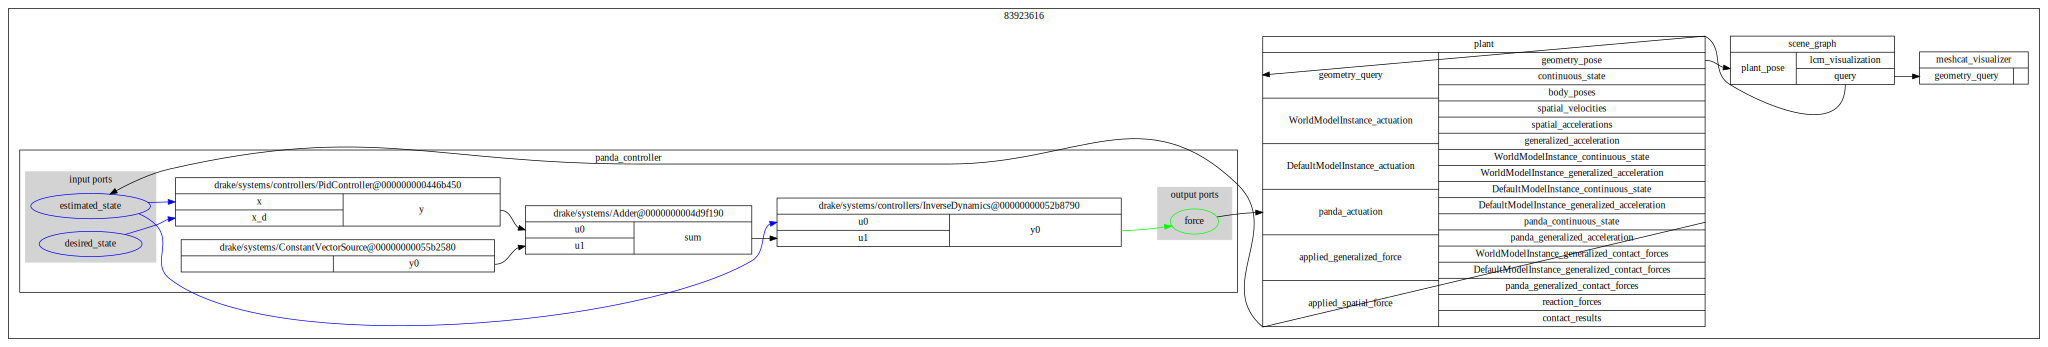

In [55]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

In [61]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0, 0]) # nominal q
x0 = np.hstack((q0, 0*q0))
plant.SetPositions(plant_context, q0)
panda_controller.GetInputPort('desired_state').FixValue(
    panda_controller.GetMyMutableContextFromRoot(context), x0)
print(context)

::_ Context (of a Diagram)
---------------------------
9 total continuous states
18 total discrete states in 1 groups
289 total numeric parameters in 43 groups
1 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6 -1.57  0.04  0.04     0     0     0     0     0     0     0     0     0

Parameters:
  42 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan

In [62]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0);
simulator.AdvanceTo(5.0)